# Análisis de las pruebas realizadas con Blosc 

## Objetivos del análisis
* Relacionar el tamaño de bloque con las medidas de compresión y decompresión.
* Comprobar el comportamiento de los niveles de compresión sobre las pruebas.
* Comparar los datos de compresión de tablas normales y columnares.
* ¿Existe correlación entre blosclz o lz4 con nivel de compresión 1 y el resto de codecs?
* **[Punto muerto]** ¿Existe correlación entre las características del chunk y las medidas de compresión y decompresión?

## Descripción de la muestra

El DataFrame en cuestión está formado por las características extraídas de un array de datos al comprimirlo y descomprimirlo mediante blosc. En cada fichero aparecen distintos conjuntos de datos los cuáles dividimos en fragmentos de 16 MegaBytes y sobre los cuales realizamos las pruebas de compresión y decompresión.  
Cada fila se corresponde con los datos de realizar los test de compresión sobre un fragmento (*chunk*) de datos específico con un tamaño de bloque, codec, filtro y nivel de compresión determinados.

Variable | Descripción
-------------  | -------------
*Filename* | nombre del fichero del que proviene.
*DataSet* | dentro del fichero el conjunto de datos del que proviene.
*Table* | 0 si los datos vienen de un array, 1 si vienen de tablas y 2 para tablas columnares.
*DType* | indica el tipo de los datos.
*Chunk_Number* | número de fragmento dentro del conjunto de datos.
*Chunk_Size* | tamaño del fragmento.
*Mean* | la media.
*Median* | la mediana.
*Sd* | la desviación típica.
*Skew* | el coeficiente de asimetría.
*Kurt* | el coeficiente de apuntamiento.
*Min* | el mínimo absoluto.
*Max* | el máximo absoluto.
*Q1* | el primer cuartil.
*Q3* | el tercer cuartil.
*N_Streaks* | número de rachas seguidas por encima o debajo de la mediana.
*Block_Size* | el tamaño de bloque que utilizará Blosc para comprimir.
*Codec* | el codec de blosc utilizado.
*Filter* | el filtro de blosc utilizado.
*CL* | el nivel de compresión utilizado.
*CRate* | el ratio de compresión obtenido.
*CSpeed* | la velocidad de compresión obtenida en GB/s.
*DSpeed* | la velocidad de decompresión obtenida en GB/s.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Software versions
Python 3.5.2 64bit [MSC v.1900 64 bit (AMD64)]
IPython 5.1.0
OS Windows 10 10.0.14393 SP0
numpy 1.11.1
scipy 0.18.1
matplotlib 2.0.0
pandas 0.19.2
Fri Mar 17 09:25:46 2017 Hora estándar romance

In [2]:
import os
import sys
sys.path.append("../src/")

from IPython.display import display
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

import custom_plots as cst

pd.options.display.float_format = '{:,.3f}'.format
matplotlib.rcParams.update({'font.size': 12})

## Descripción general
Cargamos el csv entero, comprobamos que no faltan campos y mostramos un breve resumen.

In [3]:
# LOAD WHOLE CSV
DF = pd.read_csv('../data/blosc_test_data_v2.csv.gz', sep='\t')
# SORT COLUMNS
DF = DF[cst.COLS]
# CHECK MISSING DATA
if not DF.isnull().any().any():
    print('No missing data')
else:
    print("Missing data")

No missing data


In [4]:
# SUMMARY OF THE DATAFRAME 
display(DF[cst.COLS[5:]].describe())

Chunk_Size           Mean         Median             Sd  \
count 1,038,420.000  1,038,420.000  1,038,420.000  1,038,420.000   
mean         14.905    105,388.308     78,129.425     99,976.259   
std           3.507  1,986,645.954  1,963,930.892    995,299.289   
min           0.015       -509.377       -999.000          0.000   
25%          16.000          0.000          0.000          0.137   
50%          16.000          0.077          0.000          2.248   
75%          16.000          1.976          0.000         13.718   
max          16.000 49,778,180.925 49,760,930.000 14,745,014.725   

               Skew          Kurt            Min            Max  \
count 1,038,420.000 1,038,420.000  1,038,420.000  1,038,420.000   
mean         13.317     2,889.591     65,243.409    545,501.677   
std          40.888    21,176.379  1,654,195.613  5,154,590.640   
min          -0.600        -3.000       -999.000         -4.000   
25%           0.066        -0.904        -12.842          7.000   
50%           3.121        12.392          0.000         31.435   
75%           9.899       175.292          0.000         85.000   
max         497.825   316,831.759 41,913,429.000 64,103,344.000   

                  Q1             Q3    Block_Size            CL         CRate  \
count  1,038,420.000  1,038,420.000 1,038,420.000 1,038,420.000 1,038,420.000   
mean      71,737.862     84,294.961       408.800         5.000        89.698   
std    1,811,803.139  2,109,316.172       626.196         2.582       643.275   
min         -999.000         -4.000         0.000         1.000         0.999   
25%            0.000          0.000        16.000         3.000         2.046   
50%            0.000          0.000        96.000         5.000         5.554   
75%            0.000         18.565       512.000         7.000        19.355   
max   45,906,809.000 53,443,823.000     2,048.000         9.000    10,645.442   

             CSpeed        DSpeed  
count 1,038,420.000 1,038,420.000  
mean          3.172         6.482  
std           3.869         4.144  
min           0.001         0.156  
25%           0.404         3.115  
50%           1.737         5.914  
75%           4.416         9.006  
max          22.118        63.441

Filtramos el csv para eliminar ficheros que utilizan técnicas de compresión con pérdidas.

In [5]:
my_df = DF[(DF.Filename != 'WRF_India-LSD1.h5') & (DF.Filename != 'WRF_India-LSD2.h5') & (DF.Filename != 'WRF_India-LSD3.h5')]

Veamos cuantos conjuntos de datos tiene el fichero.

In [6]:
sets = my_df.drop_duplicates(subset=['DataSet', 'Table'])[cst.DESC_SET]
display(sets)
print('There are %d datasets' % (sets.shape[0]))

DataSet    DType  Table  Chunk_Size
0                                              /U  float32  0.000      16.000
85860                                          /V  float32  0.000      16.000
150660                     /Grids/G1/precipAllObs    int32  0.000       0.738
152280            /Grids/G1/surfPrecipLiqRateProb  float32  0.000       0.015
153900              /Grids/G1/surfPrecipLiqRateUn  float32  0.000       0.015
155520   /Grids/G1/surfPrecipTotRateDiurnalAllObs    int32  0.000       1.107
157140            /Grids/G1/surfPrecipTotRateProb  float32  0.000       0.015
158760              /Grids/G1/surfPrecipTotRateUn  float32  0.000       0.015
160380                     /Grids/G2/precipAllObs    int32  0.000      16.000
170100            /Grids/G2/surfPrecipLiqRateProb  float32  0.000       5.889
171720              /Grids/G2/surfPrecipLiqRateUn  float32  0.000       5.889
173340   /Grids/G2/surfPrecipTotRateDiurnalAllObs    int32  0.000      16.000
187920            /Grids/G2/surfPrecipTotRateProb  float32  0.000       5.889
189540              /Grids/G2/surfPrecipTotRateUn  float32  0.000       5.889
191160              /Grids/G1/precipLiqRate/count    int32  0.000       2.215
192780               /Grids/G1/precipLiqRate/hist    int32  0.000      16.000
200880               /Grids/G1/precipLiqRate/mean  float32  0.000       2.215
202500              /Grids/G1/precipLiqRate/stdev  float32  0.000       2.215
204120      /Grids/G1/precipLiqWaterContent/count    int32  0.000       2.215
205740       /Grids/G1/precipLiqWaterContent/hist    int32  0.000      16.000
213840       /Grids/G1/precipLiqWaterContent/mean  float32  0.000       2.215
215460      /Grids/G1/precipLiqWaterContent/stdev  float32  0.000       2.215
217080                /Grids/G1/precipTotDm/count    int32  0.000       2.215
218700                 /Grids/G1/precipTotDm/hist    int32  0.000      16.000
226800                 /Grids/G1/precipTotDm/mean  float32  0.000       2.215
228420                /Grids/G1/precipTotDm/stdev  float32  0.000       2.215
230040             /Grids/G1/precipTotLogNw/count    int32  0.000       2.215
231660              /Grids/G1/precipTotLogNw/hist    int32  0.000      16.000
239760              /Grids/G1/precipTotLogNw/mean  float32  0.000       2.215
241380             /Grids/G1/precipTotLogNw/stdev  float32  0.000       2.215
...                                           ...      ...    ...         ...
270540    /Grids/G1/surfPrecipTotRateDiurnal/mean  float32  0.000       1.107
272160   /Grids/G1/surfPrecipTotRateDiurnal/stdev  float32  0.000       1.107
273780              /Grids/G2/precipLiqRate/count    int32  0.000      16.000
302940               /Grids/G2/precipLiqRate/mean  float32  0.000      16.000
332100              /Grids/G2/precipLiqRate/stdev  float32  0.000      16.000
361260      /Grids/G2/precipLiqWaterContent/count    int32  0.000      16.000
390420       /Grids/G2/precipLiqWaterContent/mean  float32  0.000      16.000
419580      /Grids/G2/precipLiqWaterContent/stdev  float32  0.000      16.000
448740                /Grids/G2/precipTotDm/count    int32  0.000      16.000
477900                 /Grids/G2/precipTotDm/mean  float32  0.000      16.000
507060                /Grids/G2/precipTotDm/stdev  float32  0.000      16.000
536220             /Grids/G2/precipTotLogNw/count    int32  0.000      16.000
565380              /Grids/G2/precipTotLogNw/mean  float32  0.000      16.000
594540             /Grids/G2/precipTotLogNw/stdev  float32  0.000      16.000
623700              /Grids/G2/precipTotRate/count    int32  0.000      16.000
652860               /Grids/G2/precipTotRate/mean  float32  0.000      16.000
682020              /Grids/G2/precipTotRate/stdev  float32  0.000      16.000
711180      /Grids/G2/precipTotWaterContent/count    int32  0.000      16.000
740340       /Grids/G2/precipTotWaterContent/mean  float32  0.000      16.000
769500      /Grids/G2/precipTotWaterContent/stdev  float32  0.00

There are 69 datasets


Procedemos a mostrar un resumen de las características extraídas de cada conjunto de datos.

In [7]:
for dataset in sets.drop_duplicates(subset=['DataSet'])['DataSet']:
        set_info = sets[sets.DataSet == dataset]
        print('SUMMARY')
        print(set_info)
        aux_set = my_df[my_df.DataSet == dataset].drop_duplicates(subset=['Chunk_Number'])
        if aux_set.shape[0] > 1:
            display(aux_set.describe()[cst.CHUNK_FEATURES])
        else:
            display(aux_set[cst.CHUNK_FEATURES])

SUMMARY
  DataSet    DType  Table  Chunk_Size
0      /U  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew   Kurt     Min    Max     Q1  \
count      53.000 53.000  53.000 53.000 53.000 53.000  53.000 53.000 53.000   
mean       15.726 14.314   9.838 12.731  0.624 -0.720 -15.663 48.531  4.747   
std         1.995  4.350   3.881  2.527  0.153  0.319   4.249  9.016  3.546   
min         1.475  5.762   2.096  6.404  0.228 -1.164 -28.273 27.146 -1.446   
25%        16.000 10.708   7.198 11.469  0.532 -0.921 -17.664 43.313  1.943   
50%        16.000 15.430   9.564 13.268  0.649 -0.793 -14.891 50.507  4.873   
75%        16.000 17.302  13.019 14.752  0.738 -0.624 -12.637 53.064  7.273   
max        16.000 22.909  16.944 17.010  1.072  0.549  -9.488 62.922 10.356   

          Q3  
count 53.000  
mean  24.449  
std    6.457  
min   11.317  
25%   18.781  
50%   25.905  
75%   27.890  
max   38.366

SUMMARY
      DataSet    DType  Table  Chunk_Size
85860      /V  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew   Kurt     Min    Max     Q1  \
count      40.000 40.000  40.000 40.000 40.000 40.000  40.000 40.000 40.000   
mean       15.900  2.073   1.526  4.976  0.311  0.301 -16.644 23.037 -1.197   
std         0.631  2.517   1.696  2.391  0.510  0.742   4.047  9.672  1.472   
min        12.009 -1.626  -1.256  2.474 -0.600 -0.370 -29.640 13.443 -4.887   
25%        16.000 -0.240  -0.088  3.414 -0.031 -0.162 -19.447 16.708 -2.397   
50%        16.000  1.886   1.721  4.303  0.253  0.240 -16.237 20.683 -0.907   
75%        16.000  3.743   2.851  5.930  0.644  0.484 -13.344 25.571 -0.204   
max        16.000  9.091   4.968 14.419  1.748  4.040 -11.483 56.161  1.253   

          Q3  
count 40.000  
mean   4.881  
std    3.369  
min    0.552  
25%    2.357  
50%    4.500  
75%    6.422  
max   15.373

SUMMARY
                       DataSet  DType  Table  Chunk_Size
150660  /Grids/G1/precipAllObs  int32  0.000       0.738


Chunk_Size       Mean     Median         Sd  Skew  Kurt   Min  \
150660       0.738 46,750.635 42,412.000 42,964.463 1.123 2.123 0.000   

               Max      Q1         Q3  
150660 211,383.000 121.000 79,434.750

SUMMARY
                                DataSet    DType  Table  Chunk_Size
152280  /Grids/G1/surfPrecipLiqRateProb  float32  0.000       0.015


Chunk_Size  Mean  Median    Sd  Skew  Kurt   Min   Max    Q1    Q3
152280       0.015 0.044   0.037 0.040 1.346 3.059 0.000 0.352 0.011 0.066

SUMMARY
                              DataSet    DType  Table  Chunk_Size
153900  /Grids/G1/surfPrecipLiqRateUn  float32  0.000       0.015


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
153900       0.015 0.092   0.048 0.123 2.762 12.094 0.000 1.414 0.011 0.124

SUMMARY
                                         DataSet  DType  Table  Chunk_Size
155520  /Grids/G1/surfPrecipTotRateDiurnalAllObs  int32  0.000       1.107


Chunk_Size      Mean  Median        Sd  Skew   Kurt   Min        Max  \
155520       1.107 1,947.943 272.000 2,888.095 2.804 13.277 0.000 24,063.000   

          Q1        Q3  
155520 0.000 3,094.000

SUMMARY
                                DataSet    DType  Table  Chunk_Size
157140  /Grids/G1/surfPrecipTotRateProb  float32  0.000       0.015


Chunk_Size  Mean  Median    Sd  Skew  Kurt   Min   Max    Q1    Q3
157140       0.015 0.050   0.043 0.040 1.218 2.721 0.000 0.352 0.018 0.072

SUMMARY
                              DataSet    DType  Table  Chunk_Size
158760  /Grids/G1/surfPrecipTotRateUn  float32  0.000       0.015


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
158760       0.015 0.101   0.064 0.121 2.739 12.272 0.000 1.414 0.022 0.133

SUMMARY
                       DataSet  DType  Table  Chunk_Size
160380  /Grids/G2/precipAllObs  int32  0.000      16.000


Chunk_Size    Mean  Median      Sd  Skew  Kurt   Min     Max      Q1  \
count       6.000   6.000   6.000   6.000 6.000 6.000 6.000   6.000   6.000   
mean       15.703 183.354 173.500 107.464 2.317 9.421 0.000 910.000 116.167   
std         0.727   6.775  10.710   1.604 0.023 0.173 0.000   0.000   5.742   
min        14.219 176.954 163.000 105.856 2.292 9.218 0.000 910.000 111.000   
25%        16.000 177.709 164.250 106.084 2.296 9.273 0.000 910.000 111.500   
50%        16.000 181.741 171.500 107.211 2.316 9.426 0.000 910.000 114.500   
75%        16.000 187.916 181.750 108.644 2.338 9.577 0.000 910.000 119.750   
max        16.000 193.347 188.000 109.676 2.342 9.605 0.000 910.000 125.000   

           Q3  
count   6.000  
mean  222.333  
std     4.502  
min   218.000  
25%   218.500  
50%   221.500  
75%   225.250  
max   229.000

SUMMARY
                                DataSet    DType  Table  Chunk_Size
170100  /Grids/G2/surfPrecipLiqRateProb  float32  0.000       5.889


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
170100       5.889 0.045   0.009 0.074 2.804 12.031 0.000 1.000 0.000 0.063

SUMMARY
                              DataSet    DType  Table  Chunk_Size
171720  /Grids/G2/surfPrecipLiqRateUn  float32  0.000       5.889


Chunk_Size  Mean  Median    Sd   Skew    Kurt   Min    Max    Q1    Q3
171720       5.889 0.094   0.004 0.337 12.404 321.944 0.000 26.186 0.000 0.051

SUMMARY
                                         DataSet  DType  Table  Chunk_Size
173340  /Grids/G2/surfPrecipTotRateDiurnalAllObs  int32  0.000      16.000


Chunk_Size  Mean  Median     Sd  Skew   Kurt   Min     Max    Q1     Q3
count       9.000 9.000   9.000  9.000 9.000  9.000 9.000   9.000 9.000  9.000
mean       15.703 7.629   0.000 12.705 1.798  4.317 0.000 102.222 0.000 13.778
std         0.891 1.237   0.000  0.843 0.792  4.134 0.000  17.683 0.000  8.059
min        13.328 5.467   0.000 11.541 0.728 -1.091 0.000  65.000 0.000  0.000
25%        16.000 7.239   0.000 11.730 1.005 -0.012 0.000  93.000 0.000 14.000
50%        16.000 8.051   0.000 12.935 1.725  4.011 0.000 113.000 0.000 18.000
75%        16.000 8.505   0.000 13.343 2.259  6.763 0.000 113.000 0.000 19.000
max        16.000 9.073   0.000 13.710 2.875  9.907 0.000 114.000 0.000 20.000

SUMMARY
                                DataSet    DType  Table  Chunk_Size
187920  /Grids/G2/surfPrecipTotRateProb  float32  0.000       5.889


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
187920       5.889 0.050   0.017 0.075 2.606 10.682 0.000 1.000 0.000 0.074

SUMMARY
                              DataSet    DType  Table  Chunk_Size
189540  /Grids/G2/surfPrecipTotRateUn  float32  0.000       5.889


Chunk_Size  Mean  Median    Sd   Skew    Kurt   Min    Max    Q1    Q3
189540       5.889 0.103   0.011 0.338 12.253 317.113 0.000 26.186 0.000 0.074

SUMMARY
                              DataSet  DType  Table  Chunk_Size
191160  /Grids/G1/precipLiqRate/count  int32  0.000       2.215


Chunk_Size    Mean  Median        Sd  Skew   Kurt   Min        Max  \
191160       2.215 290.349   0.000 1,105.965 6.631 63.209 0.000 27,765.000   

          Q1    Q3  
191160 0.000 0.000

SUMMARY
                             DataSet  DType  Table  Chunk_Size
192780  /Grids/G1/precipLiqRate/hist  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew       Kurt   Min       Max  \
count       5.000  5.000   5.000  5.000  5.000      5.000 5.000     5.000   
mean       13.289  8.039   0.000 37.628 29.783  3,946.721 0.000 1,672.200   
std         6.062  8.998   0.000 39.709 39.245  8,240.638 0.000 1,584.709   
min         2.445  0.000   0.000  0.027  8.448    112.235 0.000     8.000   
25%        16.000  0.256   0.000  2.879  8.726    116.838 0.000   222.000   
50%        16.000  4.585   0.000 25.789 12.198    243.864 0.000 1,574.000   
75%        16.000 16.949   0.000 78.809 20.056    576.522 0.000 3,243.000   
max        16.000 18.402   0.000 80.639 99.485 18,684.148 0.000 3,314.000   

         Q1    Q3  
count 5.000 5.000  
mean  0.000 0.000  
std   0.000 0.000  
min   0.000 0.000  
25%   0.000 0.000  
50%   0.000 0.000  
75%   0.000 0.000  
max   0.000 0.000

SUMMARY
                             DataSet    DType  Table  Chunk_Size
200880  /Grids/G1/precipLiqRate/mean  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew    Kurt   Min     Max    Q1    Q3
200880       2.215 0.456   0.000 1.532 8.146 210.120 0.000 122.311 0.000 0.000

SUMMARY
                              DataSet    DType  Table  Chunk_Size
202500  /Grids/G1/precipLiqRate/stdev  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min    Max    Q1    Q3
202500       2.215 0.650   0.000 2.098 4.997 32.385 0.000 43.932 0.000 0.000

SUMMARY
                                      DataSet  DType  Table  Chunk_Size
204120  /Grids/G1/precipLiqWaterContent/count  int32  0.000       2.215


Chunk_Size    Mean  Median        Sd  Skew   Kurt   Min        Max  \
204120       2.215 290.345   0.000 1,105.955 6.631 63.210 0.000 27,765.000   

          Q1    Q3  
204120 0.000 0.000

SUMMARY
                                     DataSet  DType  Table  Chunk_Size
205740  /Grids/G1/precipLiqWaterContent/hist  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew      Kurt   Min       Max  \
count       5.000  5.000   5.000  5.000  5.000     5.000 5.000     5.000   
mean       13.289  8.039   0.000 37.307 19.295   988.704 0.000 1,682.600   
std         6.062  8.647   0.000 37.812 17.888 1,688.395 0.000 1,473.851   
min         2.445  0.002   0.000  0.055  8.180   105.888 0.000     8.000   
25%        16.000  0.505   0.000  4.463  9.521   136.409 0.000   534.000   
50%        16.000  5.707   0.000 28.381 10.514   180.766 0.000 1,499.000   
75%        16.000 14.534   0.000 71.785 17.644   526.645 0.000 3,111.000   
max        16.000 19.445   0.000 81.850 50.616 3,993.813 0.000 3,261.000   

         Q1    Q3  
count 5.000 5.000  
mean  0.000 0.000  
std   0.000 0.000  
min   0.000 0.000  
25%   0.000 0.000  
50%   0.000 0.000  
75%   0.000 0.000  
max   0.000 0.000

SUMMARY
                                     DataSet    DType  Table  Chunk_Size
213840  /Grids/G1/precipLiqWaterContent/mean  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
213840       2.215 0.036   0.000 0.104 5.367 54.662 0.000 4.711 0.000 0.000

SUMMARY
                                      DataSet    DType  Table  Chunk_Size
215460  /Grids/G1/precipLiqWaterContent/stdev  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
215460       2.215 0.044   0.000 0.127 4.180 23.454 0.000 3.249 0.000 0.000

SUMMARY
                            DataSet  DType  Table  Chunk_Size
217080  /Grids/G1/precipTotDm/count  int32  0.000       2.215


Chunk_Size    Mean  Median        Sd  Skew   Kurt   Min        Max  \
217080       2.215 448.096   0.000 1,326.224 5.267 40.686 0.000 28,569.000   

          Q1      Q3  
217080 0.000 133.000

SUMMARY
                           DataSet  DType  Table  Chunk_Size
218700  /Grids/G1/precipTotDm/hist  int32  0.000      16.000


Chunk_Size   Mean  Median      Sd   Skew      Kurt   Min       Max  \
count       5.000  5.000   5.000   5.000  5.000     5.000 5.000     5.000   
mean       13.289 12.435   0.000  59.024 14.518   420.334 0.000 2,956.400   
std         6.062 16.223   0.000  70.813  5.669   397.280 0.000 3,262.573   
min         2.445  0.174   0.000   1.476  8.436   115.124 0.000   120.000   
25%        16.000  0.247   0.000   1.770 12.399   236.340 0.000   123.000   
50%        16.000  4.057   0.000  22.359 13.068   290.349 0.000 1,645.000   
75%        16.000 20.339   0.000 116.685 14.963   345.400 0.000 5,991.000   
max        16.000 37.359   0.000 152.827 23.725 1,114.457 0.000 6,903.000   

         Q1    Q3  
count 5.000 5.000  
mean  0.000 0.200  
std   0.000 0.447  
min   0.000 0.000  
25%   0.000 0.000  
50%   0.000 0.000  
75%   0.000 0.000  
max   0.000 1.000

SUMMARY
                           DataSet    DType  Table  Chunk_Size
226800  /Grids/G1/precipTotDm/mean  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
226800       2.215 0.372   0.000 0.462 0.751 -0.713 0.000 3.912 0.000 0.723

SUMMARY
                            DataSet    DType  Table  Chunk_Size
228420  /Grids/G1/precipTotDm/stdev  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
228420       2.215 0.088   0.000 0.145 4.611 99.472 0.000 7.870 0.000 0.152

SUMMARY
                               DataSet  DType  Table  Chunk_Size
230040  /Grids/G1/precipTotLogNw/count  int32  0.000       2.215


Chunk_Size    Mean  Median        Sd  Skew   Kurt   Min        Max  \
230040       2.215 547.558   0.000 1,556.714 5.086 37.663 0.000 31,082.000   

          Q1      Q3  
230040 0.000 199.000

SUMMARY
                              DataSet  DType  Table  Chunk_Size
231660  /Grids/G1/precipTotLogNw/hist  int32  0.000      16.000


Chunk_Size   Mean  Median      Sd   Skew    Kurt   Min        Max  \
count       5.000  5.000   5.000   5.000  5.000   5.000 5.000      5.000   
mean       13.289 15.174   0.000  84.957 12.545 341.127 0.000  6,379.400   
std         6.062 23.427   0.000 113.093  7.418 223.816 0.000  8,125.515   
min         2.445  0.000   0.000   0.000  0.000  -3.000 0.000      0.000   
25%        16.000  0.086   0.000   0.652 11.657 244.801 0.000     53.000   
50%        16.000  2.822   0.000  18.682 16.203 426.538 0.000  1,327.000   
75%        16.000 18.085   0.000 154.231 16.794 484.369 0.000 14,965.000   
max        16.000 54.877   0.000 251.221 18.071 552.928 0.000 15,552.000   

         Q1    Q3  
count 5.000 5.000  
mean  0.000 0.800  
std   0.000 1.789  
min   0.000 0.000  
25%   0.000 0.000  
50%   0.000 0.000  
75%   0.000 0.000  
max   0.000 4.000

SUMMARY
                              DataSet    DType  Table  Chunk_Size
239760  /Grids/G1/precipTotLogNw/mean  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
239760       2.215 3.392   0.000 3.697 0.191 -1.926 0.000 9.957 0.000 7.310

SUMMARY
                               DataSet    DType  Table  Chunk_Size
241380  /Grids/G1/precipTotLogNw/stdev  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew  Kurt   Min   Max    Q1    Q3
241380       2.215 0.129   0.000 0.174 1.084 0.046 0.000 1.303 0.000 0.246

SUMMARY
                              DataSet  DType  Table  Chunk_Size
243000  /Grids/G1/precipTotRate/count  int32  0.000       2.215


Chunk_Size    Mean  Median        Sd  Skew   Kurt   Min        Max  \
243000       2.215 448.460   0.000 1,326.900 5.265 40.637 0.000 28,569.000   

          Q1      Q3  
243000 0.000 134.000

SUMMARY
                             DataSet  DType  Table  Chunk_Size
244620  /Grids/G1/precipTotRate/hist  int32  0.000      16.000


Chunk_Size   Mean  Median      Sd   Skew      Kurt   Min       Max  \
count       5.000  5.000   5.000   5.000  5.000     5.000 5.000     5.000   
mean       13.289 12.416   0.000  48.134 18.219   903.809 0.000 1,956.400   
std         6.062 16.201   0.000  55.736 16.732 1,561.170 0.000 2,024.067   
min         2.445  0.001   0.000   0.045  6.722    70.836 0.000     7.000   
25%        16.000  0.342   0.000   3.142  8.825   118.443 0.000   222.000   
50%        16.000  6.154   0.000  28.635 10.666   188.103 0.000 1,574.000   
75%        16.000 16.885   0.000  78.235 17.648   458.031 0.000 3,226.000   
max        16.000 38.698   0.000 130.615 47.237 3,683.632 0.000 4,753.000   

         Q1    Q3  
count 5.000 5.000  
mean  0.000 1.600  
std   0.000 3.578  
min   0.000 0.000  
25%   0.000 0.000  
50%   0.000 0.000  
75%   0.000 0.000  
max   0.000 8.000

SUMMARY
                             DataSet    DType  Table  Chunk_Size
252720  /Grids/G1/precipTotRate/mean  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew    Kurt   Min     Max    Q1    Q3
252720       2.215 0.958   0.000 1.966 7.487 176.814 0.000 122.311 0.000 1.304

SUMMARY
                              DataSet    DType  Table  Chunk_Size
254340  /Grids/G1/precipTotRate/stdev  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min    Max    Q1    Q3
254340       2.215 1.129   0.000 2.648 4.428 34.107 0.000 83.595 0.000 0.935

SUMMARY
                                      DataSet  DType  Table  Chunk_Size
255960  /Grids/G1/precipTotWaterContent/count  int32  0.000       2.215


Chunk_Size    Mean  Median        Sd  Skew   Kurt   Min        Max  \
255960       2.215 448.131   0.000 1,326.512 5.267 40.665 0.000 28,568.000   

          Q1      Q3  
255960 0.000 133.000

SUMMARY
                                     DataSet  DType  Table  Chunk_Size
257580  /Grids/G1/precipTotWaterContent/hist  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew    Kurt   Min       Max    Q1  \
count       5.000  5.000   5.000  5.000  5.000   5.000 5.000     5.000 5.000   
mean       13.289 12.451   0.000 52.148 11.020 208.264 0.000 2,301.600 0.000   
std         6.062 11.237   0.000 42.869  3.464 128.644 0.000 1,730.232 0.000   
min         2.445  0.261   0.000  1.994  7.174  79.899 0.000   108.000 0.000   
25%        16.000  1.962   0.000 10.808  8.621 117.807 0.000   897.000 0.000   
50%        16.000 12.938   0.000 67.805 10.065 150.893 0.000 3,050.000 0.000   
75%        16.000 23.513   0.000 88.349 14.069 339.163 0.000 3,193.000 0.000   
max        16.000 23.580   0.000 91.784 15.173 353.560 0.000 4,260.000 0.000   

         Q3  
count 5.000  
mean  1.000  
std   1.732  
min   0.000  
25%   0.000  
50%   0.000  
75%   1.000  
max   4.000

SUMMARY
                                     DataSet    DType  Table  Chunk_Size
265680  /Grids/G1/precipTotWaterContent/mean  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
265680       2.215 0.196   0.000 0.344 3.503 29.819 0.000 9.445 0.000 0.341

SUMMARY
                                      DataSet    DType  Table  Chunk_Size
267300  /Grids/G1/precipTotWaterContent/stdev  float32  0.000       2.215


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min   Max    Q1    Q3
267300       2.215 0.163   0.000 0.329 3.201 12.698 0.000 4.015 0.000 0.205

SUMMARY
                                         DataSet  DType  Table  Chunk_Size
268920  /Grids/G1/surfPrecipTotRateDiurnal/count  int32  0.000       1.107


Chunk_Size   Mean  Median      Sd  Skew   Kurt   Min       Max    Q1  \
268920       1.107 97.688   0.000 285.385 5.308 39.019 0.000 5,666.000 0.000   

           Q3  
268920 40.000

SUMMARY
                                        DataSet    DType  Table  Chunk_Size
270540  /Grids/G1/surfPrecipTotRateDiurnal/mean  float32  0.000       1.107


Chunk_Size  Mean  Median    Sd   Skew    Kurt   Min     Max    Q1  \
270540       1.107 0.591   0.000 1.355 16.012 879.167 0.000 128.023 0.000   

          Q3  
270540 0.796

SUMMARY
                                         DataSet    DType  Table  Chunk_Size
272160  /Grids/G1/surfPrecipTotRateDiurnal/stdev  float32  0.000       1.107


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min    Max    Q1    Q3
272160       1.107 0.771   0.000 2.007 6.019 90.559 0.000 91.046 0.000 0.536

SUMMARY
                              DataSet  DType  Table  Chunk_Size
273780  /Grids/G2/precipLiqRate/count  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew      Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000 18.000    18.000 18.000  18.000   
mean       15.703  1.116   0.000  2.974  6.481   180.121  0.000  69.889   
std         1.260  1.730   0.000  3.775 10.321   501.302  0.000  69.628   
min        10.656  0.000   0.000  0.000  0.000    -3.000  0.000   0.000   
25%        16.000  0.000   0.000  0.000  0.000    -3.000  0.000   0.000   
50%        16.000  0.101   0.000  0.951  3.409    15.641  0.000  60.000   
75%        16.000  1.624   0.000  5.388  6.060    49.034  0.000 143.250   
max        16.000  5.748   0.000 11.004 41.152 2,111.449  0.000 175.000   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.556  
std    0.000  1.542  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.000  
max    0.000  6.000

SUMMARY
                             DataSet    DType  Table  Chunk_Size
302940  /Grids/G2/precipLiqRate/mean  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd    Skew       Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000  18.000     18.000 18.000  18.000   
mean       15.703  0.187   0.000  0.686  14.115  1,546.143  0.000  77.343   
std         1.260  0.286   0.000  0.902  25.548  5,105.949  0.000  96.388   
min        10.656  0.000   0.000  0.000   0.000     -3.000  0.000   0.000   
25%        16.000  0.000   0.000  0.000   0.000     -3.000  0.000   0.000   
50%        16.000  0.017   0.000  0.218   6.596     91.487  0.000  28.947   
75%        16.000  0.296   0.000  1.023  16.177    715.496  0.000 157.397   
max        16.000  0.989   0.000  2.996 108.763 21,889.348  0.000 295.298   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.086  
std    0.000  0.203  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.000  
max    0.000  0.647

SUMMARY
                              DataSet    DType  Table  Chunk_Size
332100  /Grids/G2/precipLiqRate/stdev  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd    Skew       Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000  18.000     18.000 18.000  18.000   
mean       15.703  0.140   0.000  0.589  16.052  2,989.569  0.000  53.402   
std         1.260  0.213   0.000  0.755  31.771 10,550.917  0.000  56.937   
min        10.656  0.000   0.000  0.000   0.000     -3.000  0.000   0.000   
25%        16.000  0.000   0.000  0.000   0.000     -3.000  0.000   0.000   
50%        16.000  0.011   0.000  0.162   6.036     64.670  0.000  31.550   
75%        16.000  0.203   0.000  1.004  14.155    640.694  0.000 113.004   
max        16.000  0.660   0.000  2.248 135.611 45,023.028  0.000 138.487   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.023  
std    0.000  0.074  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.000  
max    0.000  0.298

SUMMARY
                                      DataSet  DType  Table  Chunk_Size
361260  /Grids/G2/precipLiqWaterContent/count  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew      Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000 18.000    18.000 18.000  18.000   
mean       15.703  1.116   0.000  2.974  6.481   180.082  0.000  69.889   
std         1.260  1.730   0.000  3.774 10.320   501.151  0.000  69.628   
min        10.656  0.000   0.000  0.000  0.000    -3.000  0.000   0.000   
25%        16.000  0.000   0.000  0.000  0.000    -3.000  0.000   0.000   
50%        16.000  0.101   0.000  0.951  3.409    15.641  0.000  60.000   
75%        16.000  1.624   0.000  5.388  6.060    49.035  0.000 143.250   
max        16.000  5.748   0.000 11.004 41.147 2,110.792  0.000 175.000   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.556  
std    0.000  1.542  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.000  
max    0.000  6.000

SUMMARY
                                     DataSet    DType  Table  Chunk_Size
390420  /Grids/G2/precipLiqWaterContent/mean  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew       Kurt    Min    Max  \
count      18.000 18.000  18.000 18.000 18.000     18.000 18.000 18.000   
mean       15.703  0.015   0.000  0.048 12.106  1,176.595  0.000  4.379   
std         1.260  0.021   0.000  0.058 22.161  3,893.149  0.000  4.065   
min        10.656  0.000   0.000  0.000  0.000     -3.000  0.000  0.000   
25%        16.000  0.000   0.000  0.000  0.000     -3.000  0.000  0.000   
50%        16.000  0.003   0.000  0.035  5.869     80.234  0.000  4.407   
75%        16.000  0.025   0.000  0.060 12.625    639.552  0.000  8.588   
max        16.000  0.067   0.000  0.175 94.256 16,687.977  0.000  9.696   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.008  
std    0.000  0.019  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.000  
max    0.000  0.058

SUMMARY
                                      DataSet    DType  Table  Chunk_Size
419580  /Grids/G2/precipLiqWaterContent/stdev  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew       Kurt    Min    Max  \
count      18.000 18.000  18.000 18.000 18.000     18.000 18.000 18.000   
mean       15.703  0.010   0.000  0.038 11.486    835.252  0.000  2.259   
std         1.260  0.014   0.000  0.044 20.344  2,660.245  0.000  1.947   
min        10.656  0.000   0.000  0.000  0.000     -3.000  0.000  0.000   
25%        16.000  0.000   0.000  0.000  0.000     -3.000  0.000  0.000   
50%        16.000  0.002   0.000  0.025  5.575     55.408  0.000  2.821   
75%        16.000  0.015   0.000  0.052  9.562    141.844  0.000  4.013   
max        16.000  0.040   0.000  0.118 85.130 11,360.029  0.000  4.575   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.002  
std    0.000  0.006  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.000  
max    0.000  0.025

SUMMARY
                            DataSet  DType  Table  Chunk_Size
448740  /Grids/G2/precipTotDm/count  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew      Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000 18.000    18.000 18.000  18.000   
mean       15.703  1.723   0.056  4.212 14.227   746.306  0.000  96.222   
std         1.260  2.224   0.236  3.901 16.397 1,691.575  0.000  53.290   
min        10.656  0.001   0.000  0.042  2.541     9.251  0.000  11.000   
25%        16.000  0.153   0.000  1.139  4.039    22.405  0.000  55.500   
50%        16.000  0.641   0.000  2.752  6.444    56.111  0.000  77.500   
75%        16.000  1.753   0.000  6.213 12.021   191.830  0.000 147.500   
max        16.000  7.195   1.000 11.825 57.967 6,928.863  0.000 175.000   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  1.556  
std    0.000  2.975  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  1.500  
max    0.000 10.000

SUMMARY
                           DataSet    DType  Table  Chunk_Size
477900  /Grids/G2/precipTotDm/mean  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew      Kurt    Min    Max     Q1  \
count      18.000 18.000  18.000 18.000 18.000    18.000 18.000 18.000 18.000   
mean       15.703  0.162   0.040  0.274  6.114   101.237  0.000  3.361  0.000   
std         1.260  0.182   0.170  0.191  8.065   249.992  0.000  0.958  0.000   
min        10.656  0.001   0.000  0.020  0.157    -1.389  0.000  1.158  0.000   
25%        16.000  0.025   0.000  0.126  1.196     0.233  0.000  3.235  0.000   
50%        16.000  0.089   0.000  0.242  3.015     8.887  0.000  3.856  0.000   
75%        16.000  0.301   0.000  0.445  5.547    32.356  0.000  3.959  0.000   
max        16.000  0.564   0.720  0.578 31.921 1,046.805  0.000  3.999  0.000   

          Q3  
count 18.000  
mean   0.249  
std    0.417  
min    0.000  
25%    0.000  
50%    0.000  
75%    0.575  
max    1.032

SUMMARY
                            DataSet    DType  Table  Chunk_Size
507060  /Grids/G2/precipTotDm/stdev  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd    Skew       Kurt    Min    Max  \
count      18.000 18.000  18.000 18.000  18.000     18.000 18.000 18.000   
mean       15.703  0.023   0.000  0.055  24.031  4,421.390  0.000  1.480   
std         1.260  0.028   0.000  0.044  56.508 17,067.517  0.000  0.388   
min        10.656  0.000   0.000  0.001   1.690      3.841  0.000  0.239   
25%        16.000  0.003   0.000  0.019   2.913     12.174  0.000  1.543   
50%        16.000  0.011   0.000  0.046   6.459     61.163  0.000  1.582   
75%        16.000  0.041   0.000  0.089  12.456    314.355  0.000  1.676   
max        16.000  0.093   0.000  0.130 245.611 72,752.224  0.000  1.856   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.025  
std    0.000  0.051  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.012  
max    0.000  0.169

SUMMARY
                               DataSet  DType  Table  Chunk_Size
536220  /Grids/G2/precipTotLogNw/count  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew      Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000 18.000    18.000 18.000  18.000   
mean       15.703  2.106   0.167  4.762 12.146   418.776  0.000 105.944   
std         1.260  2.671   0.514  4.371 12.597   701.827  0.000  59.545   
min        10.656  0.004   0.000  0.078  2.413     8.330  0.000  11.000   
25%        16.000  0.157   0.000  1.162  3.538    16.850  0.000  55.750   
50%        16.000  1.268   0.000  3.507  5.710    44.225  0.000  85.000   
75%        16.000  2.011   0.000  7.067 11.787   184.479  0.000 155.000   
max        16.000  8.564   2.000 13.245 37.539 1,884.219  0.000 193.000   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  2.056  
std    0.000  3.811  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  2.000  
max    0.000 13.000

SUMMARY
                              DataSet    DType  Table  Chunk_Size
565380  /Grids/G2/precipTotLogNw/mean  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew    Kurt    Min    Max     Q1  \
count      18.000 18.000  18.000 18.000 18.000  18.000 18.000 18.000 18.000   
mean       15.703  1.445   0.735  2.273  4.434  46.850  0.000  9.877  0.000   
std         1.260  1.403   2.140  1.147  5.551  93.752  0.000  0.217  0.000   
min        10.656  0.024   0.000  0.430 -0.430  -1.953  0.000  9.178  0.000   
25%        16.000  0.293   0.000  1.426  0.539  -1.676  0.000  9.921  0.000   
50%        16.000  1.003   0.000  2.507  2.104   2.454  0.000  9.967  0.000   
75%        16.000  2.652   0.000  3.397  4.854  21.648  0.000  9.984  0.000   
max        16.000  4.211   6.647  3.568 18.154 327.643  0.000  9.998  0.000   

          Q3  
count 18.000  
mean   2.291  
std    3.334  
min    0.000  
25%    0.000  
50%    0.000  
75%    6.741  
max    7.043

SUMMARY
                               DataSet    DType  Table  Chunk_Size
594540  /Grids/G2/precipTotLogNw/stdev  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd    Skew       Kurt    Min    Max  \
count      18.000 18.000  18.000 18.000  18.000     18.000 18.000 18.000   
mean       15.703  0.033   0.003  0.075  15.739  1,878.335  0.000  1.474   
std         1.260  0.035   0.013  0.043  31.126  7,120.602  0.000  0.206   
min        10.656  0.000   0.000  0.002   1.284      1.706  0.000  0.865   
25%        16.000  0.005   0.000  0.040   3.015     10.717  0.000  1.371   
50%        16.000  0.023   0.000  0.080   4.557     26.191  0.000  1.509   
75%        16.000  0.043   0.000  0.106   9.583    107.163  0.000  1.636   
max        16.000  0.113   0.054  0.139 134.109 30,370.566  0.000  1.709   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.038  
std    0.000  0.068  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.041  
max    0.000  0.199

SUMMARY
                              DataSet  DType  Table  Chunk_Size
623700  /Grids/G2/precipTotRate/count  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew      Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000 18.000    18.000 18.000  18.000   
mean       15.703  1.724   0.056  4.216 14.224   746.030  0.000  96.222   
std         1.260  2.226   0.236  3.904 16.394 1,691.418  0.000  53.290   
min        10.656  0.001   0.000  0.042  2.540     9.240  0.000  11.000   
25%        16.000  0.153   0.000  1.141  4.039    22.403  0.000  55.500   
50%        16.000  0.641   0.000  2.754  6.441    56.051  0.000  77.500   
75%        16.000  1.755   0.000  6.222 12.018   191.738  0.000 147.500   
max        16.000  7.200   1.000 11.832 57.967 6,928.863  0.000 175.000   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  1.556  
std    0.000  2.975  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  1.500  
max    0.000 10.000

SUMMARY
                             DataSet    DType  Table  Chunk_Size
652860  /Grids/G2/precipTotRate/mean  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd    Skew       Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000  18.000     18.000 18.000  18.000   
mean       15.703  0.313   0.019  1.063  43.524 11,967.816  0.000 160.361   
std         1.260  0.330   0.080  0.841  55.596 24,314.865  0.000  72.186   
min        10.656  0.001   0.000  0.080   4.918     52.856  0.000  41.717   
25%        16.000  0.075   0.000  0.450   8.727    201.248  0.000  96.891   
50%        16.000  0.207   0.000  0.899  19.486  1,210.433  0.000 193.685   
75%        16.000  0.470   0.000  1.443  58.571  9,298.809  0.000 209.951   
max        16.000  1.116   0.341  3.098 199.003 85,613.265  0.000 242.941   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.222  
std    0.000  0.373  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.511  
max    0.000  1.005

SUMMARY
                              DataSet    DType  Table  Chunk_Size
682020  /Grids/G2/precipTotRate/stdev  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd    Skew        Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000  18.000      18.000 18.000  18.000   
mean       15.703  0.200   0.000  0.886  78.894  36,212.459  0.000 100.504   
std         1.260  0.232   0.000  0.711 133.720  89,119.753  0.000  34.867   
min        10.656  0.000   0.000  0.011   5.560      51.032  0.000   9.596   
25%        16.000  0.025   0.000  0.267  10.123     198.872  0.000  82.113   
50%        16.000  0.119   0.000  0.659  21.039     904.843  0.000 110.162   
75%        16.000  0.264   0.000  1.284  82.732  14,026.322  0.000 125.372   
max        16.000  0.716   0.000  2.284 497.825 316,831.759  0.000 147.276   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.072  
std    0.000  0.146  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.028  
max    0.000  0.511

SUMMARY
                                      DataSet  DType  Table  Chunk_Size
711180  /Grids/G2/precipTotWaterContent/count  int32  0.000      16.000


Chunk_Size   Mean  Median     Sd   Skew      Kurt    Min     Max  \
count      18.000 18.000  18.000 18.000 18.000    18.000 18.000  18.000   
mean       15.703  1.723   0.056  4.209 14.183   743.937  0.000  96.222   
std         1.260  2.226   0.236  3.905 16.353 1,691.146  0.000  53.290   
min        10.656  0.001   0.000  0.042  2.540     9.240  0.000  11.000   
25%        16.000  0.152   0.000  1.129  4.038    22.407  0.000  55.500   
50%        16.000  0.639   0.000  2.744  6.402    55.303  0.000  77.500   
75%        16.000  1.755   0.000  6.217 11.993   191.007  0.000 147.500   
max        16.000  7.200   1.000 11.832 57.993 6,934.303  0.000 175.000   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  1.556  
std    0.000  2.975  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  1.500  
max    0.000 10.000

SUMMARY
                                     DataSet    DType  Table  Chunk_Size
740340  /Grids/G2/precipTotWaterContent/mean  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd    Skew       Kurt    Min    Max  \
count      18.000 18.000  18.000 18.000  18.000     18.000 18.000 18.000   
mean       15.703  0.055   0.002  0.175  18.521  1,933.941  0.000  9.444   
std         1.260  0.044   0.007  0.106  29.865  6,341.308  0.000  0.979   
min        10.656  0.001   0.000  0.024   3.608     30.147  0.000  5.999   
25%        16.000  0.012   0.000  0.081   5.031     59.039  0.000  9.460   
50%        16.000  0.052   0.000  0.179   7.805    130.462  0.000  9.699   
75%        16.000  0.090   0.000  0.252  18.417    724.678  0.000  9.962   
max        16.000  0.127   0.031  0.380 131.355 27,199.111  0.000  9.999   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.029  
std    0.000  0.052  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.052  
max    0.000  0.168

SUMMARY
                                      DataSet    DType  Table  Chunk_Size
769500  /Grids/G2/precipTotWaterContent/stdev  float32  0.000      16.000


Chunk_Size   Mean  Median     Sd    Skew        Kurt    Min    Max  \
count      18.000 18.000  18.000 18.000  18.000      18.000 18.000 18.000   
mean       15.703  0.027   0.000  0.110  43.110  16,377.813  0.000  4.423   
std         1.260  0.024   0.000  0.074 106.849  64,718.794  0.000  0.605   
min        10.656  0.000   0.000  0.004   4.683      40.449  0.000  2.904   
25%        16.000  0.005   0.000  0.046   6.613      70.571  0.000  4.289   
50%        16.000  0.020   0.000  0.102   9.280     145.461  0.000  4.713   
75%        16.000  0.042   0.000  0.145  23.470   1,071.809  0.000  4.826   
max        16.000  0.076   0.000  0.235 463.993 275,478.034  0.000  4.910   

          Q1     Q3  
count 18.000 18.000  
mean   0.000  0.011  
std    0.000  0.022  
min    0.000  0.000  
25%    0.000  0.000  
50%    0.000  0.000  
75%    0.000  0.003  
max    0.000  0.079

SUMMARY
                                         DataSet  DType  Table  Chunk_Size
798660  /Grids/G2/surfPrecipTotRateDiurnal/count  int32  0.000      16.000


Chunk_Size  Mean  Median    Sd  Skew   Kurt   Min    Max    Q1    Q3
count       9.000 9.000   9.000 9.000 9.000  9.000 9.000  9.000 9.000 9.000
mean       15.703 0.382   0.000 2.219 7.923 72.593 0.000 43.778 0.000 0.000
std         0.891 0.073   0.000 0.254 0.697 13.507 0.000  7.513 0.000 0.000
min        13.328 0.259   0.000 1.749 7.097 57.656 0.000 34.000 0.000 0.000
25%        16.000 0.350   0.000 2.145 7.288 60.960 0.000 40.000 0.000 0.000
50%        16.000 0.376   0.000 2.235 8.107 75.221 0.000 42.000 0.000 0.000
75%        16.000 0.450   0.000 2.426 8.293 78.616 0.000 49.000 0.000 0.000
max        16.000 0.464   0.000 2.490 9.268 99.990 0.000 57.000 0.000 0.000

SUMMARY
                                        DataSet    DType  Table  Chunk_Size
813240  /Grids/G2/surfPrecipTotRateDiurnal/mean  float32  0.000      16.000


Chunk_Size  Mean  Median    Sd    Skew       Kurt   Min     Max    Q1  \
count       9.000 9.000   9.000 9.000   9.000      9.000 9.000   9.000 9.000   
mean       15.703 0.075   0.000 0.585  45.298  9,108.544 0.000 174.894 0.000   
std         0.891 0.018   0.000 0.110  26.393 12,017.392 0.000  27.034 0.000   
min        13.328 0.049   0.000 0.389  21.534  1,038.742 0.000 126.668 0.000   
25%        16.000 0.066   0.000 0.548  33.069  3,453.626 0.000 164.262 0.000   
50%        16.000 0.073   0.000 0.579  39.312  4,815.003 0.000 179.099 0.000   
75%        16.000 0.082   0.000 0.613  41.770  6,277.041 0.000 185.010 0.000   
max        16.000 0.104   0.000 0.756 107.043 39,446.954 0.000 210.769 0.000   

         Q3  
count 9.000  
mean  0.000  
std   0.000  
min   0.000  
25%   0.000  
50%   0.000  
75%   0.000  
max   0.000

SUMMARY
                                         DataSet    DType  Table  Chunk_Size
827820  /Grids/G2/surfPrecipTotRateDiurnal/stdev  float32  0.000      16.000


Chunk_Size  Mean  Median    Sd   Skew      Kurt   Min     Max    Q1  \
count       9.000 9.000   9.000 9.000  9.000     9.000 9.000   9.000 9.000   
mean       15.703 0.049   0.000 0.510 26.690 1,513.963 0.000  76.010 0.000   
std         0.891 0.018   0.000 0.148  9.859 1,580.024 0.000  24.781 0.000   
min        13.328 0.021   0.000 0.262 18.284   479.720 0.000  52.397 0.000   
25%        16.000 0.040   0.000 0.482 22.515   777.610 0.000  61.558 0.000   
50%        16.000 0.047   0.000 0.516 23.762   962.616 0.000  66.855 0.000   
75%        16.000 0.051   0.000 0.523 28.078 1,278.061 0.000  87.402 0.000   
max        16.000 0.077   0.000 0.737 51.318 5,616.062 0.000 133.155 0.000   

         Q3  
count 9.000  
mean  0.000  
std   0.000  
min   0.000  
25%   0.000  
50%   0.000  
75%   0.000  
max   0.000

SUMMARY
         DataSet    DType  Table  Chunk_Size
842400  /Tair_2m  float32  0.000      16.000


Chunk_Size     Mean   Median      Sd   Skew   Kurt      Min    Max  \
count      91.000   91.000   91.000  91.000 91.000 91.000   91.000 91.000   
mean       15.907 -492.861 -637.851 507.856  0.008 -1.997 -999.000 30.934   
std         0.885   11.484  481.442   0.261  0.046  0.002    0.000  0.748   
min         7.559 -509.377 -999.000 506.906 -0.112 -1.999 -999.000 29.715   
25%        16.000 -500.751 -999.000 507.769 -0.025 -1.999 -999.000 30.217   
50%        16.000 -497.201 -999.000 507.882  0.025 -1.998 -999.000 30.961   
75%        16.000 -484.812   -3.709 507.998  0.039 -1.996 -999.000 31.538   
max        16.000 -462.618   -0.219 508.295  0.073 -1.987 -999.000 32.856   

            Q1     Q3  
count   91.000 91.000  
mean  -999.000 19.359  
std      0.000  0.467  
min   -999.000 18.537  
25%   -999.000 18.981  
50%   -999.000 19.338  
75%   -999.000 19.614  
max   -999.000 20.471

SUMMARY
                  DataSet  DType  Table  Chunk_Size
989820  /msft/table.index  int64  1.000       5.087


Chunk_Size        Mean      Median          Sd   Skew   Kurt   Min  \
989820       5.087 333,376.500 333,376.500 192,475.301 -0.000 -1.200 0.000   

               Max          Q1          Q3  
989820 666,753.000 166,688.250 500,064.750

SUMMARY
                            DataSet    DType  Table  Chunk_Size
991440   /msft/table.values_block_0  float64  1.000      16.000
1001160  /msft/table.values_block_0  float64  2.000      16.000


Chunk_Size          Mean  Median             Sd  Skew   Kurt   Min  \
count       6.000         6.000   6.000          6.000 6.000  6.000 6.000   
mean       13.565 2,081,623.879  33.159  8,049,441.324 4.057 15.290 0.833   
std         5.964 1,410,956.193   0.139  4,886,982.358 0.580  5.429 0.408   
min         1.391   351,120.326  33.016  1,567,594.696 3.320  9.041 0.000   
25%        16.000 1,226,555.500  33.047  4,935,090.450 3.706 11.862 1.000   
50%        16.000 1,868,692.201  33.130  7,848,154.048 3.990 14.560 1.000   
75%        16.000 2,851,883.458  33.280 11,204,784.394 4.371 17.424 1.000   
max        16.000 4,209,114.739  33.330 14,745,014.725 4.931 24.234 1.000   

                 Max     Q1      Q3  
count          6.000  6.000   6.000  
mean  39,586,285.667 33.055 117.667  
std   19,712,436.404  0.113  72.345  
min   11,157,436.000 32.950  63.000  
25%   27,689,908.500 32.975  86.250  
50%   40,646,306.500 33.009  93.500  
75%   53,356,485.500 33.146 106.000  
max   64,103,344.000 33.210 262.000

SUMMARY
                            DataSet  DType  Table  Chunk_Size
1010880  /msft/table.values_block_1  int64  1.000       5.087


Chunk_Size   Mean  Median    Sd  Skew   Kurt    Min    Max     Q1  \
1010880       5.087 -4.000  -4.000 0.000 0.000 -3.000 -4.000 -4.000 -4.000   

            Q3  
1010880 -4.000

SUMMARY
                            DataSet DType  Table  Chunk_Size
1012500  /msft/table.values_block_2  |S49  1.000      16.000
1025460  /msft/table.values_block_2  |S49  2.000      16.000


Chunk_Size   Mean  Median     Sd   Skew   Kurt    Min    Max     Q1  \
count      24.000 24.000  24.000 24.000 24.000 24.000 24.000 24.000 24.000   
mean       15.579  0.000   0.000  0.000  0.000  0.000  0.000  0.000  0.000   
std         2.064  0.000   0.000  0.000  0.000  0.000  0.000  0.000  0.000   
min         5.889  0.000   0.000  0.000  0.000  0.000  0.000  0.000  0.000   
25%        16.000  0.000   0.000  0.000  0.000  0.000  0.000  0.000  0.000   
50%        16.000  0.000   0.000  0.000  0.000  0.000  0.000  0.000  0.000   
75%        16.000  0.000   0.000  0.000  0.000  0.000  0.000  0.000  0.000   
max        16.000  0.000   0.000  0.000  0.000  0.000  0.000  0.000  0.000   

          Q3  
count 24.000  
mean   0.000  
std    0.000  
min    0.000  
25%    0.000  
50%    0.000  
75%    0.000  
max    0.000

Para evitar que los diagramas de caja esten plagados de datos atípicos, procedemos a filtrar con el codec blosclz, filtro shuffle, nivel de compresión 5 y tamaño de bloque automático para buscar con detenimiento datos atípicos.

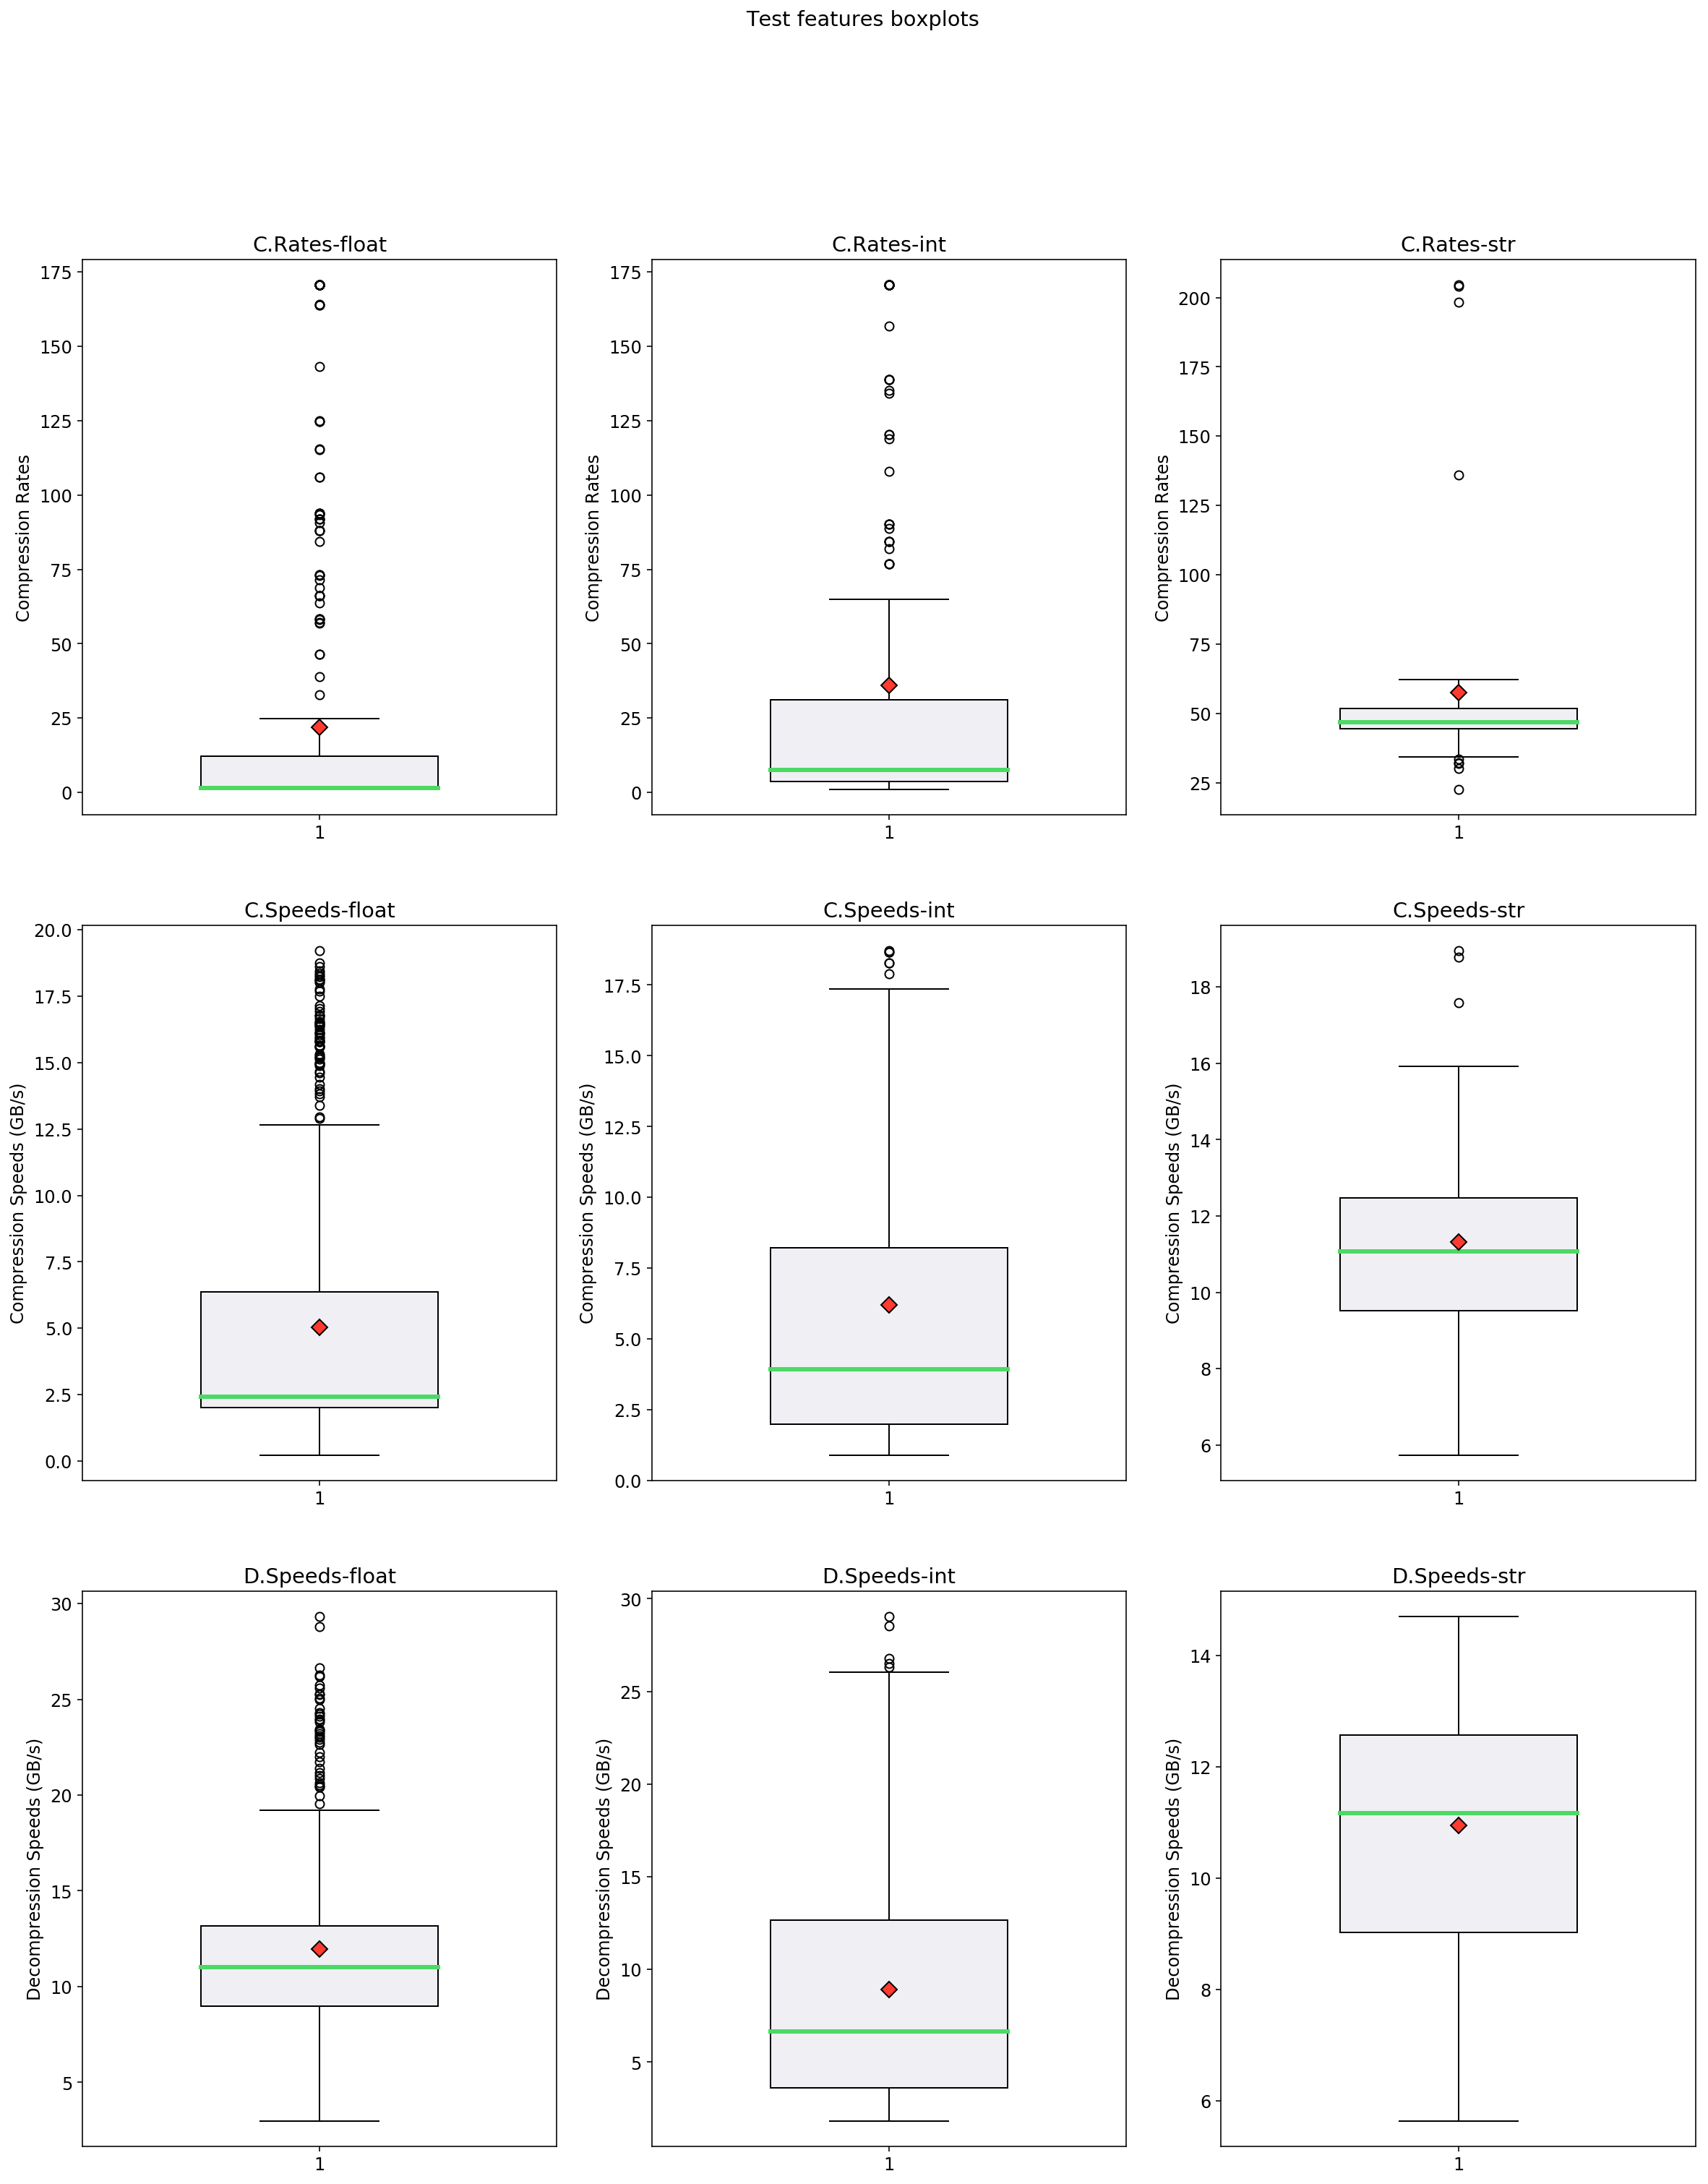

In [8]:
df_outliers = my_df[(my_df.Block_Size == 0) & (my_df.CL == 5) & (my_df.Codec == 'blosclz') & (my_df.Filter == 'noshuffle')]
cst.paint_dtype_boxplots(df_outliers)

Mostramos a continuación los datos atípicos

In [9]:
for i in range(2):
    dfaux = df_outliers[df_outliers.DType.str.contains(cst.TYPES[i])]
    if dfaux.size > 0:
        cr_lim = cst.outlier_lim(dfaux['CRate'])
        cs_lim = cst.outlier_lim(dfaux['CSpeed'])
        ds_lim = cst.outlier_lim(dfaux['DSpeed'])
        result = dfaux[(dfaux.CRate < cr_lim[0]) | (dfaux.CRate > cr_lim[1]) |
                      (dfaux.CSpeed < cs_lim[0]) | (dfaux.CSpeed > cs_lim[1]) |
                      (dfaux.DSpeed < ds_lim[0]) | (dfaux.DSpeed > ds_lim[1])][cst.ALL_FEATURES]
        if result.size > 0:
            print('%d %s OUTLIERS' % (result.shape[0], cst.TYPES[i].upper()))
            display(result)

71 FLOAT OUTLIERS


Chunk_Size   Mean  Median        Sd    Skew        Kurt     Min  \
84244         1.475  7.835   6.866     6.404   0.414       0.209 -12.035   
202504        2.215  0.650   0.000     2.098   4.997      32.385   0.000   
307804       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
309424       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
315904       16.000  0.020   0.000     0.301  26.479   1,032.815   0.000   
317524       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
319144       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
325624       16.000  0.001   0.000     0.041 108.763  21,889.348   0.000   
327244       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
328864       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
330484       10.656  0.000   0.000     0.000   0.000      -3.000   0.000   
336964       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
338584       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
345064       16.000  0.012   0.000     0.220  27.880   1,090.685   0.000   
346684       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
348304       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
354784       16.000  0.001   0.000     0.041 135.611  45,023.028   0.000   
356404       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
358024       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
359644       10.656  0.000   0.000     0.000   0.000      -3.000   0.000   
395284       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
396904       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
403384       16.000  0.003   0.000     0.047  23.164     799.779   0.000   
405004       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
406624       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
413104       16.000  0.000   0.000     0.009  94.256  16,687.977   0.000   
414724       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
416344       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
417964       10.656  0.000   0.000     0.000   0.000      -3.000   0.000   
424444       16.000  0.000   0.000     0.000   0.000      -3.000   0.000   
...             ...    ...     ...       ...     ...         ...     ...   
505444       10.656  0.001   0.000     0.020  31.921   1,046.805   0.000   
513544       16.000  0.000   0.000     0.005  36.416   1,874.125   0.000   
523264       16.000  0.000   0.000     0.006  35.745   2,060.796   0.000   
532984       16.000  0.000   0.000     0.006  32.862   1,758.761   0.000   
534604       10.656  0.000   0.000     0.001 245.611  72,752.224   0.000   
571864       16.000  0.046   0.000     0.602  13.027     168.189   0.000   
581584       16.000  0.037   0.000     0.548  14.787     217.128   0.000   
591304       16.000  0.104   0.000     0.898   8.499      70.373   0.000   
592924       10.656  0.024   0.000     0.430  18.154     327.643   0.000   
601024       16.000  0.001   0.000     0.018  29.018     991.612   0.000   
610744       16.000  0.001   0.000     0.017  31.752   1,158.950   0.000   
620464       16.000  0.001   0.000     0.019  26.873     853.465   0.000   
622084       10.656  0.000   0.000     0.002 134.109  30,370.566   0.000   
659344       16.000  0.007   0.000     0.137  75.209  15,562.234   0.000   
669064       16.000  0.012   0.000     0.318 165.356  85,613.265   0.000   
678784       16.000  0.013   0.000     0.254  63.531   9,977.393   0.000   
680404       10.656  0.001   0.000     0.080 199.003  66,273.386   0.000   
688504       16.000  0.002   0.000     0.069 352.831 235,551.444   0.000   
698224       16.000  0.005   0.000     0.206 113.694  29,804.922   0.000   
707944       16.000  0.005   0.000     0.186 123.599  39,095.443   0.000   
709564       10.656  0.000   0.000     0.011 497.825 316,

37 INT OUTLIERS


Chunk_Size       Mean     Median         Sd   Skew       Kurt    Min  \
150664        0.738 46,750.635 42,412.000 42,964.463  1.123      2.123  0.000   
199264        2.445      0.000      0.000      0.027 99.485 18,684.148  0.000   
212224        2.445      0.002      0.000      0.055 50.616  3,993.813  0.000   
231664       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
251104        2.445      0.001      0.000      0.045 47.237  3,683.632  0.000   
278644       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
280264       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
288364       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
289984       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
296464       16.000      0.017      0.000      0.468 41.152  2,111.449  0.000   
298084       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
299704       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
301324       10.656      0.000      0.000      0.000  0.000     -3.000  0.000   
366124       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
367744       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
375844       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
377464       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
383944       16.000      0.017      0.000      0.468 41.147  2,110.792  0.000   
385564       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
387184       16.000      0.000      0.000      0.000  0.000     -3.000  0.000   
388804       10.656      0.000      0.000      0.000  0.000     -3.000  0.000   
455224       16.000      0.019      0.000      0.411 38.029  1,880.823  0.000   
464944       16.000      0.014      0.000      0.314 37.427  1,912.485  0.000   
474664       16.000      0.019      0.000      0.386 36.527  1,832.705  0.000   
476284       10.656      0.001      0.000      0.042 57.967  6,928.863  0.000   
542704       16.000      0.020      0.000      0.417 37.539  1,836.680  0.000   
552424       16.000      0.014      0.000      0.316 37.139  1,884.219  0.000   
563764       10.656      0.004      0.000      0.078 30.801  1,542.716  0.000   
630184       16.000      0.019      0.000      0.412 38.020  1,880.003  0.000   
639904       16.000      0.014      0.000      0.314 37.406  1,910.042  0.000   
649624       16.000      0.019      0.000      0.386 36.518  1,831.651  0.000   
651244       10.656      0.001      0.000      0.042 57.967  6,928.863  0.000   
717664       16.000      0.019      0.000      0.411 38.027  1,880.604  0.000   
727384       16.000      0.014      0.000      0.309 37.074  1,887.380  0.000   
737104       16.000      0.019      0.000      0.382 36.250  1,814.581  0.000   
738724       10.656      0.001      0.000      0.042 57.993  6,934.303  0.000   
1010884       5.087     -4.000     -4.000      0.000  0.000     -3.000 -4.000   

                Max      Q1         Q3   CRate  CSpeed  DSpeed  
150664  211,383.000 121.000 79,434.750   1.000   0.901  26.761  
199264        8.000   0.000      0.000 156.816   9.576  22.110  
212224        8.000   0.000      0.000 134.316   9.476  16.129  
231664        0.000   0.000      0.000 170.639  18.661  29.037  
251104        7.000   0.000      0.000 135.187   9.414  23.567  
278644        0.000   0.000      0.000 170.639  18.661  25.934  
280264        0.000   0.000      0.000 170.639  17.896  24.426  
288364        0.000   0.000      0.000 170.639  18.276  26.037  
289984        0.000   0.000      0.000 170.639  16.596  26.309  
296464       63.000   0.000      0.000 120.436  13.216  20.252  
298084        0.000   0.000      0.000 170.639  17.351  24.121  
299704        0.000   0.000      0.000 170.639  18.709  26.511  
301324        0.000   0.000      0.000 170.625  13.999  24.927  
366124        0.000 

No mostramos los datos atípicos de tipo string dado que no extraemos ninguna característica de chunk que podamos comentar, nos centraremos en ellos cuando busquemos correlaciones entre blosclz y el resto de codecs.  
En cuanto a los datos atípicos observamos que la mayoría son series números idénticos o muy parecidos, siempre con un rango intercuartílico de 0.

## Correlaciones Block Size
Aquí pretendemos observar la correlación entre el tamaño de bloque y las medidas de compresión, para ello filtramos los datos por tipo, codec, filtro, nivel de compresión y tamaño de bloque; y calculamos la media de su ratio de compresión y velocidades de compresión/decompresión.


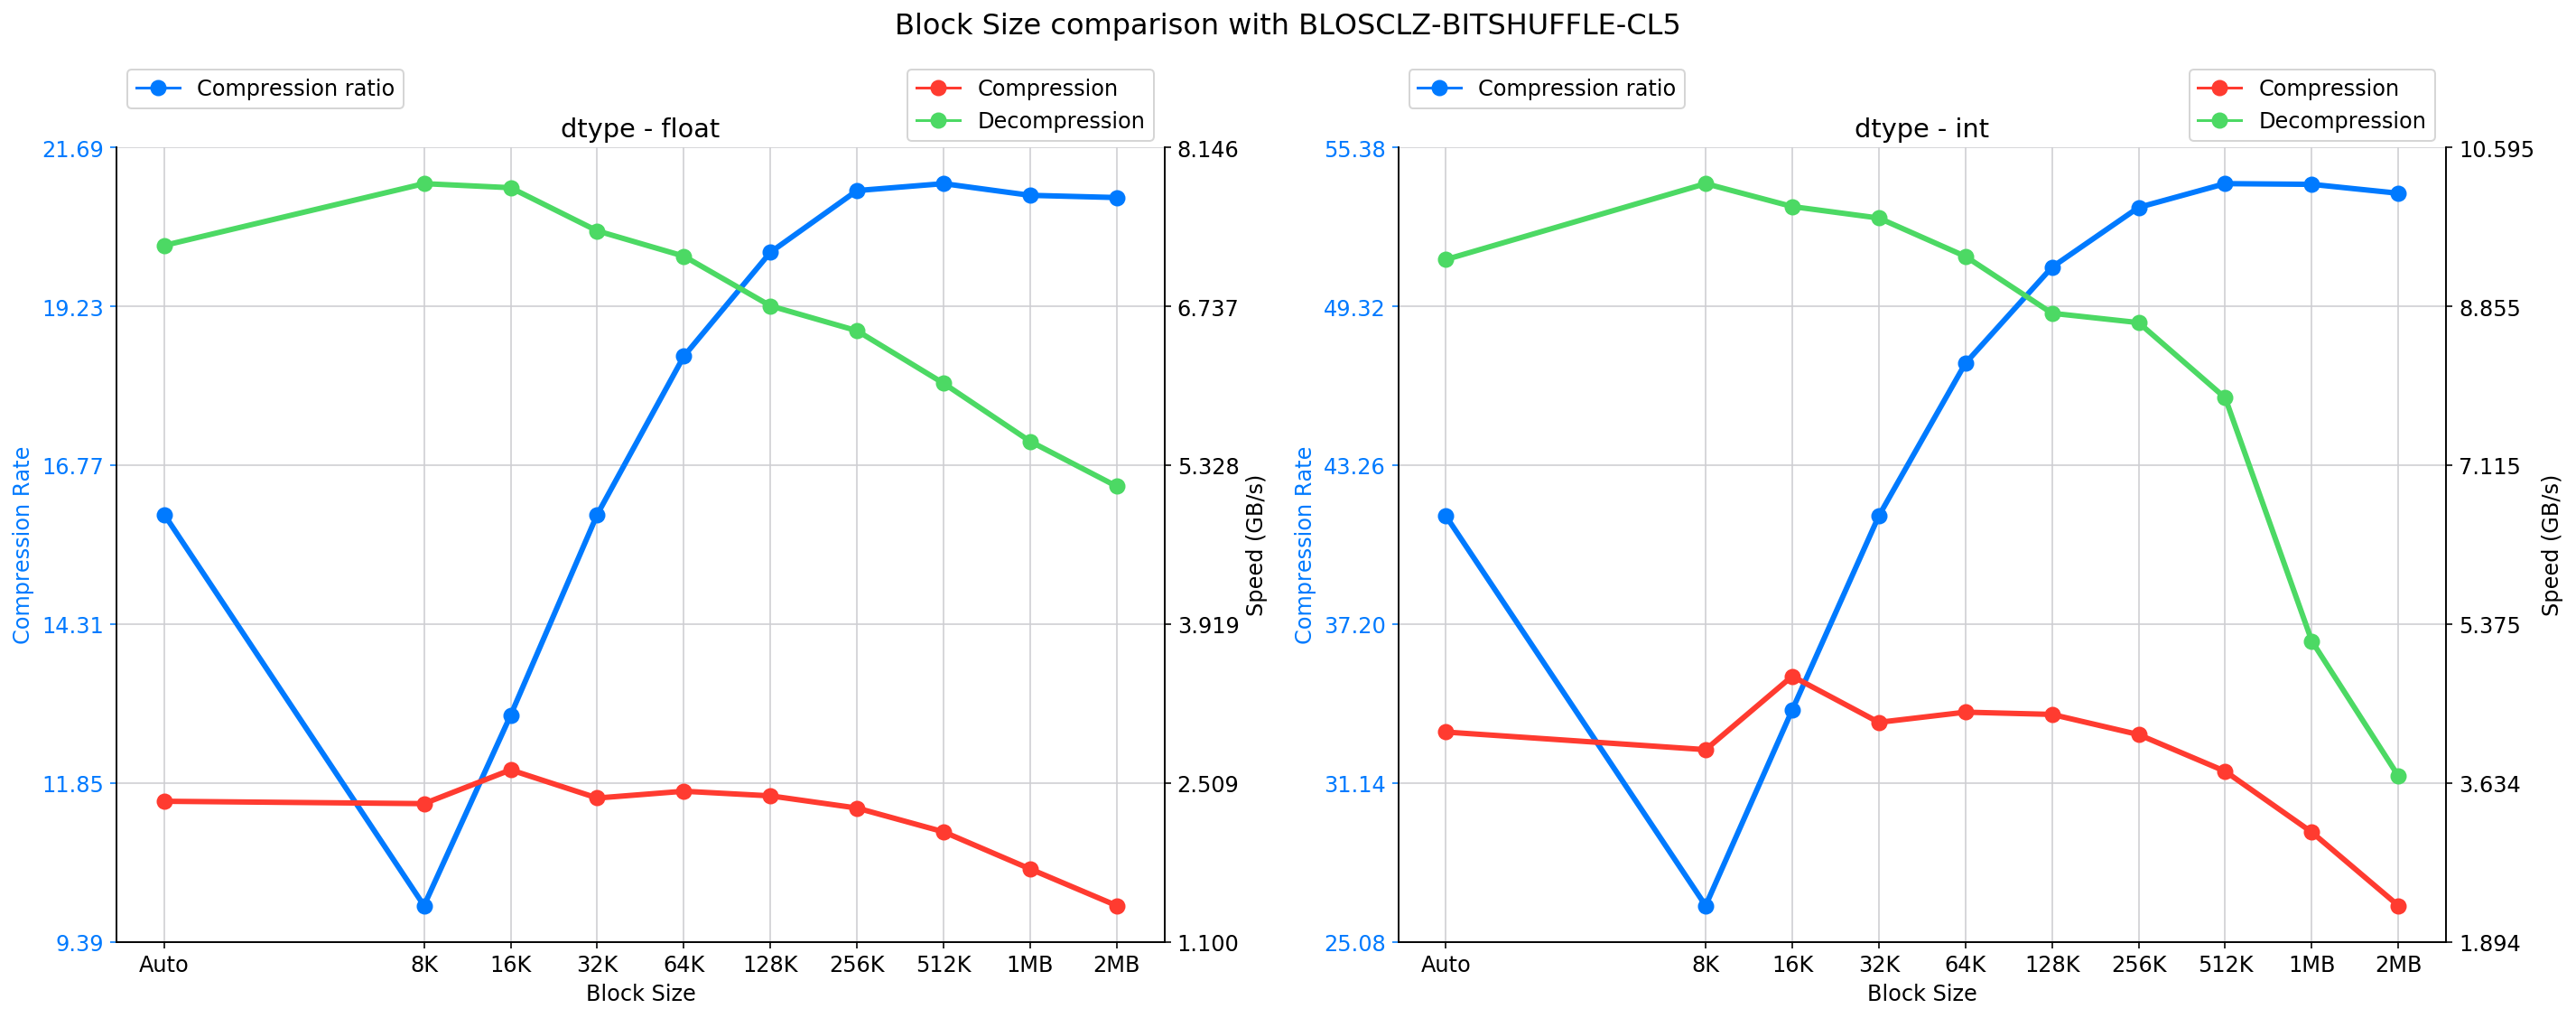

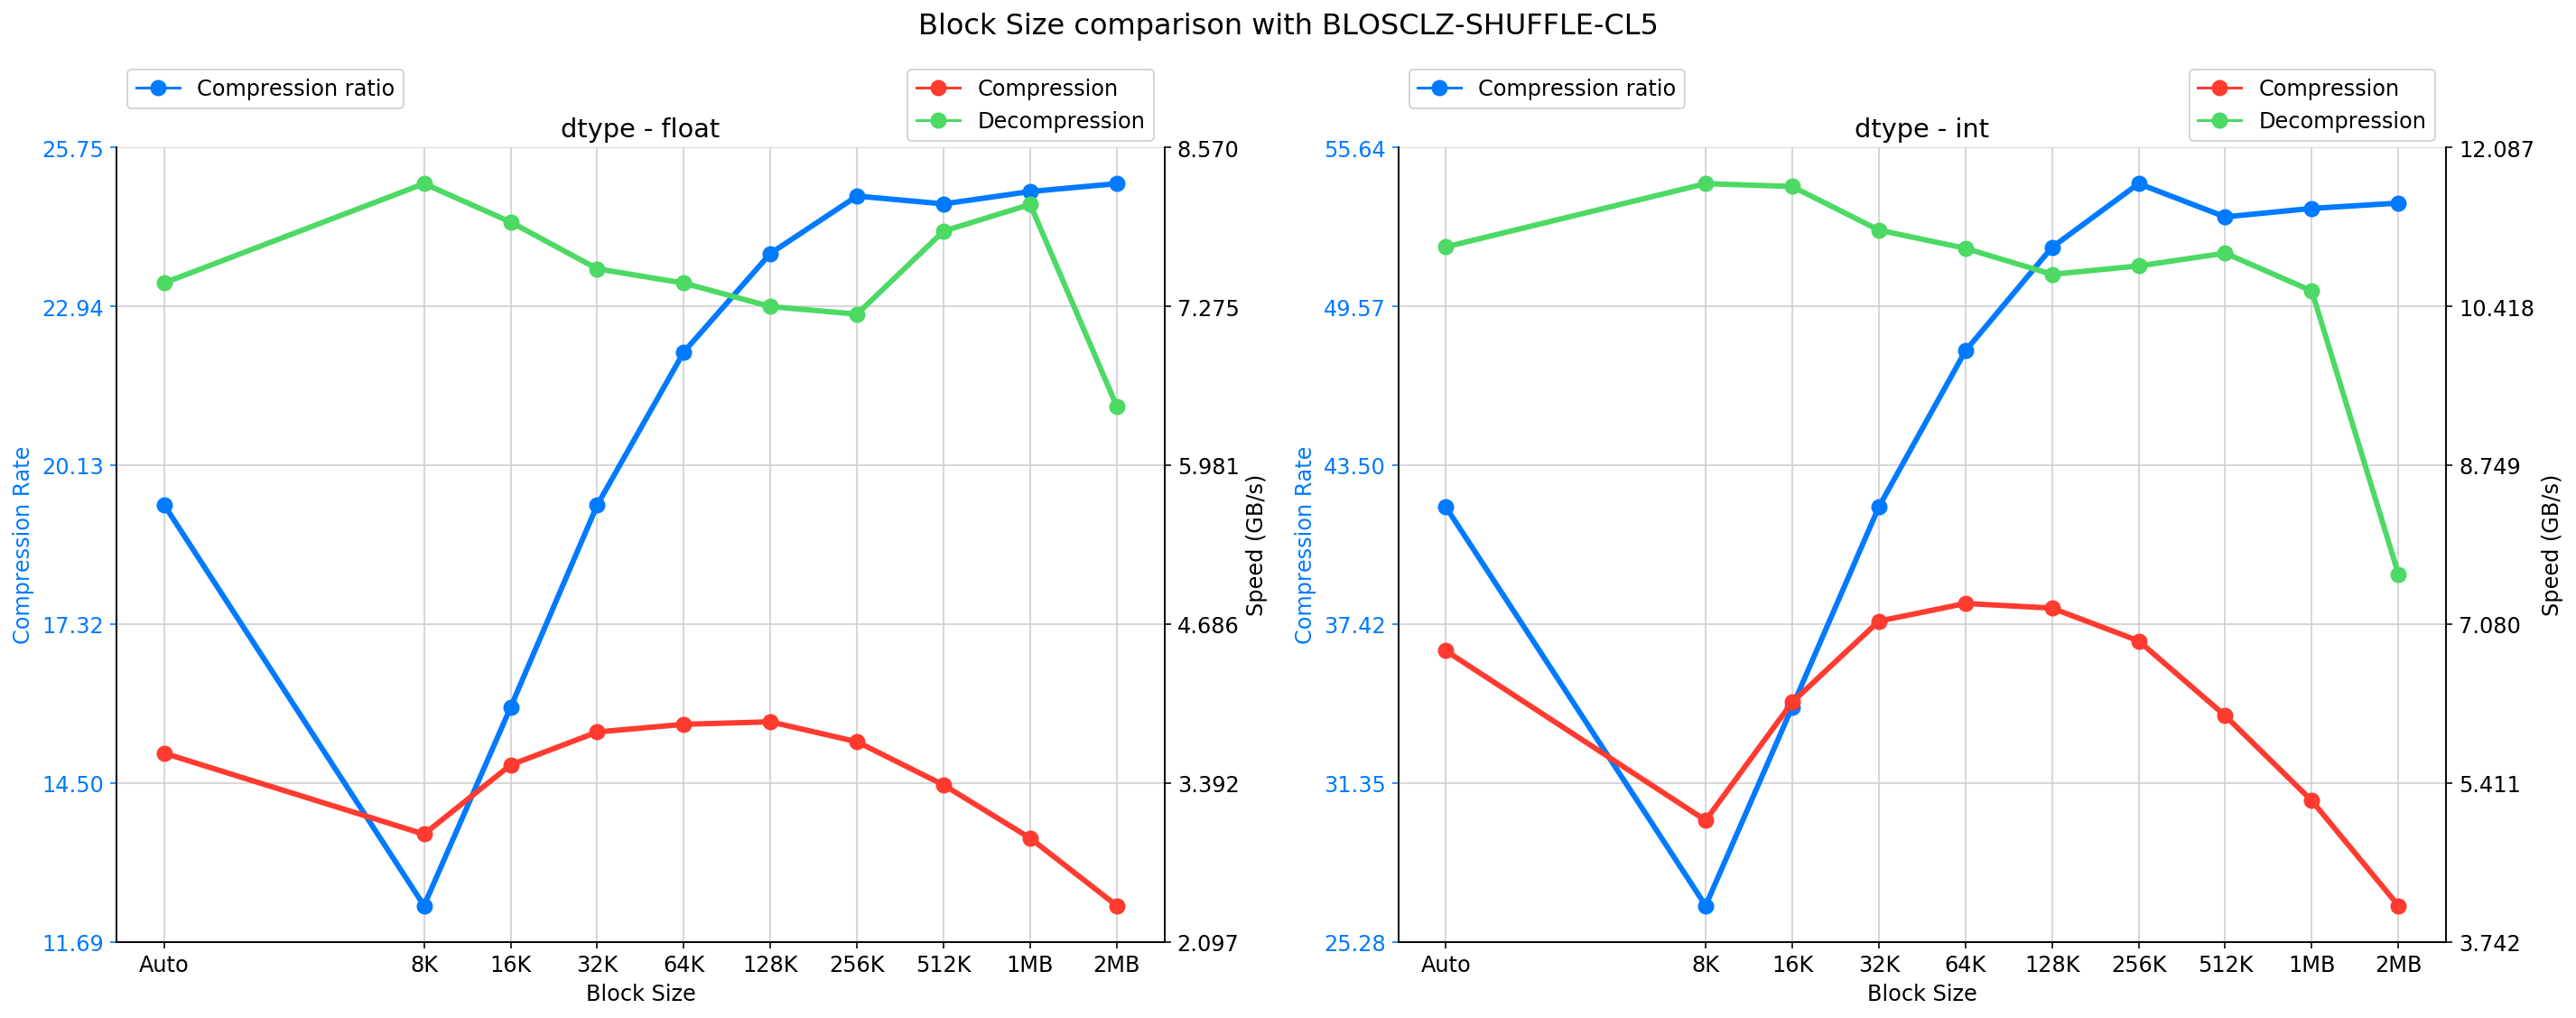

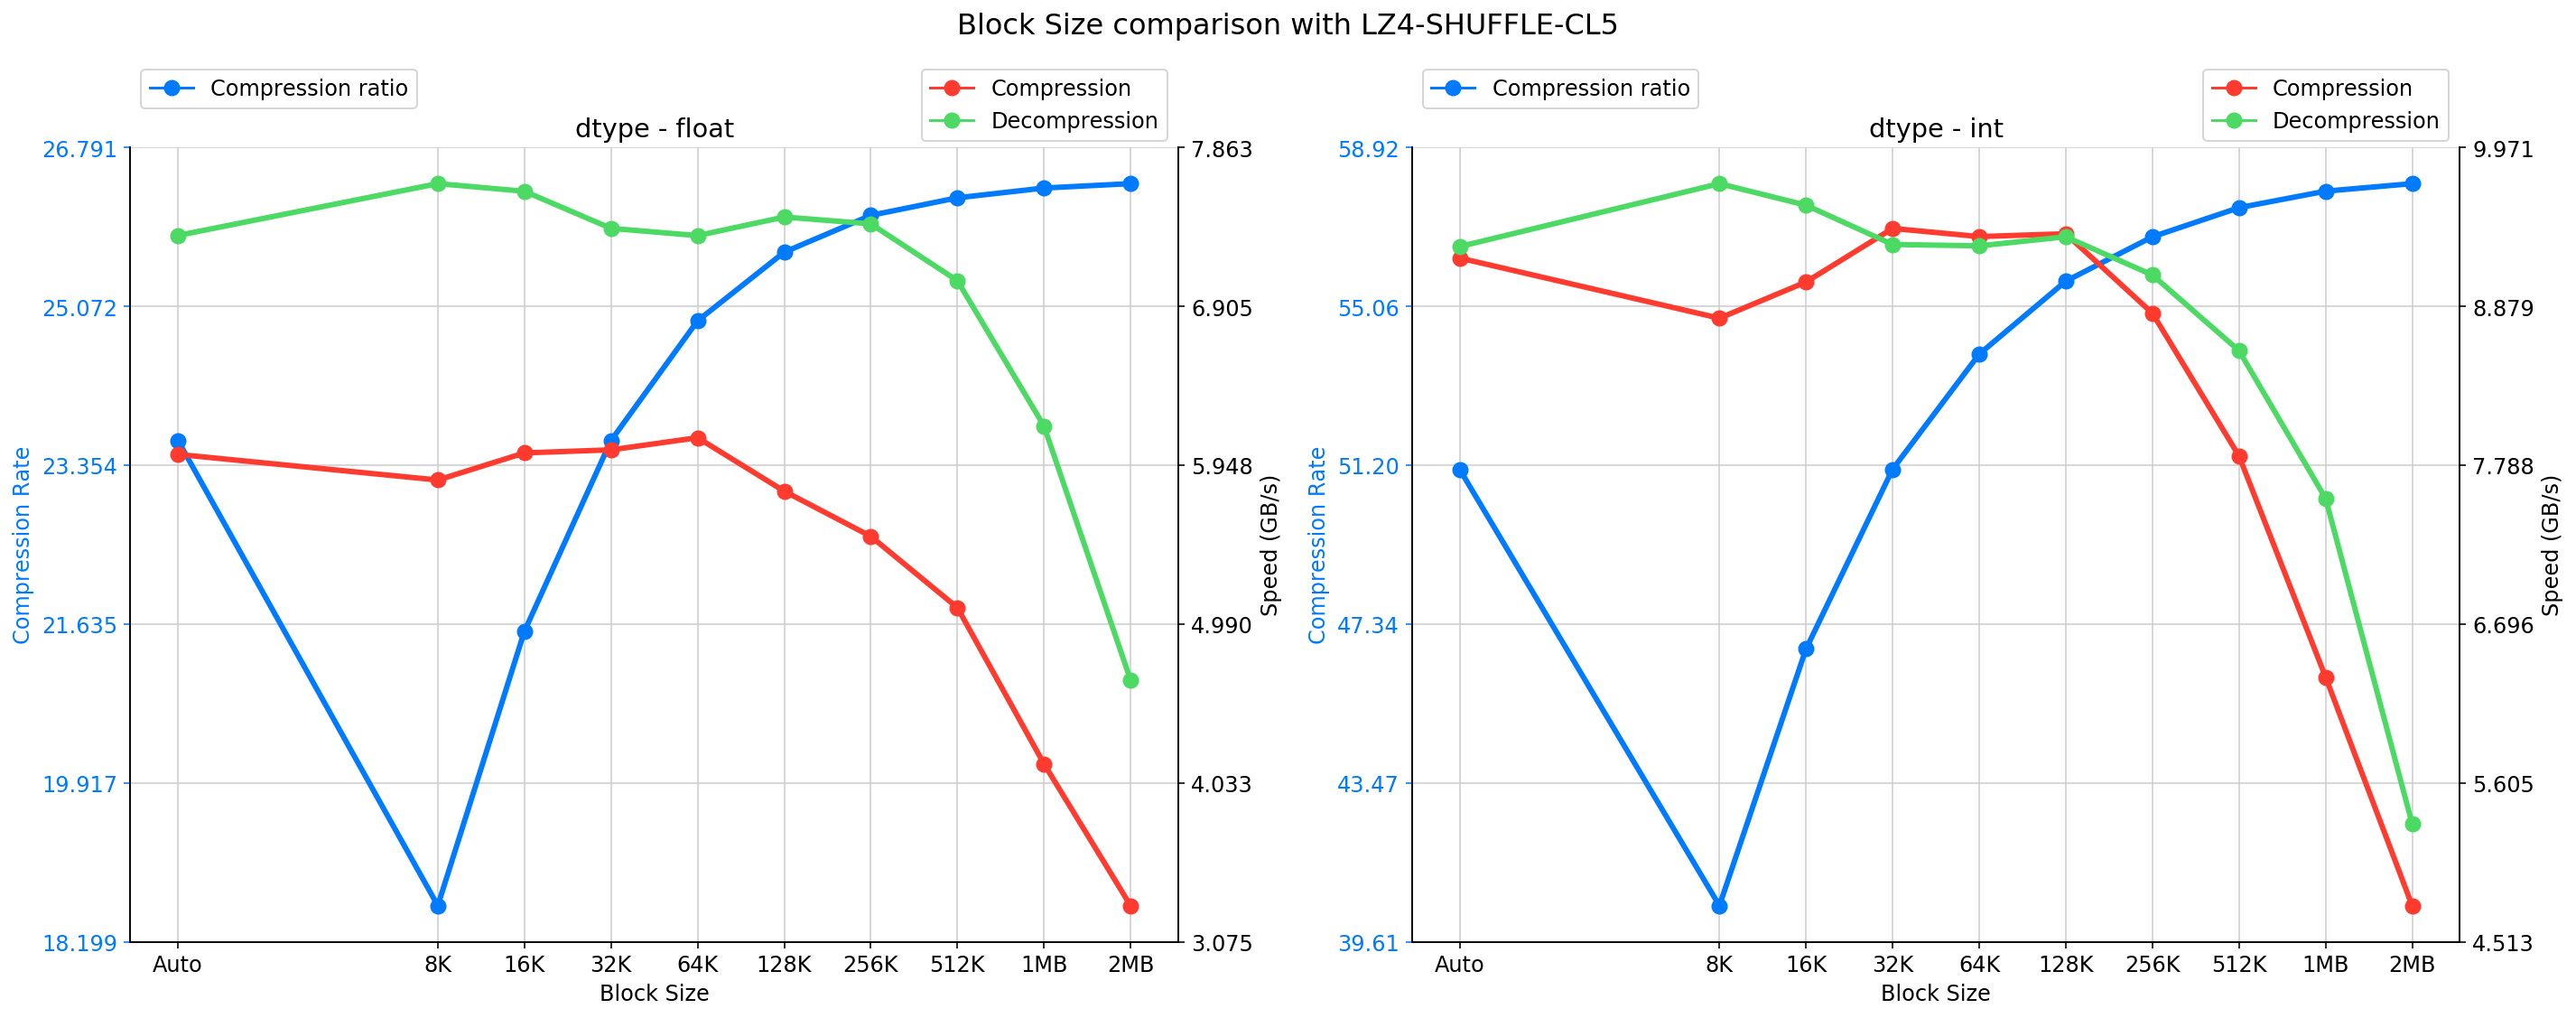

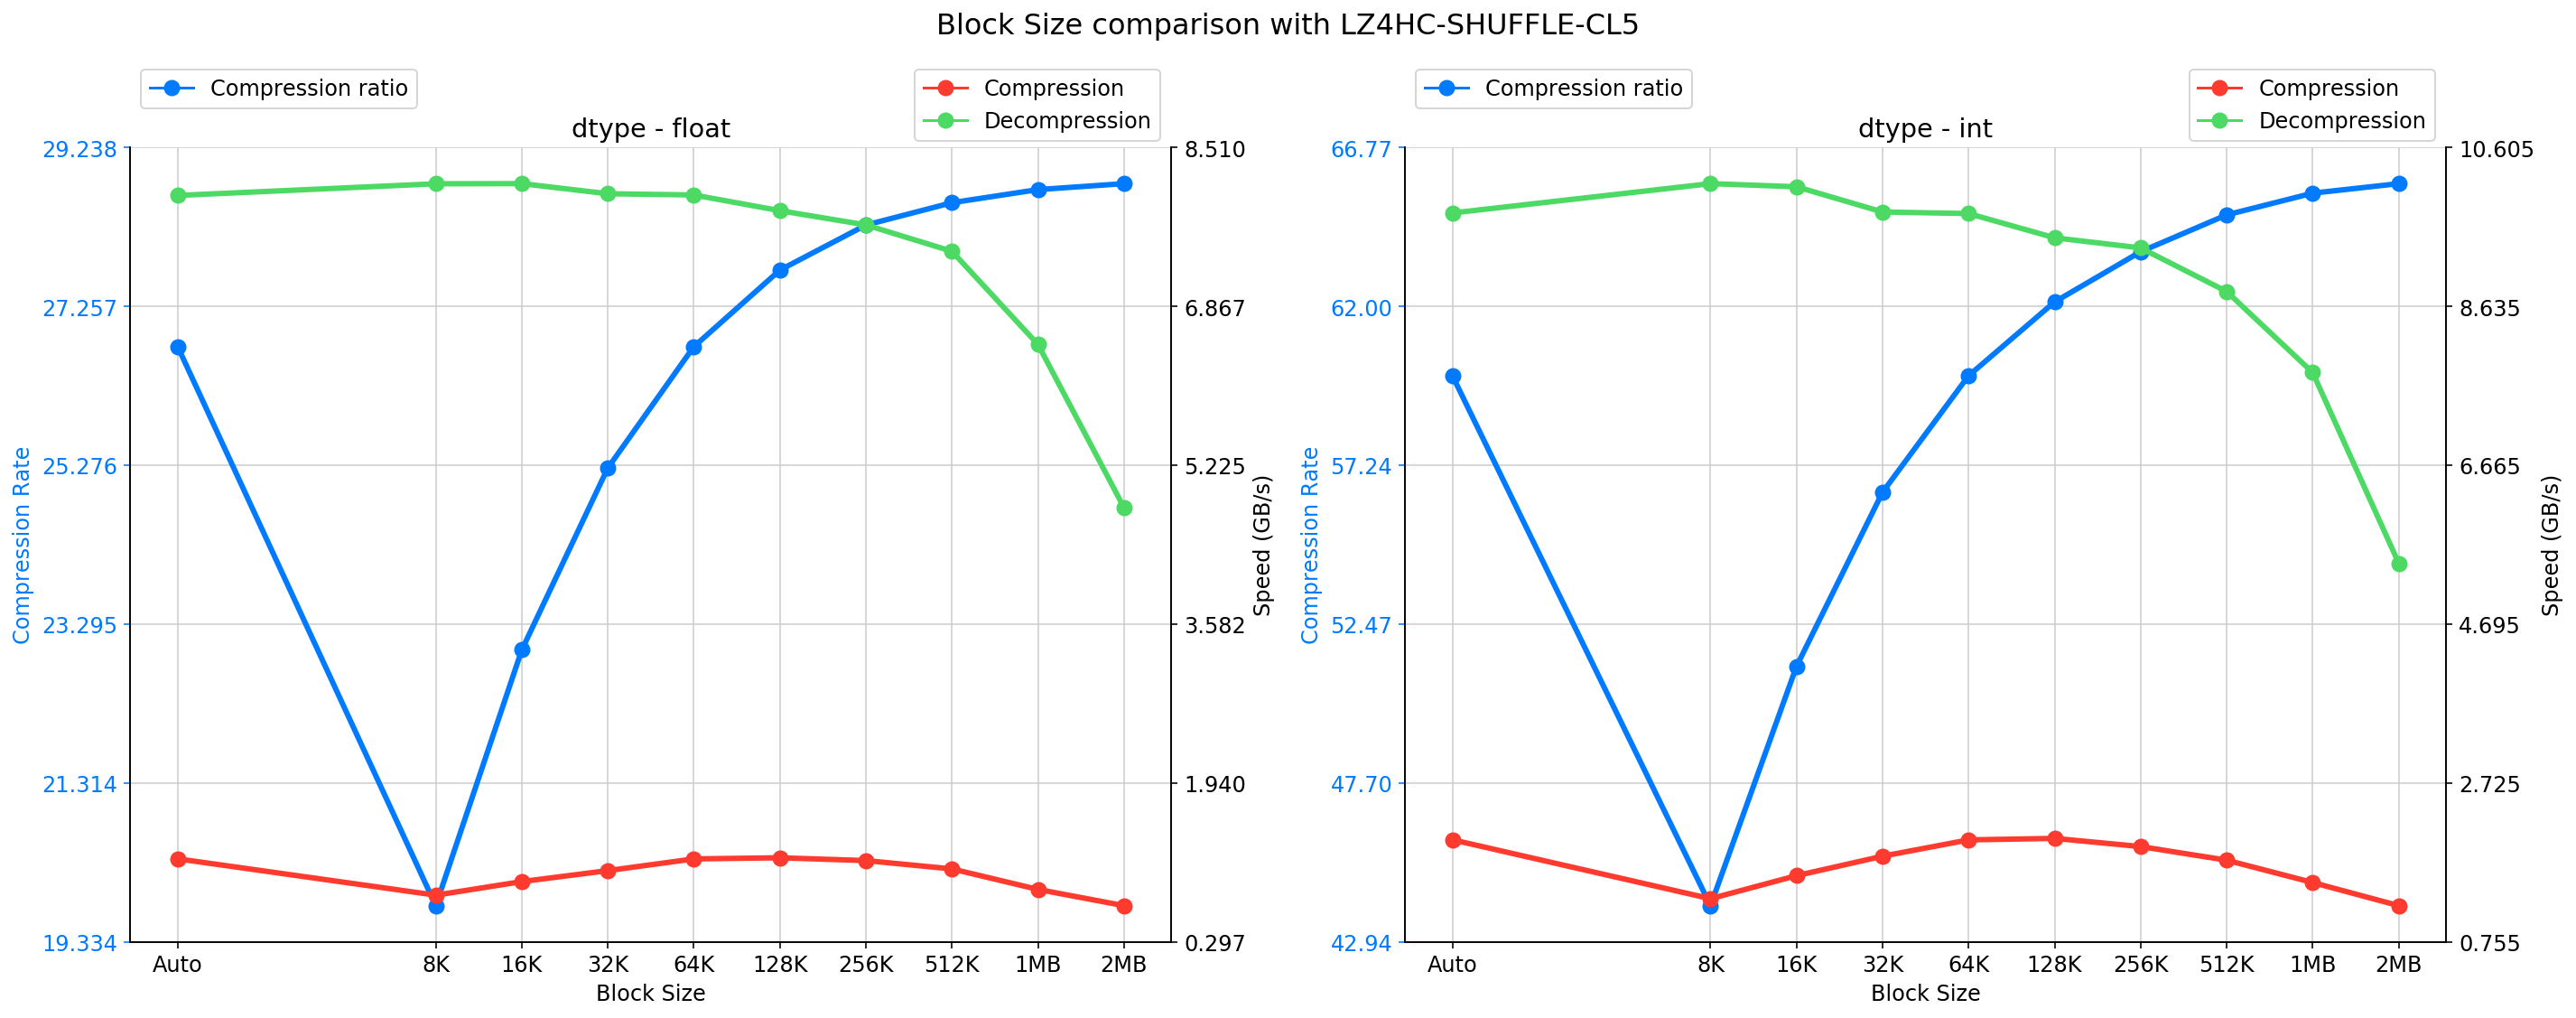

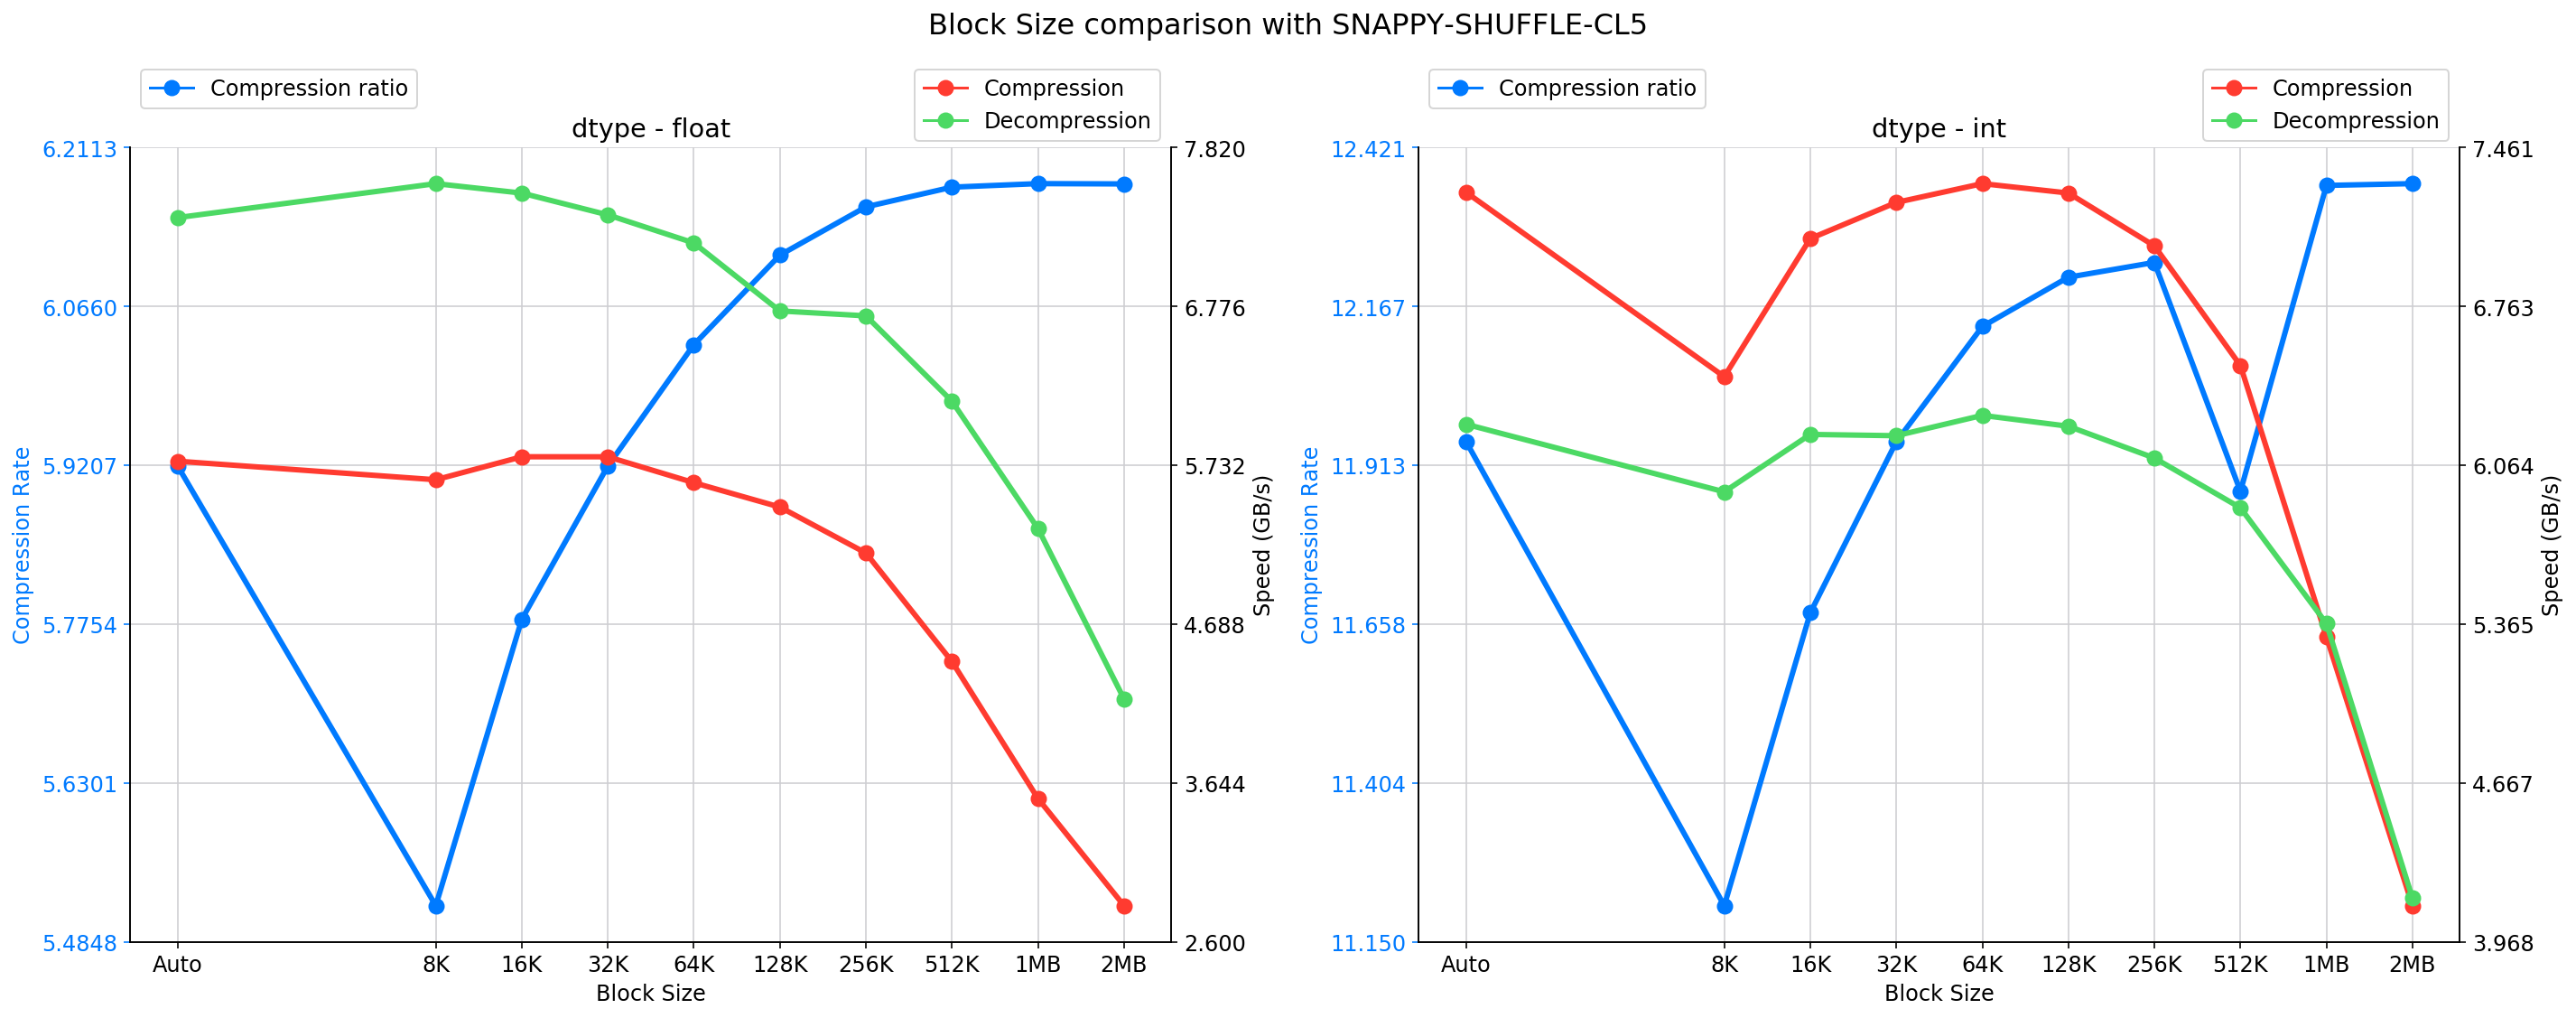

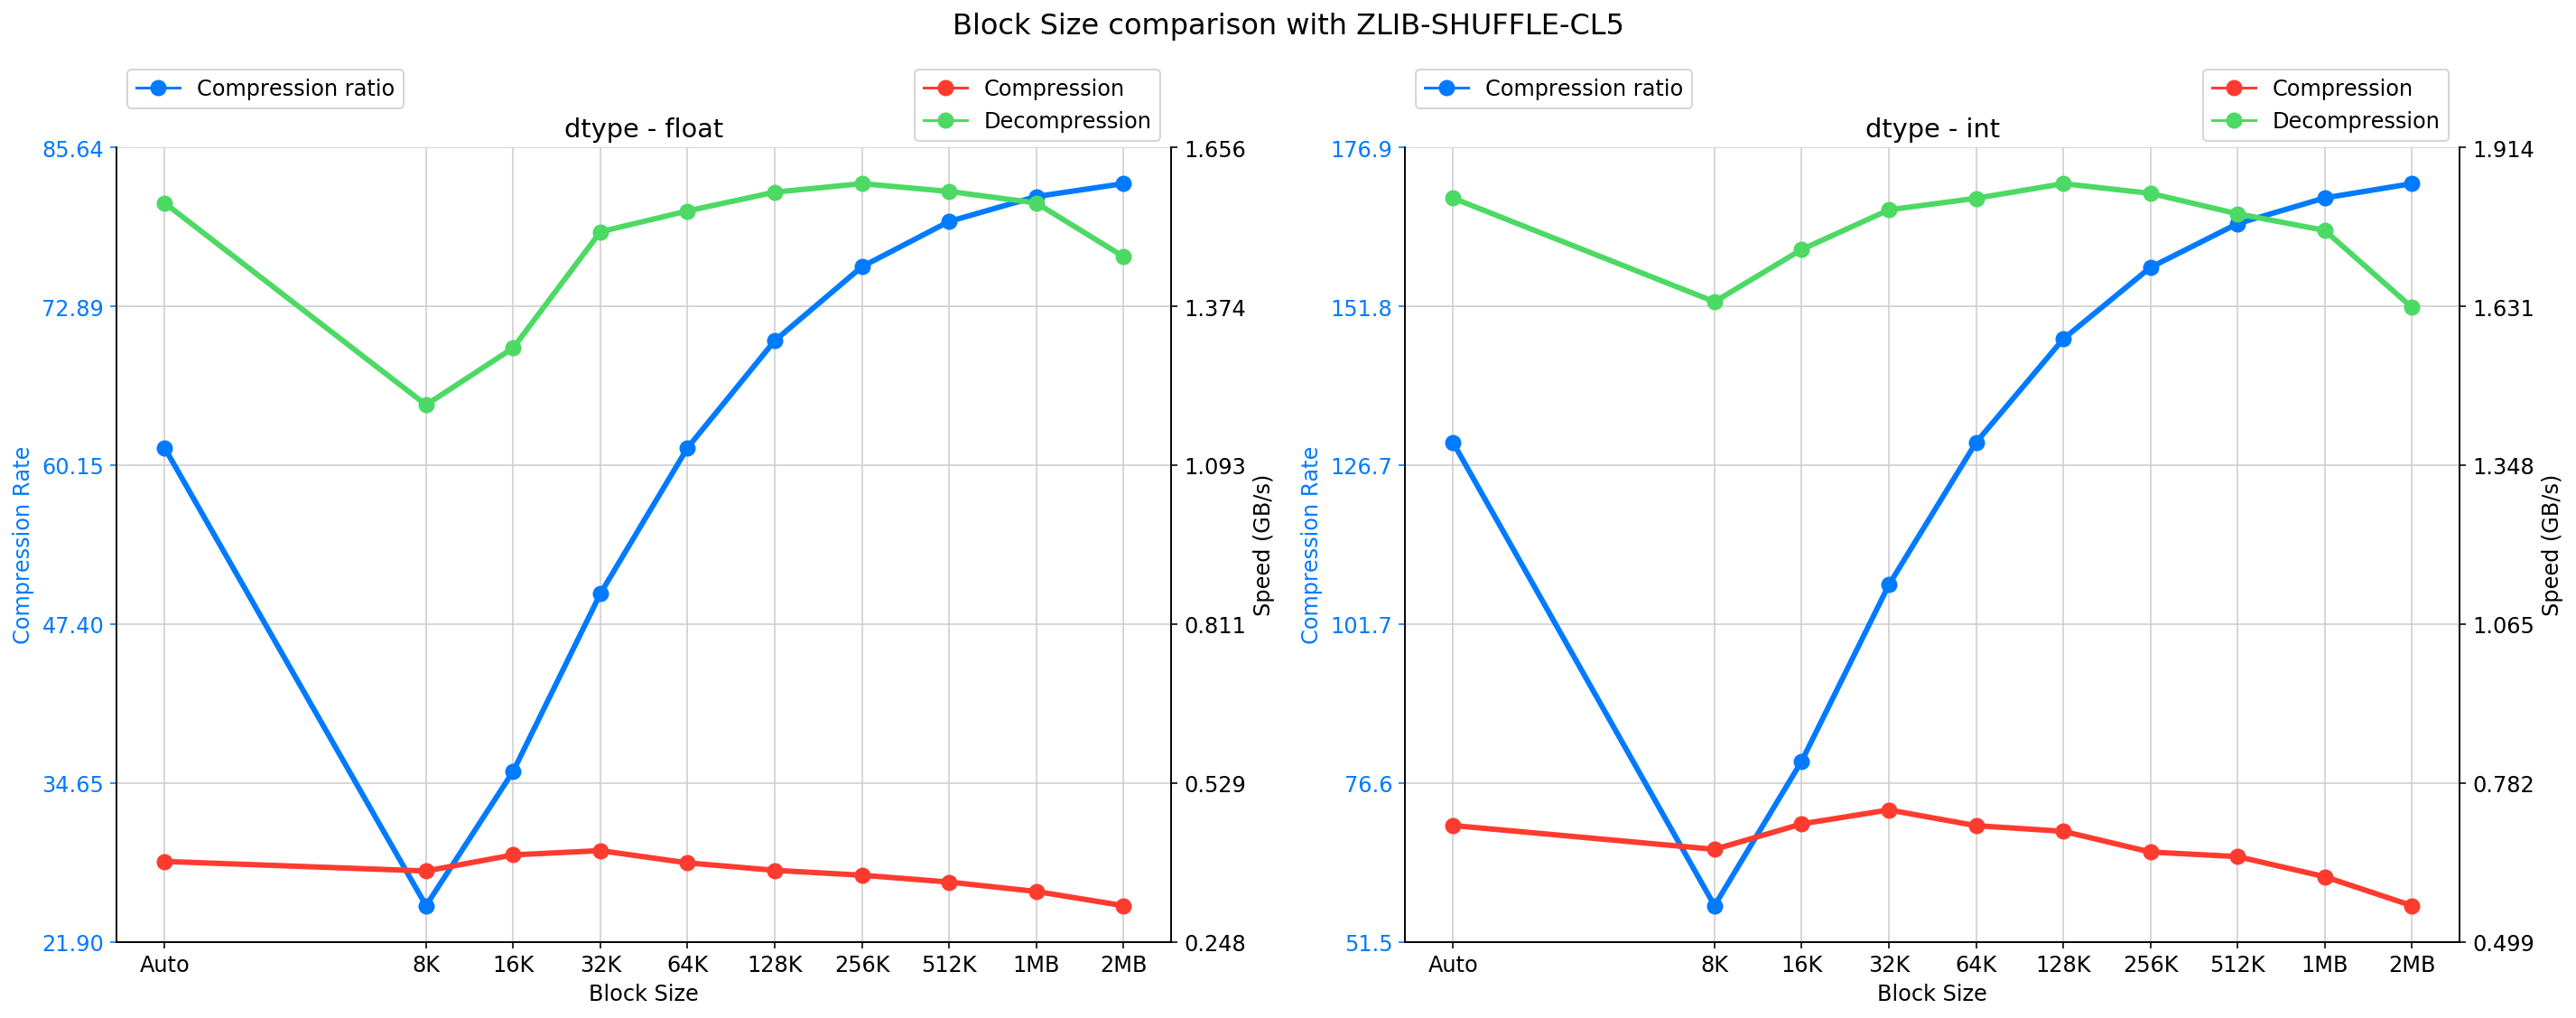

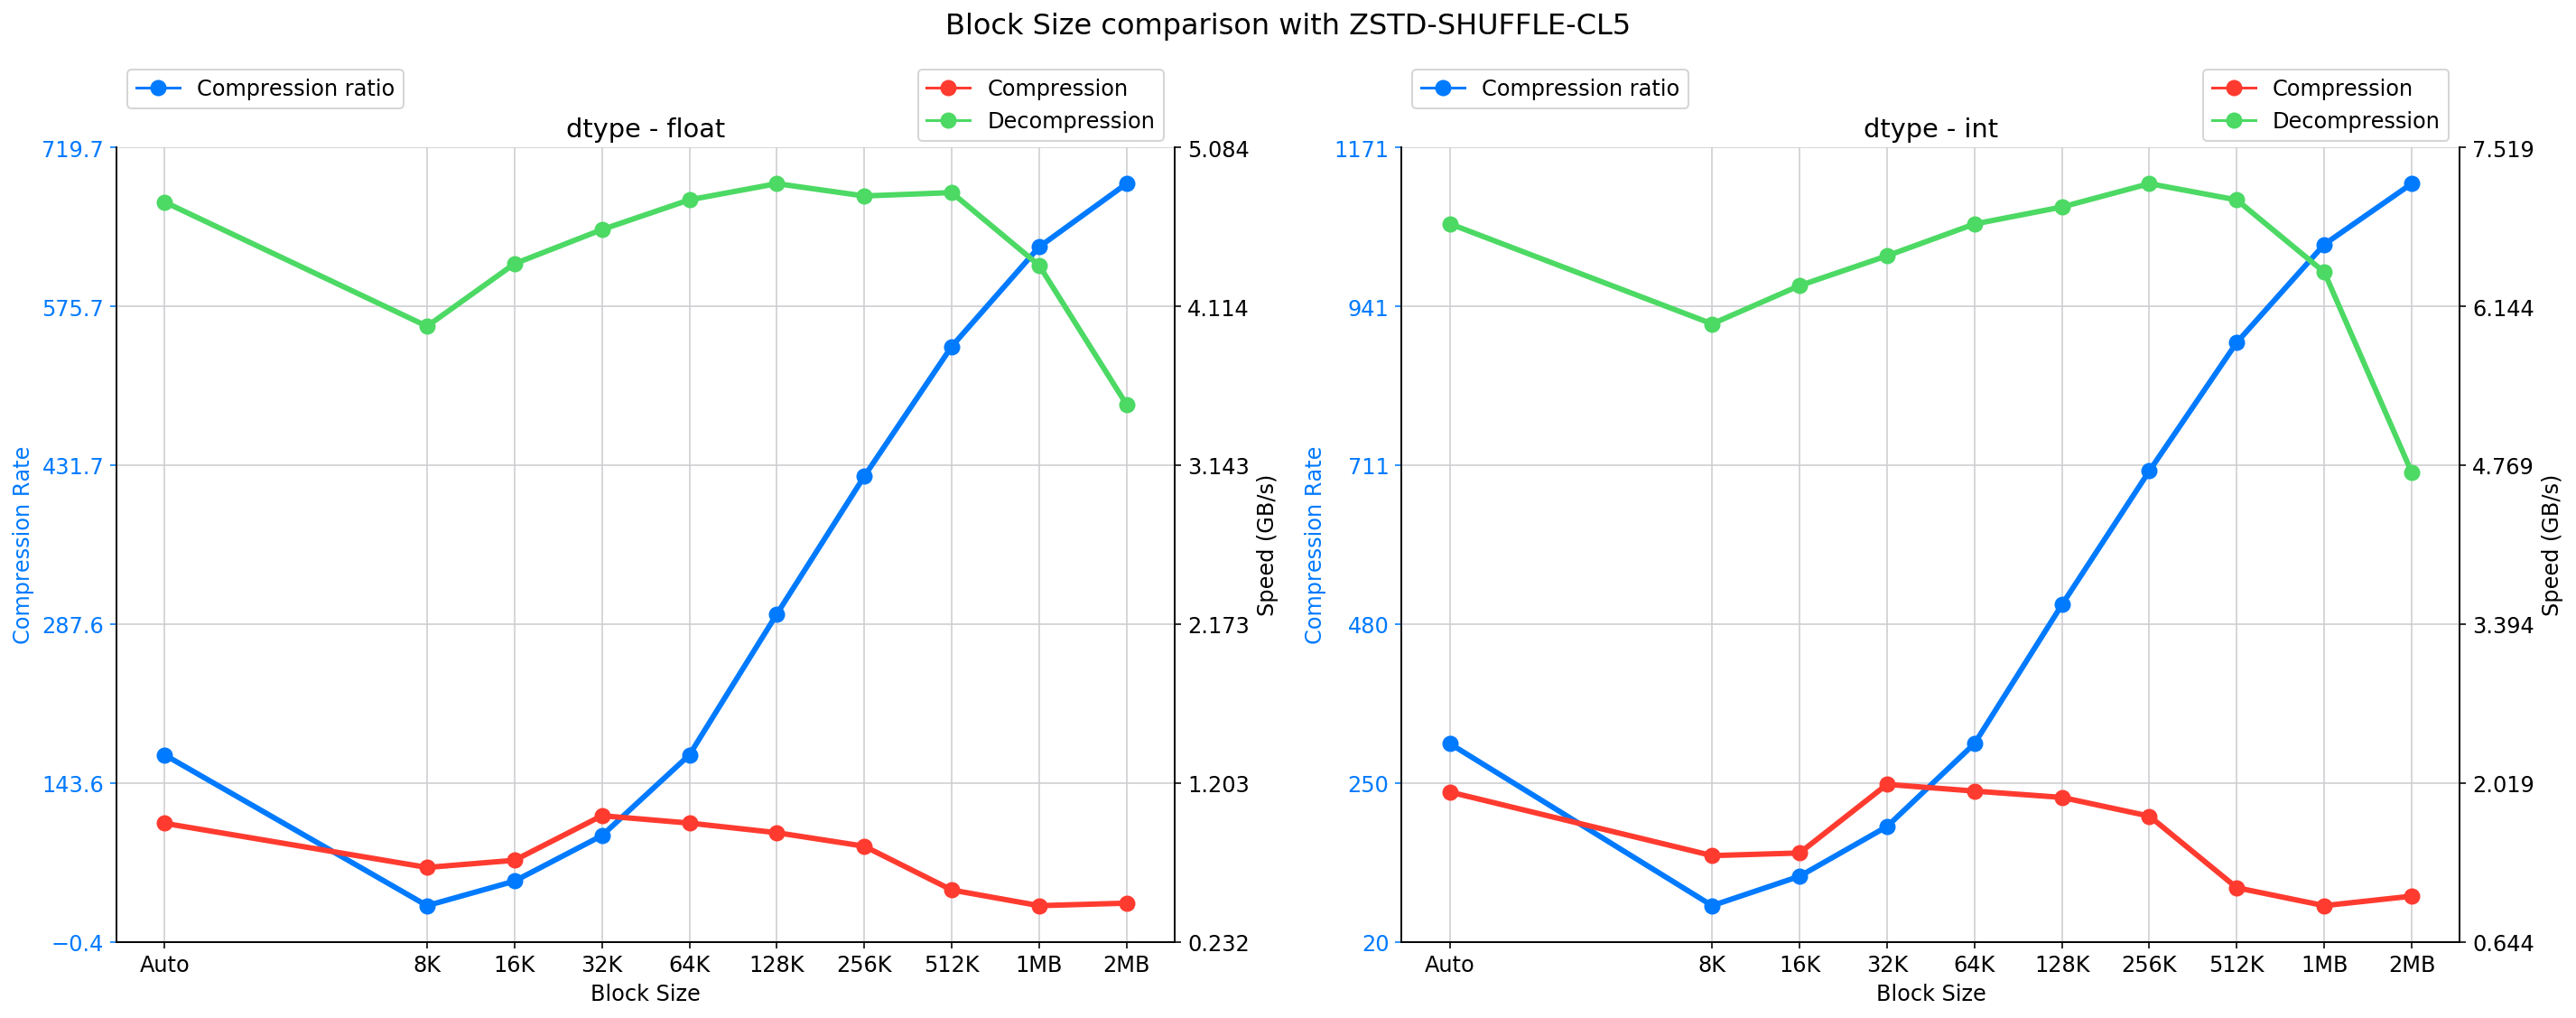

In [10]:
cst.paint_all_block_cor(my_df, 'shuffle', c_level=5)

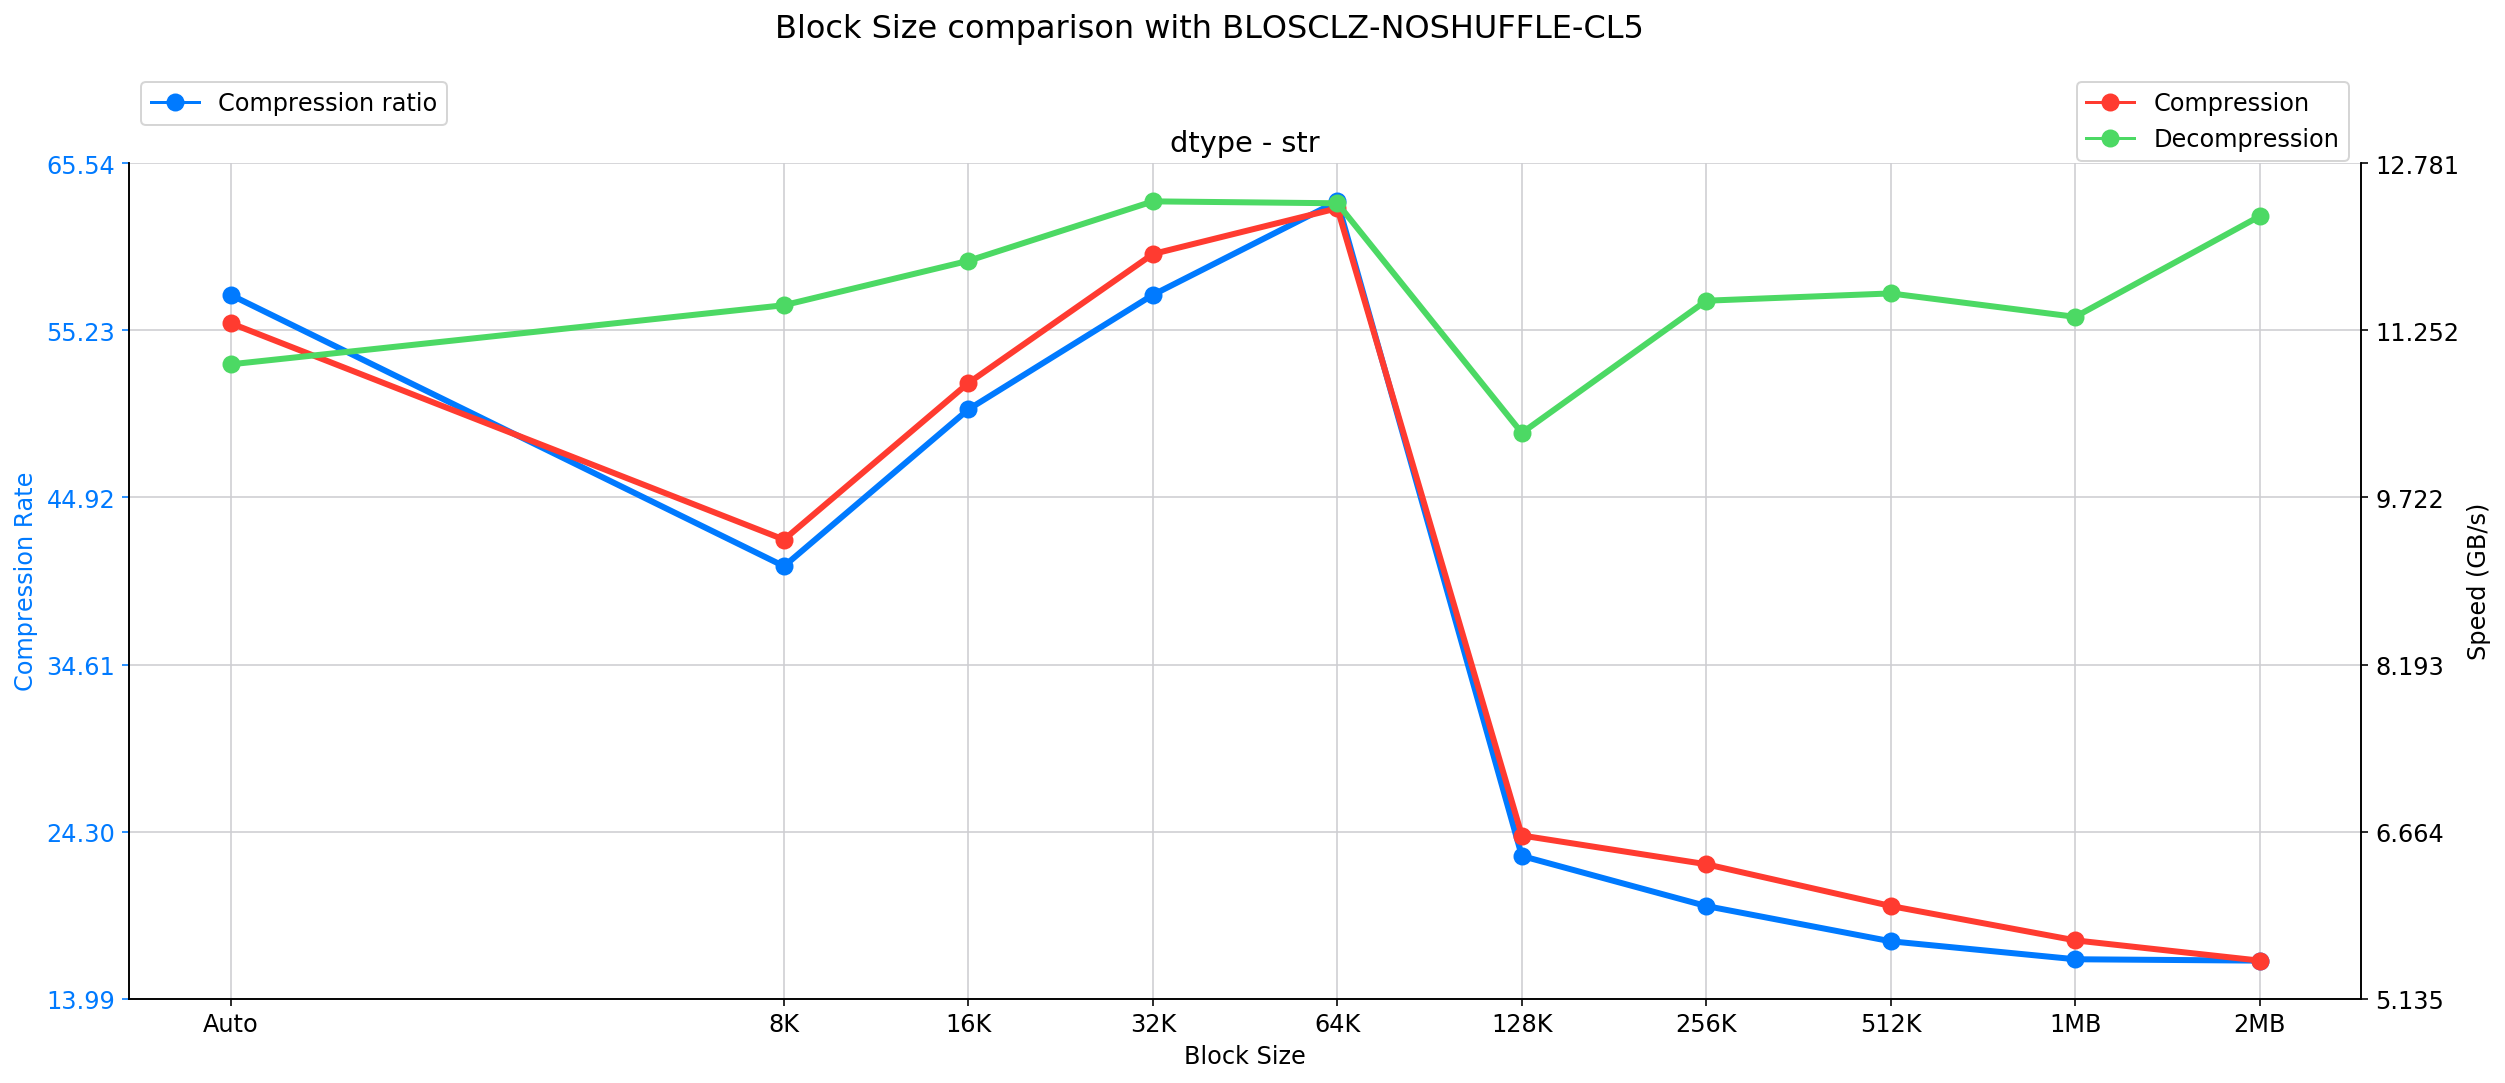

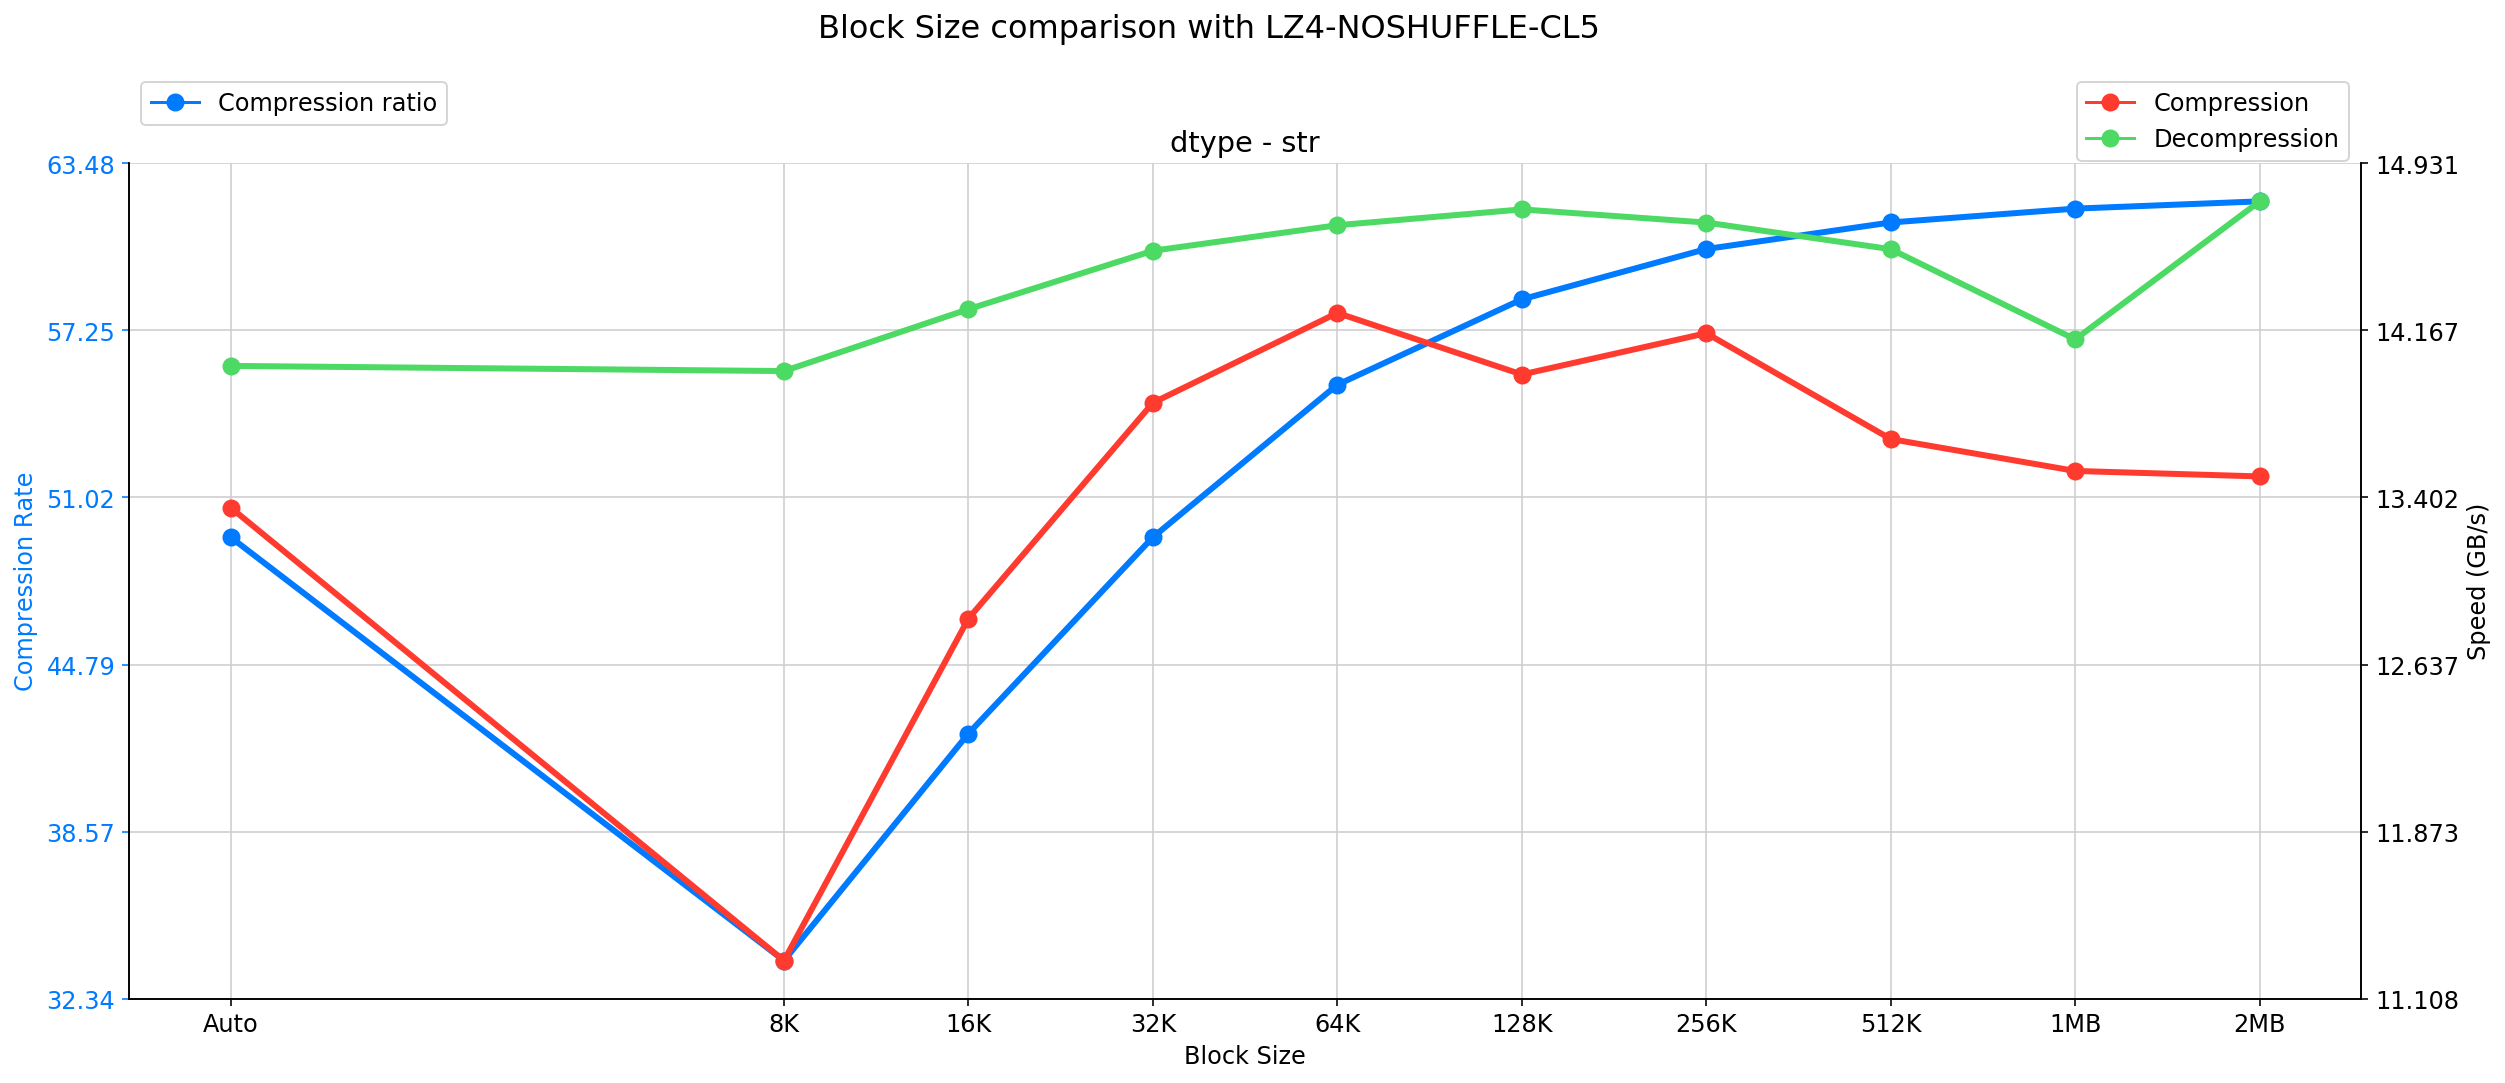

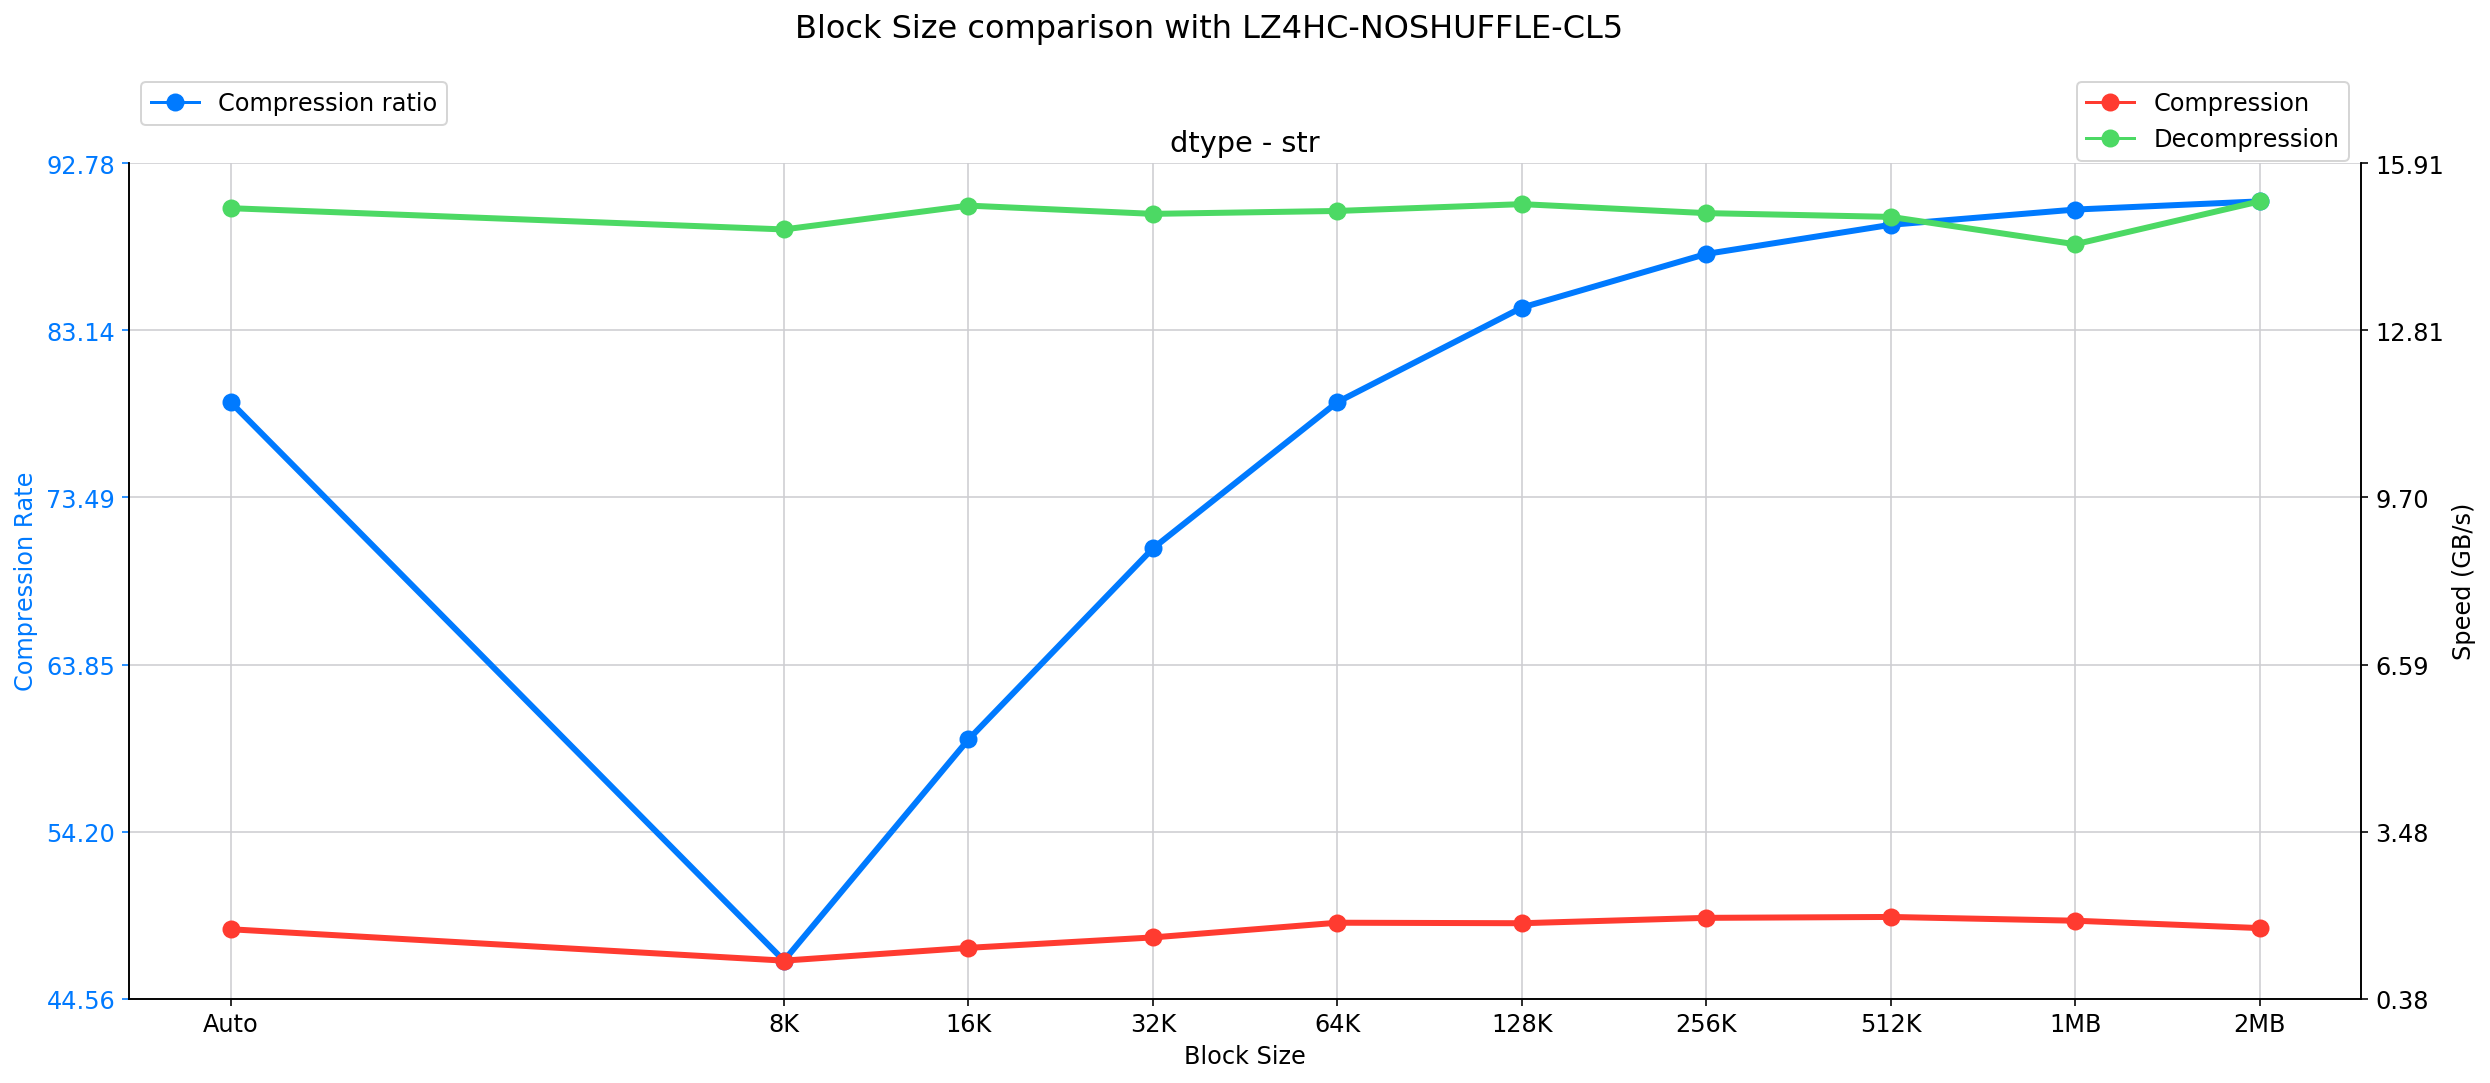

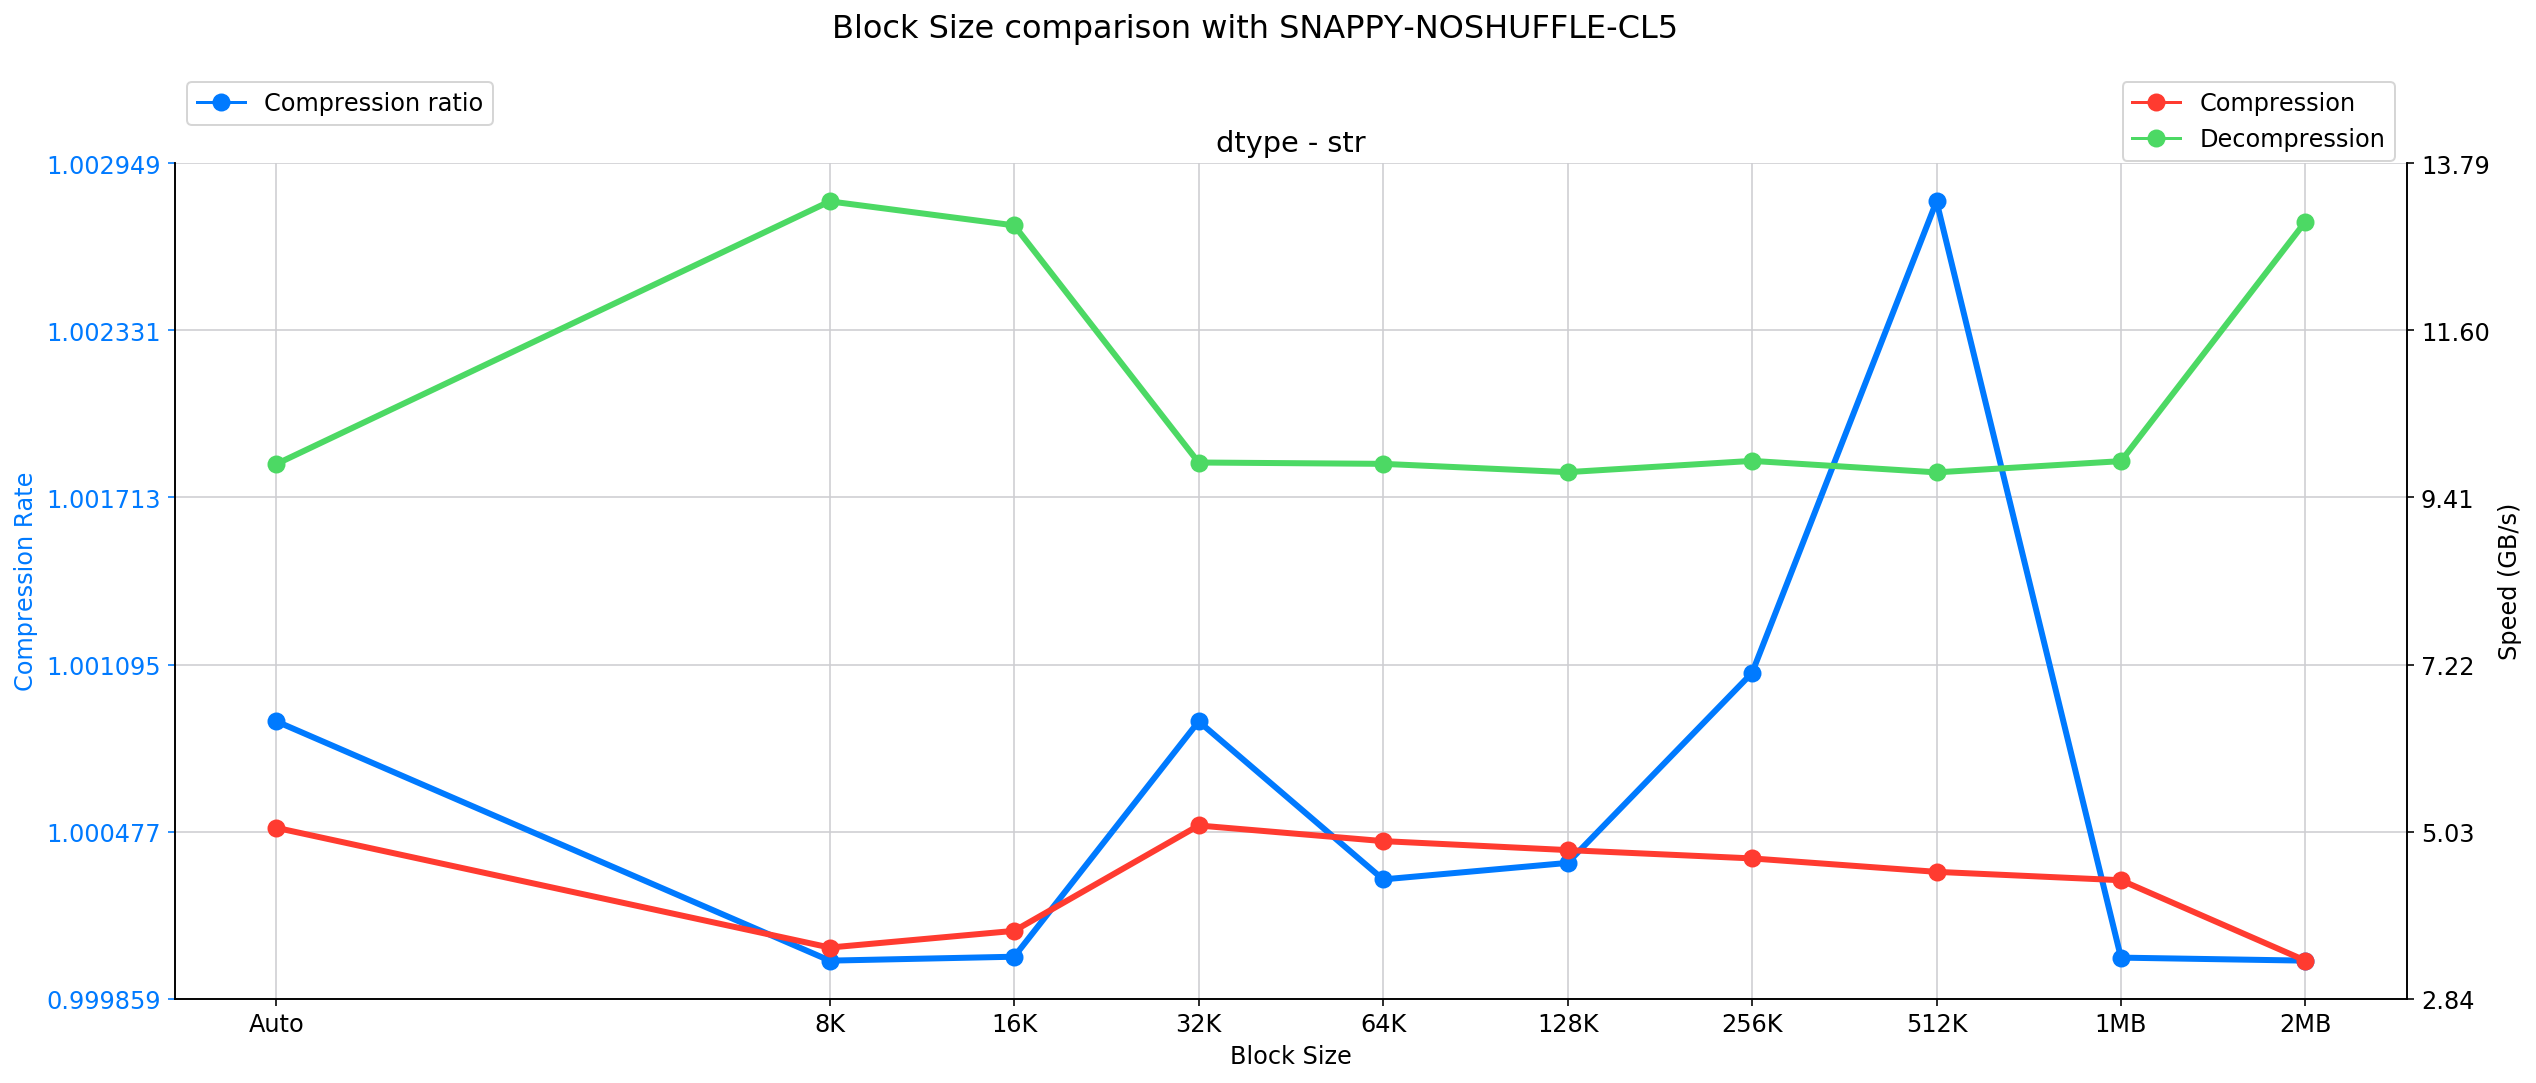

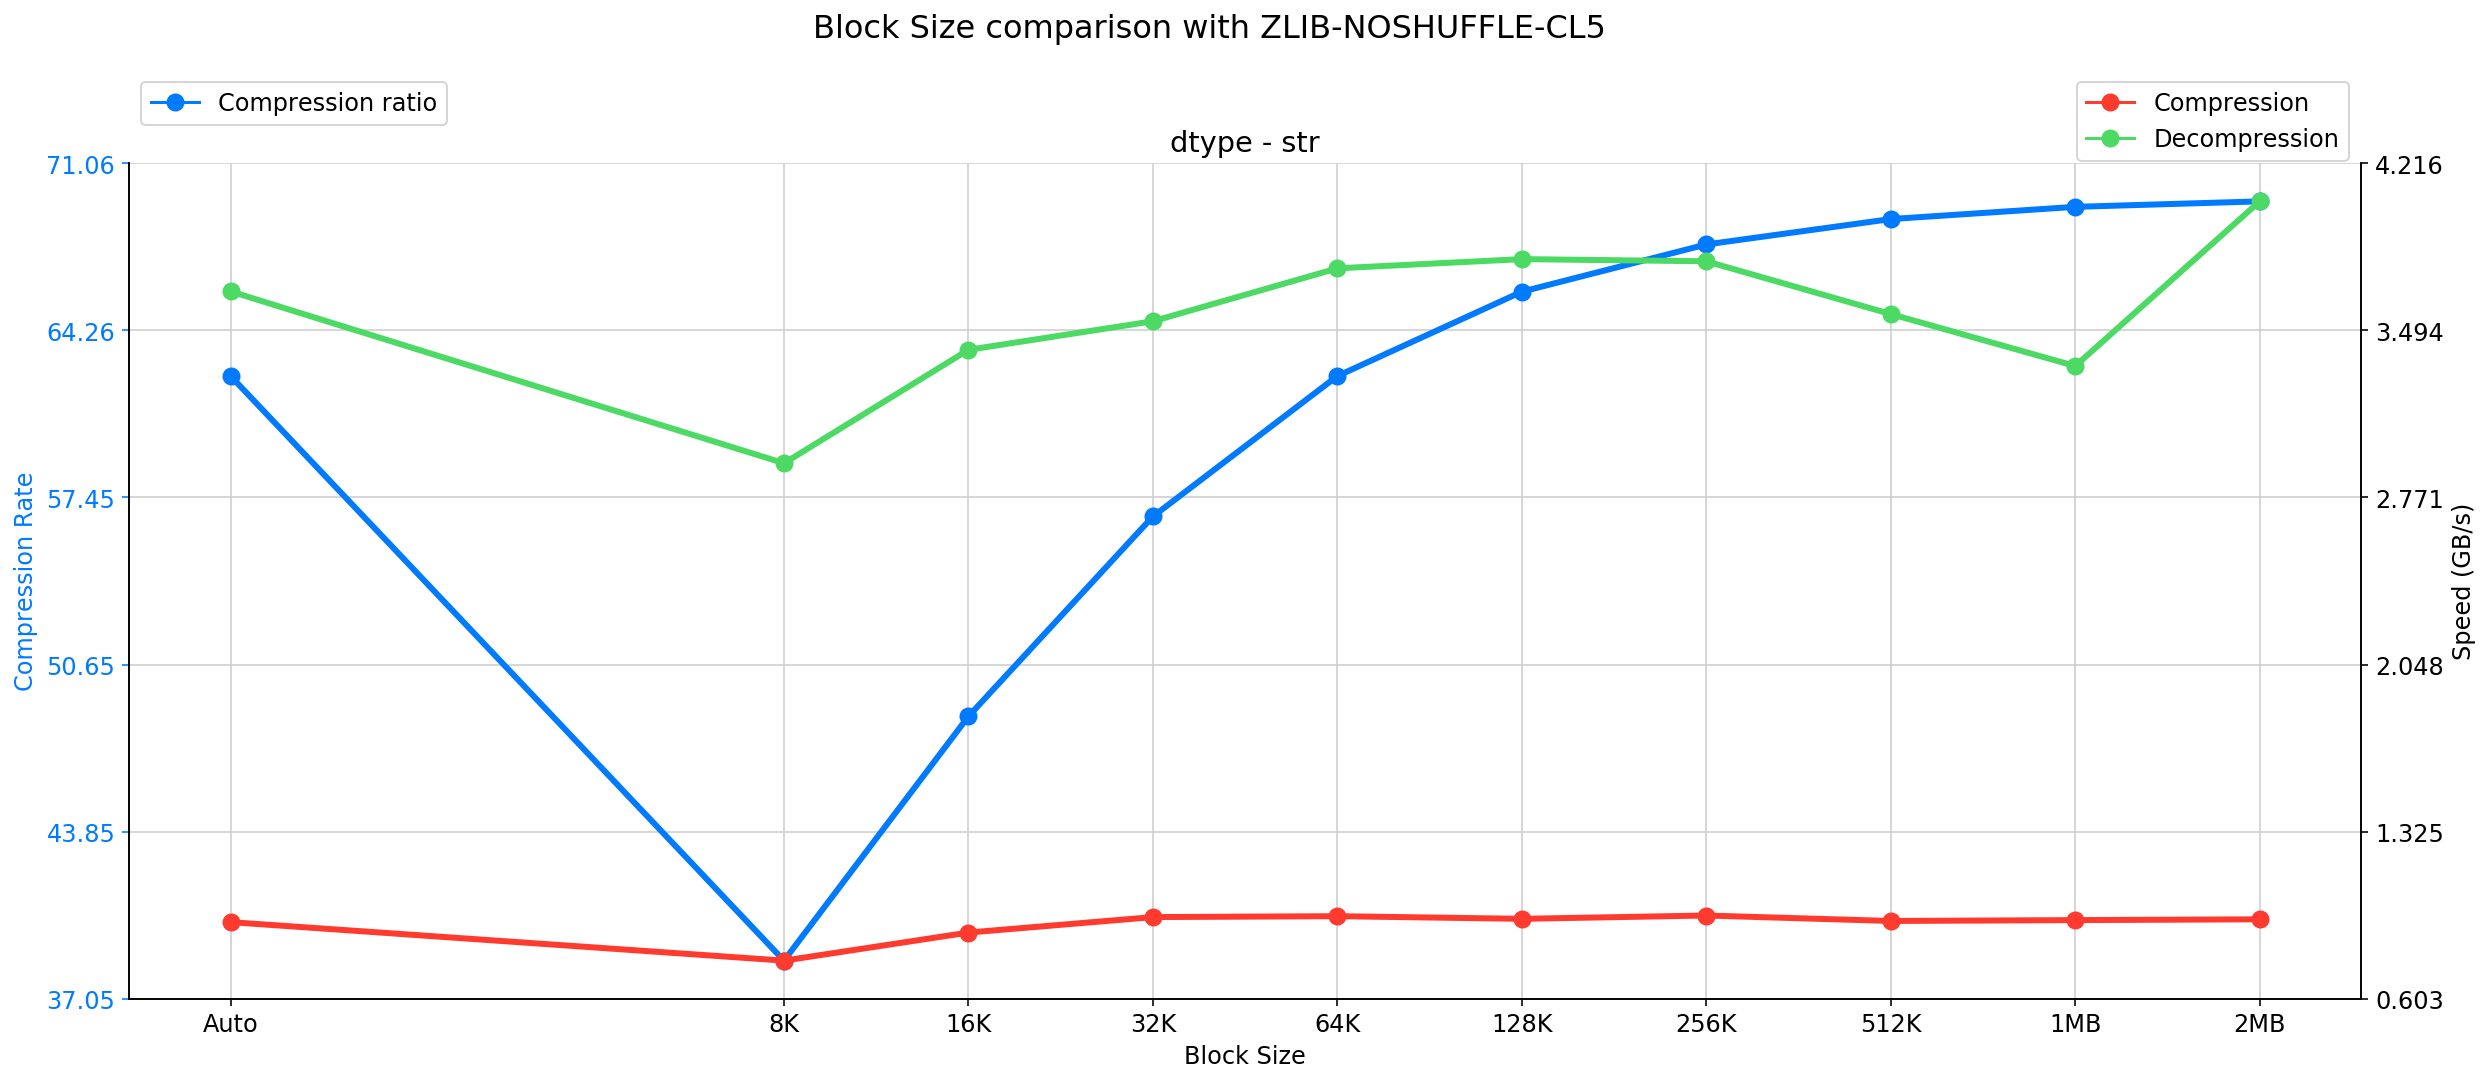

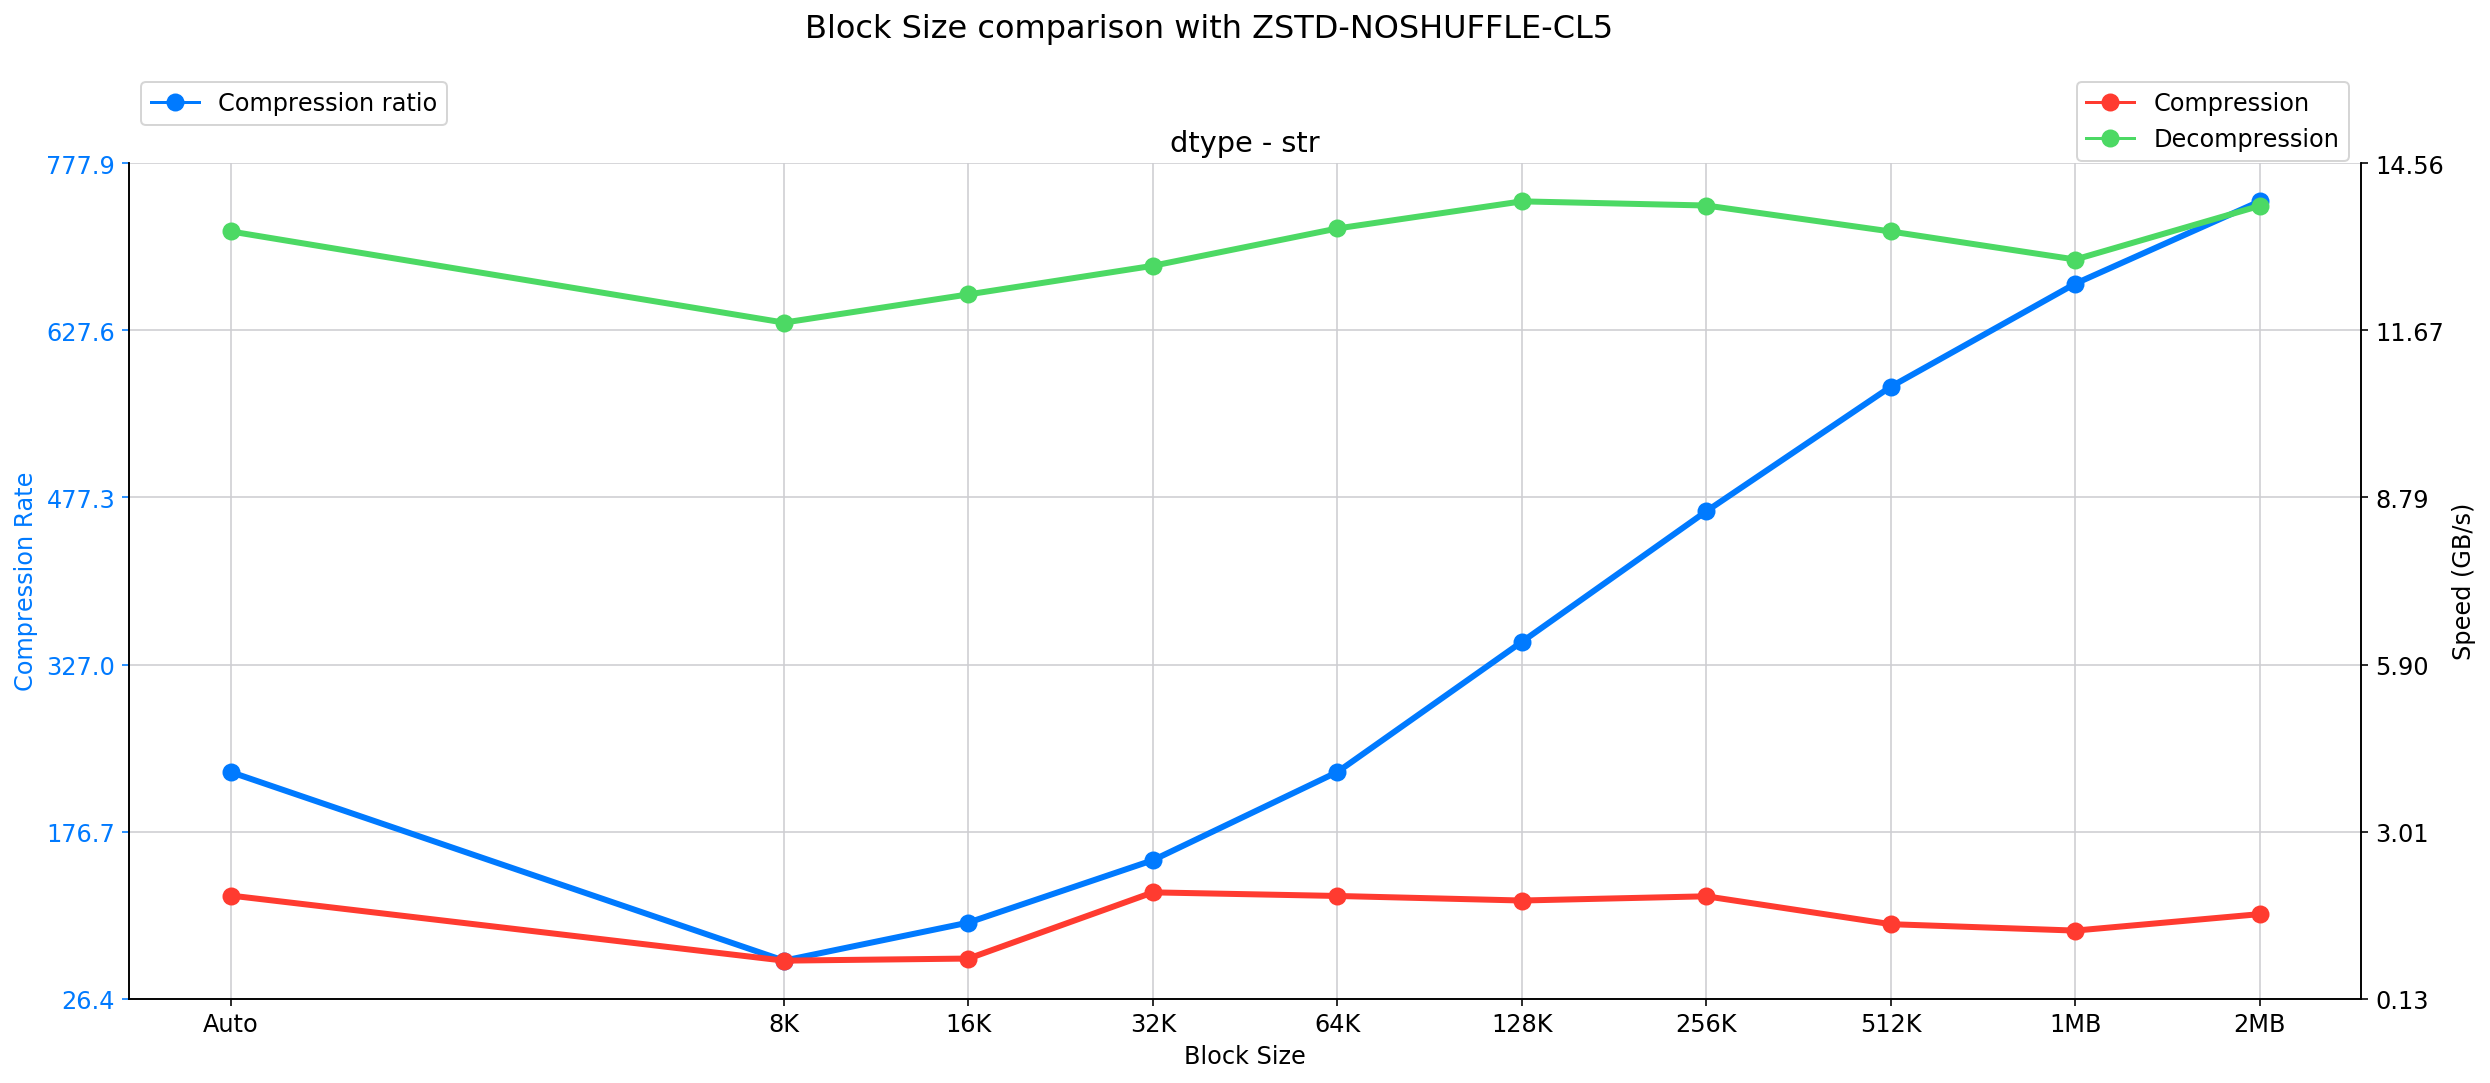

In [11]:
cst.paint_all_block_cor(my_df, 'noshuffle')

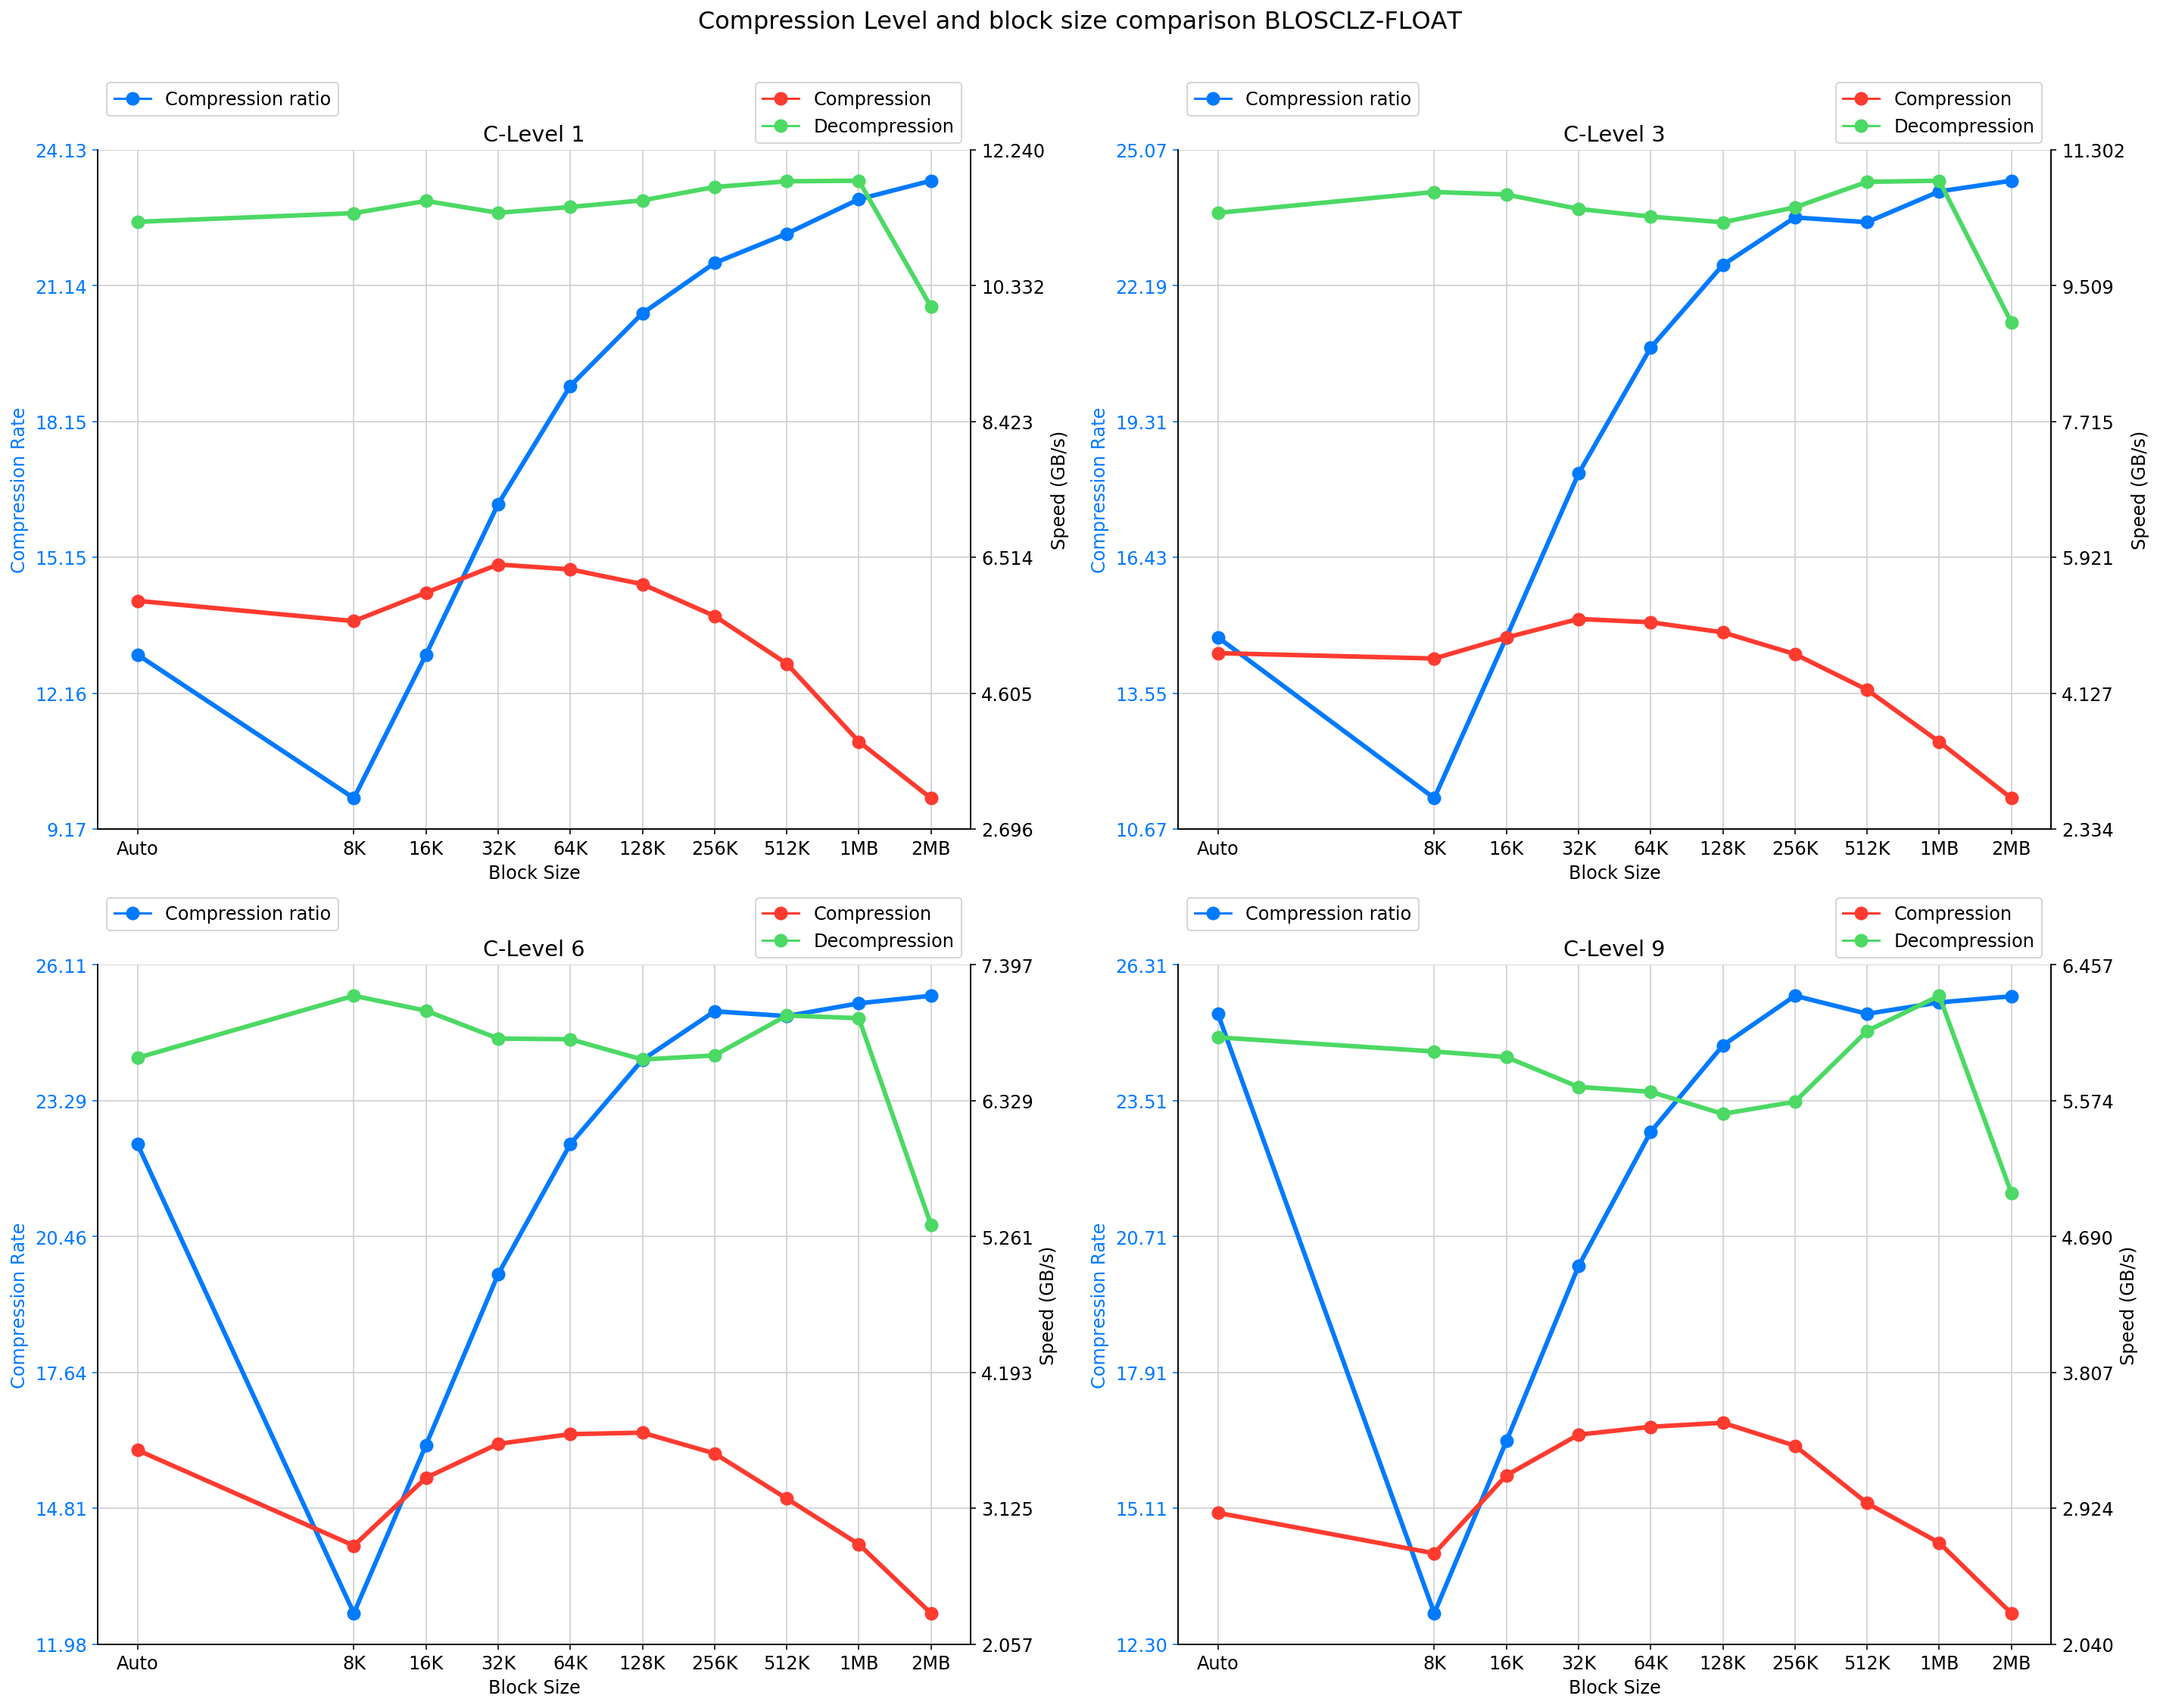

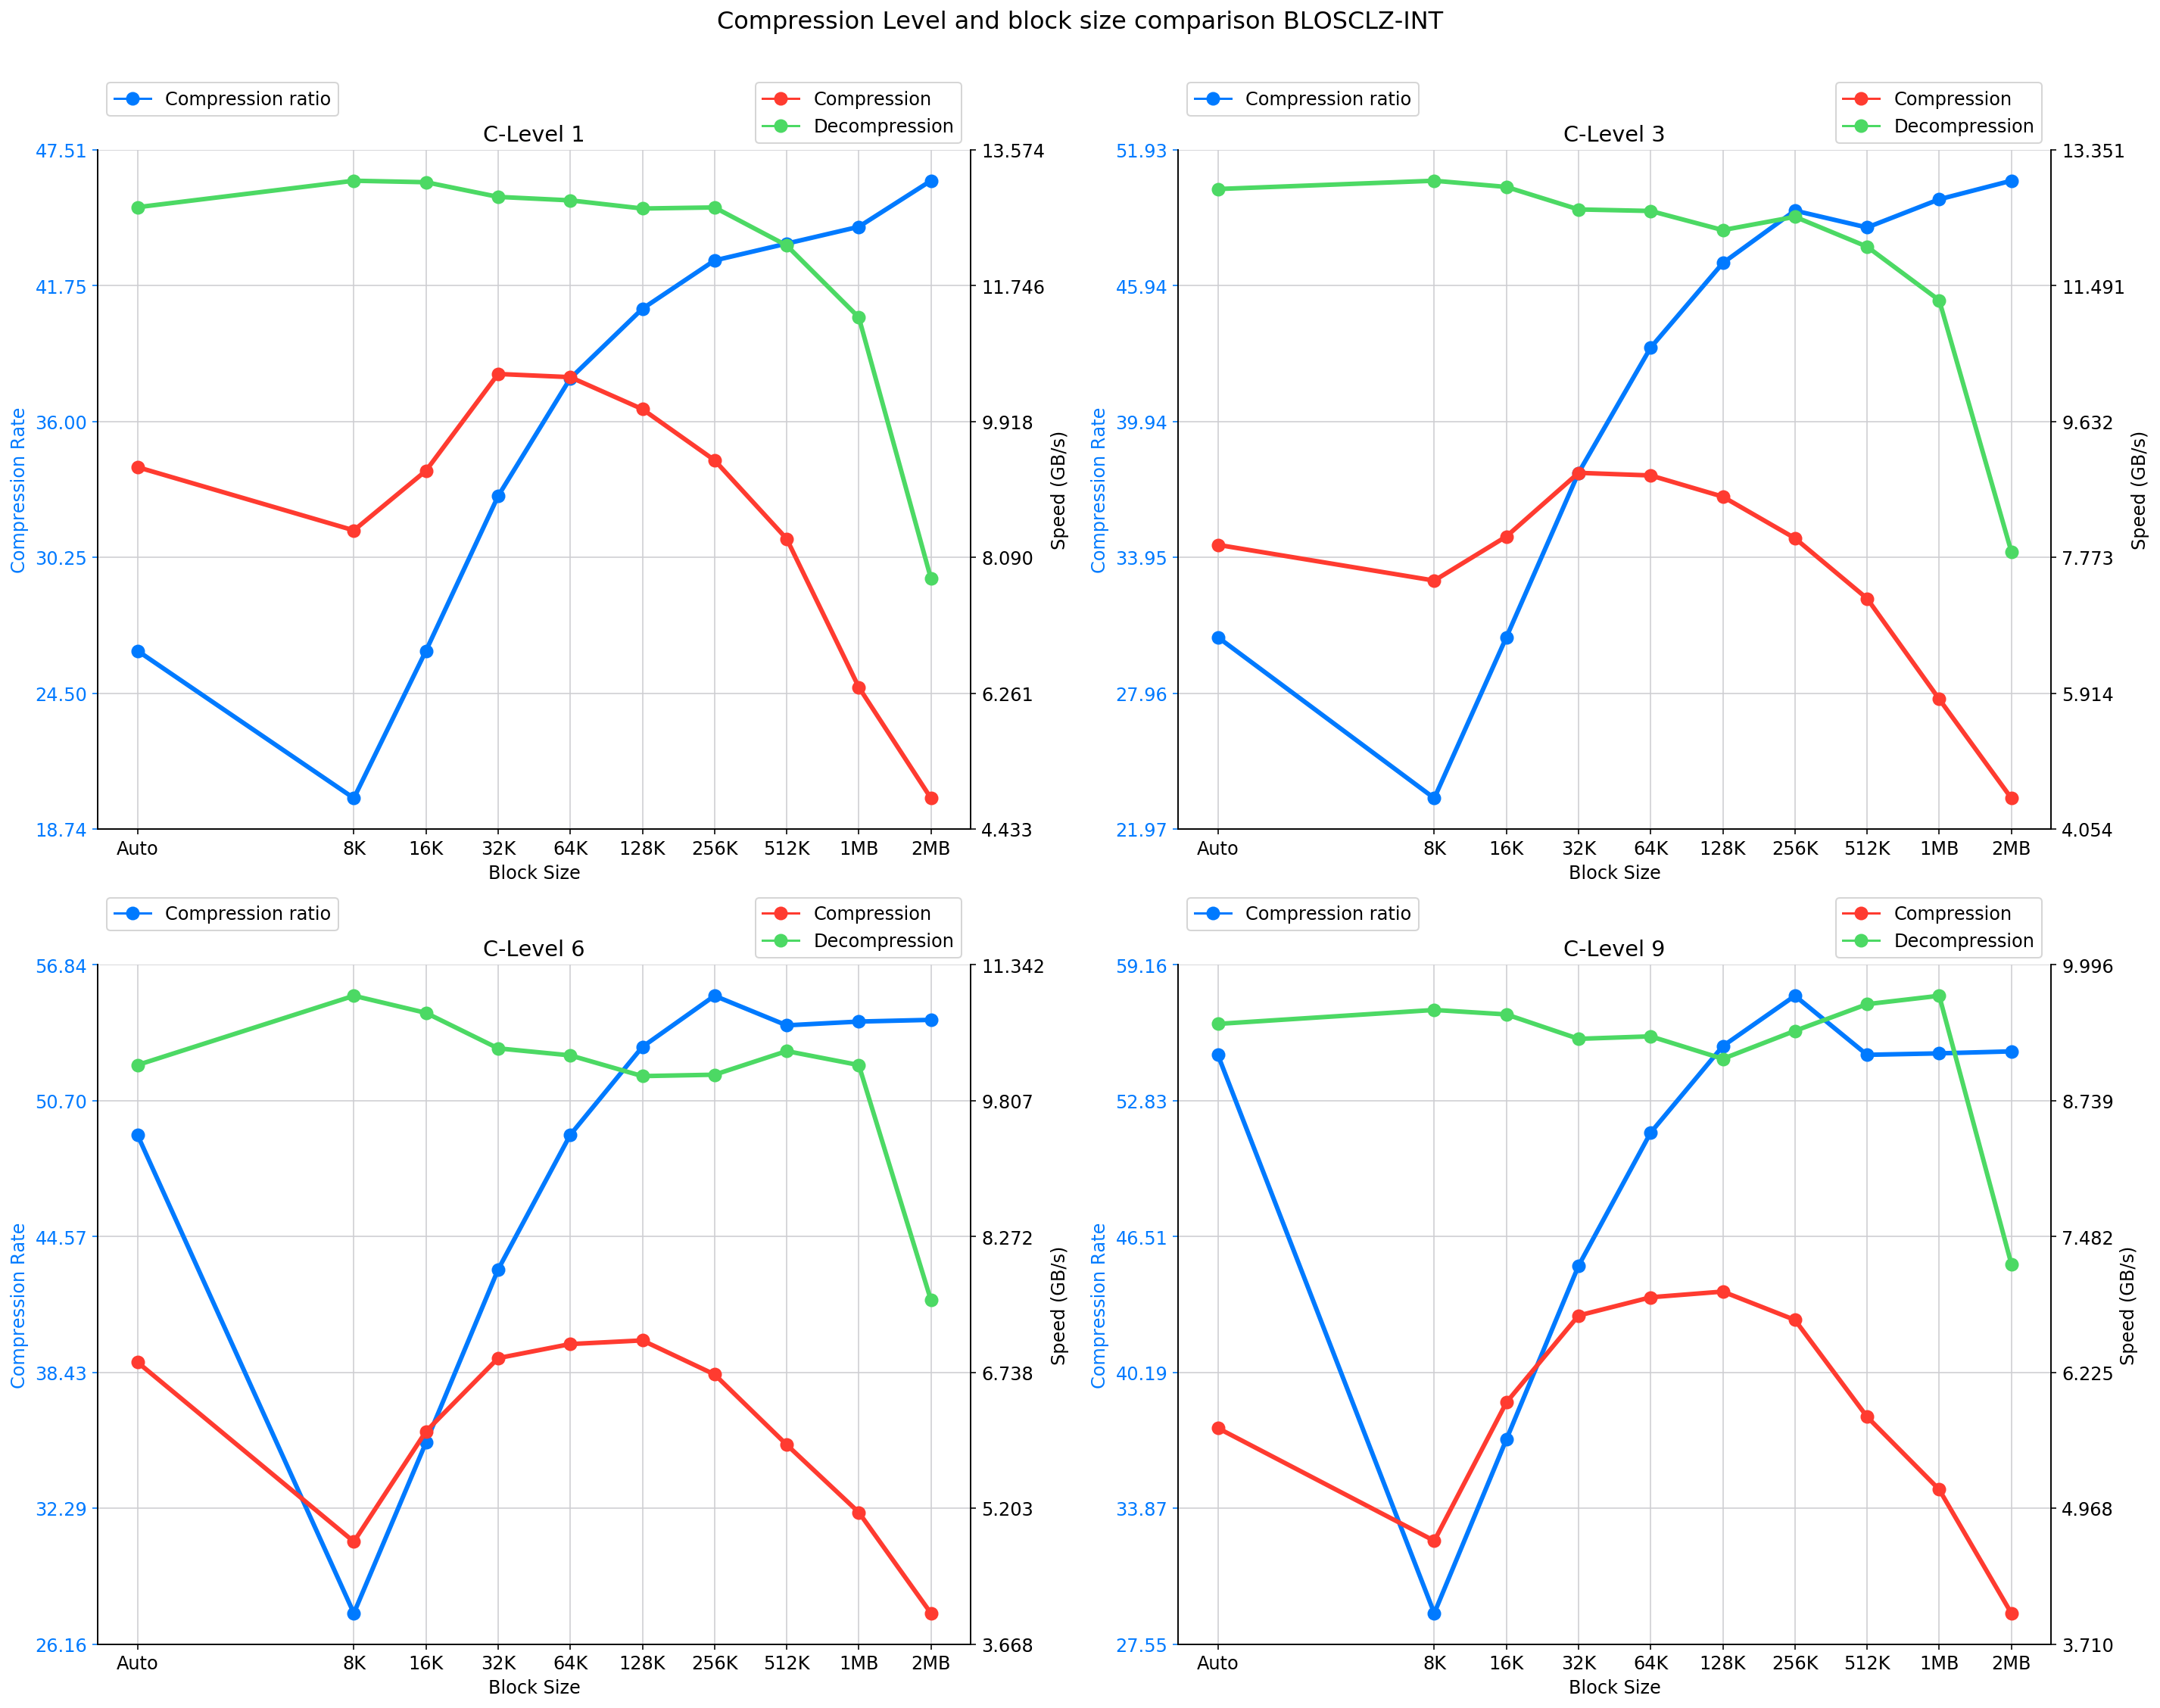

In [12]:
cst.paint_cl_comparison(my_df, 'shuffle', 'blosclz')

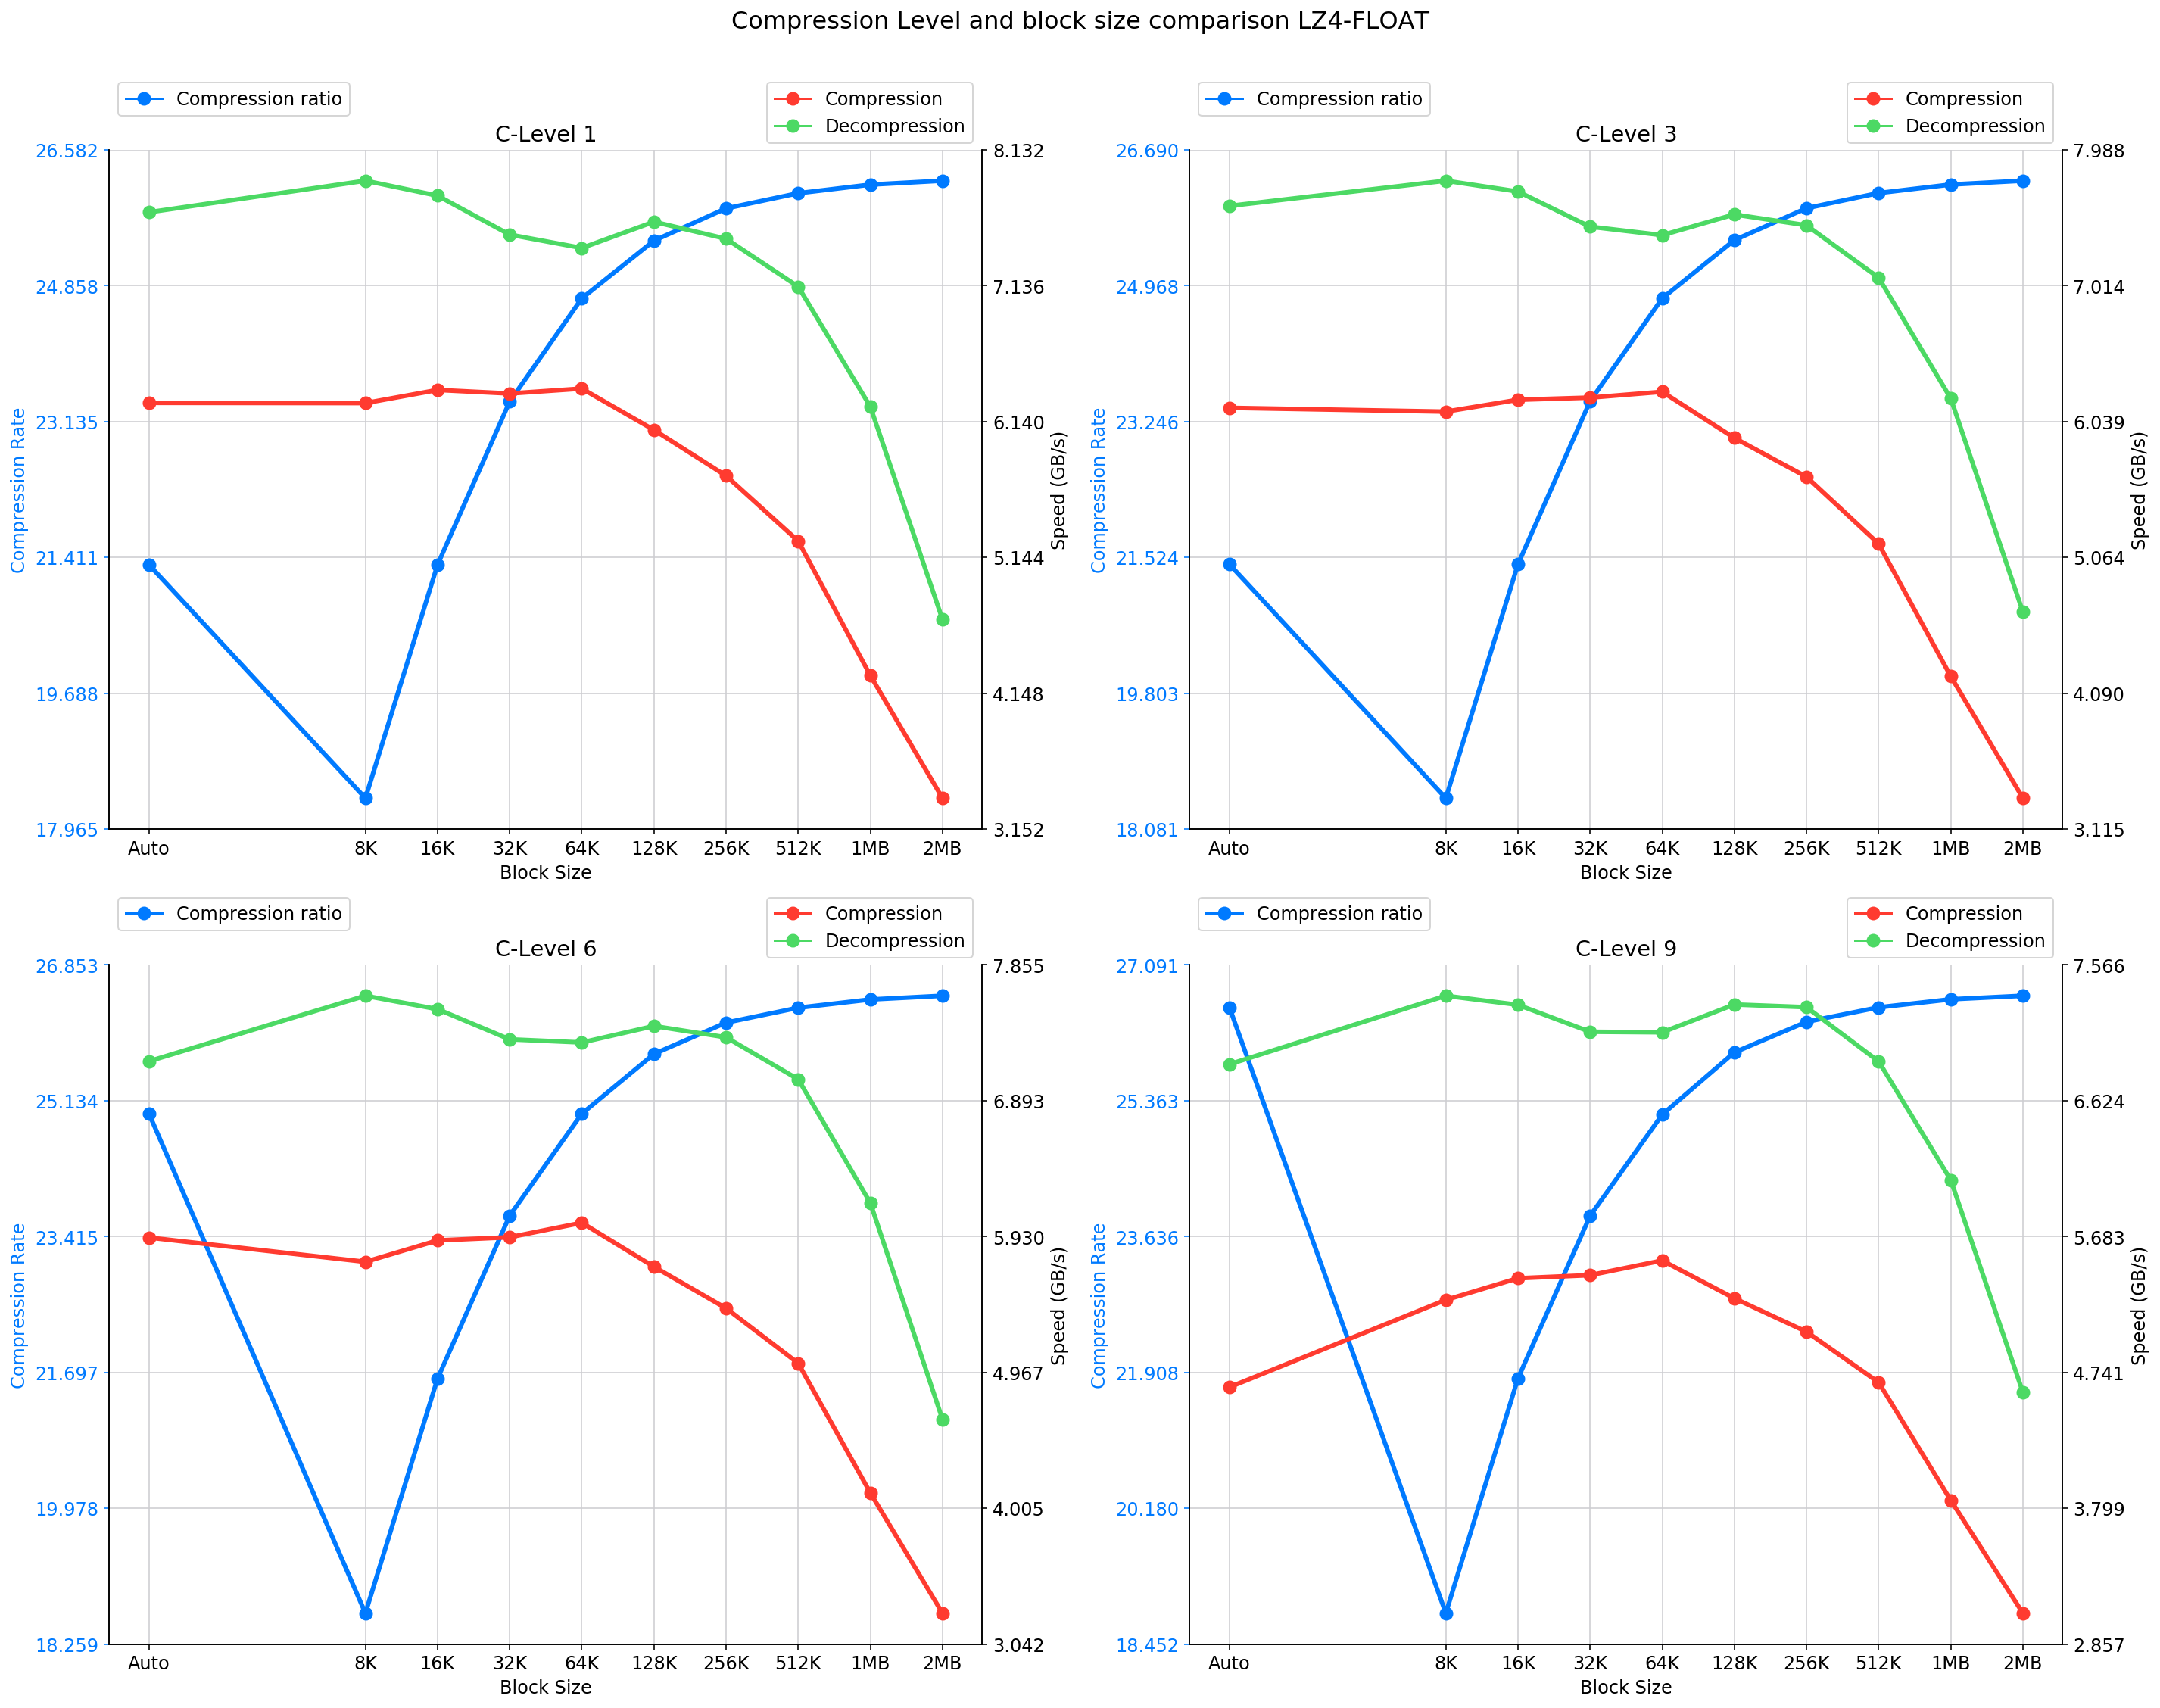

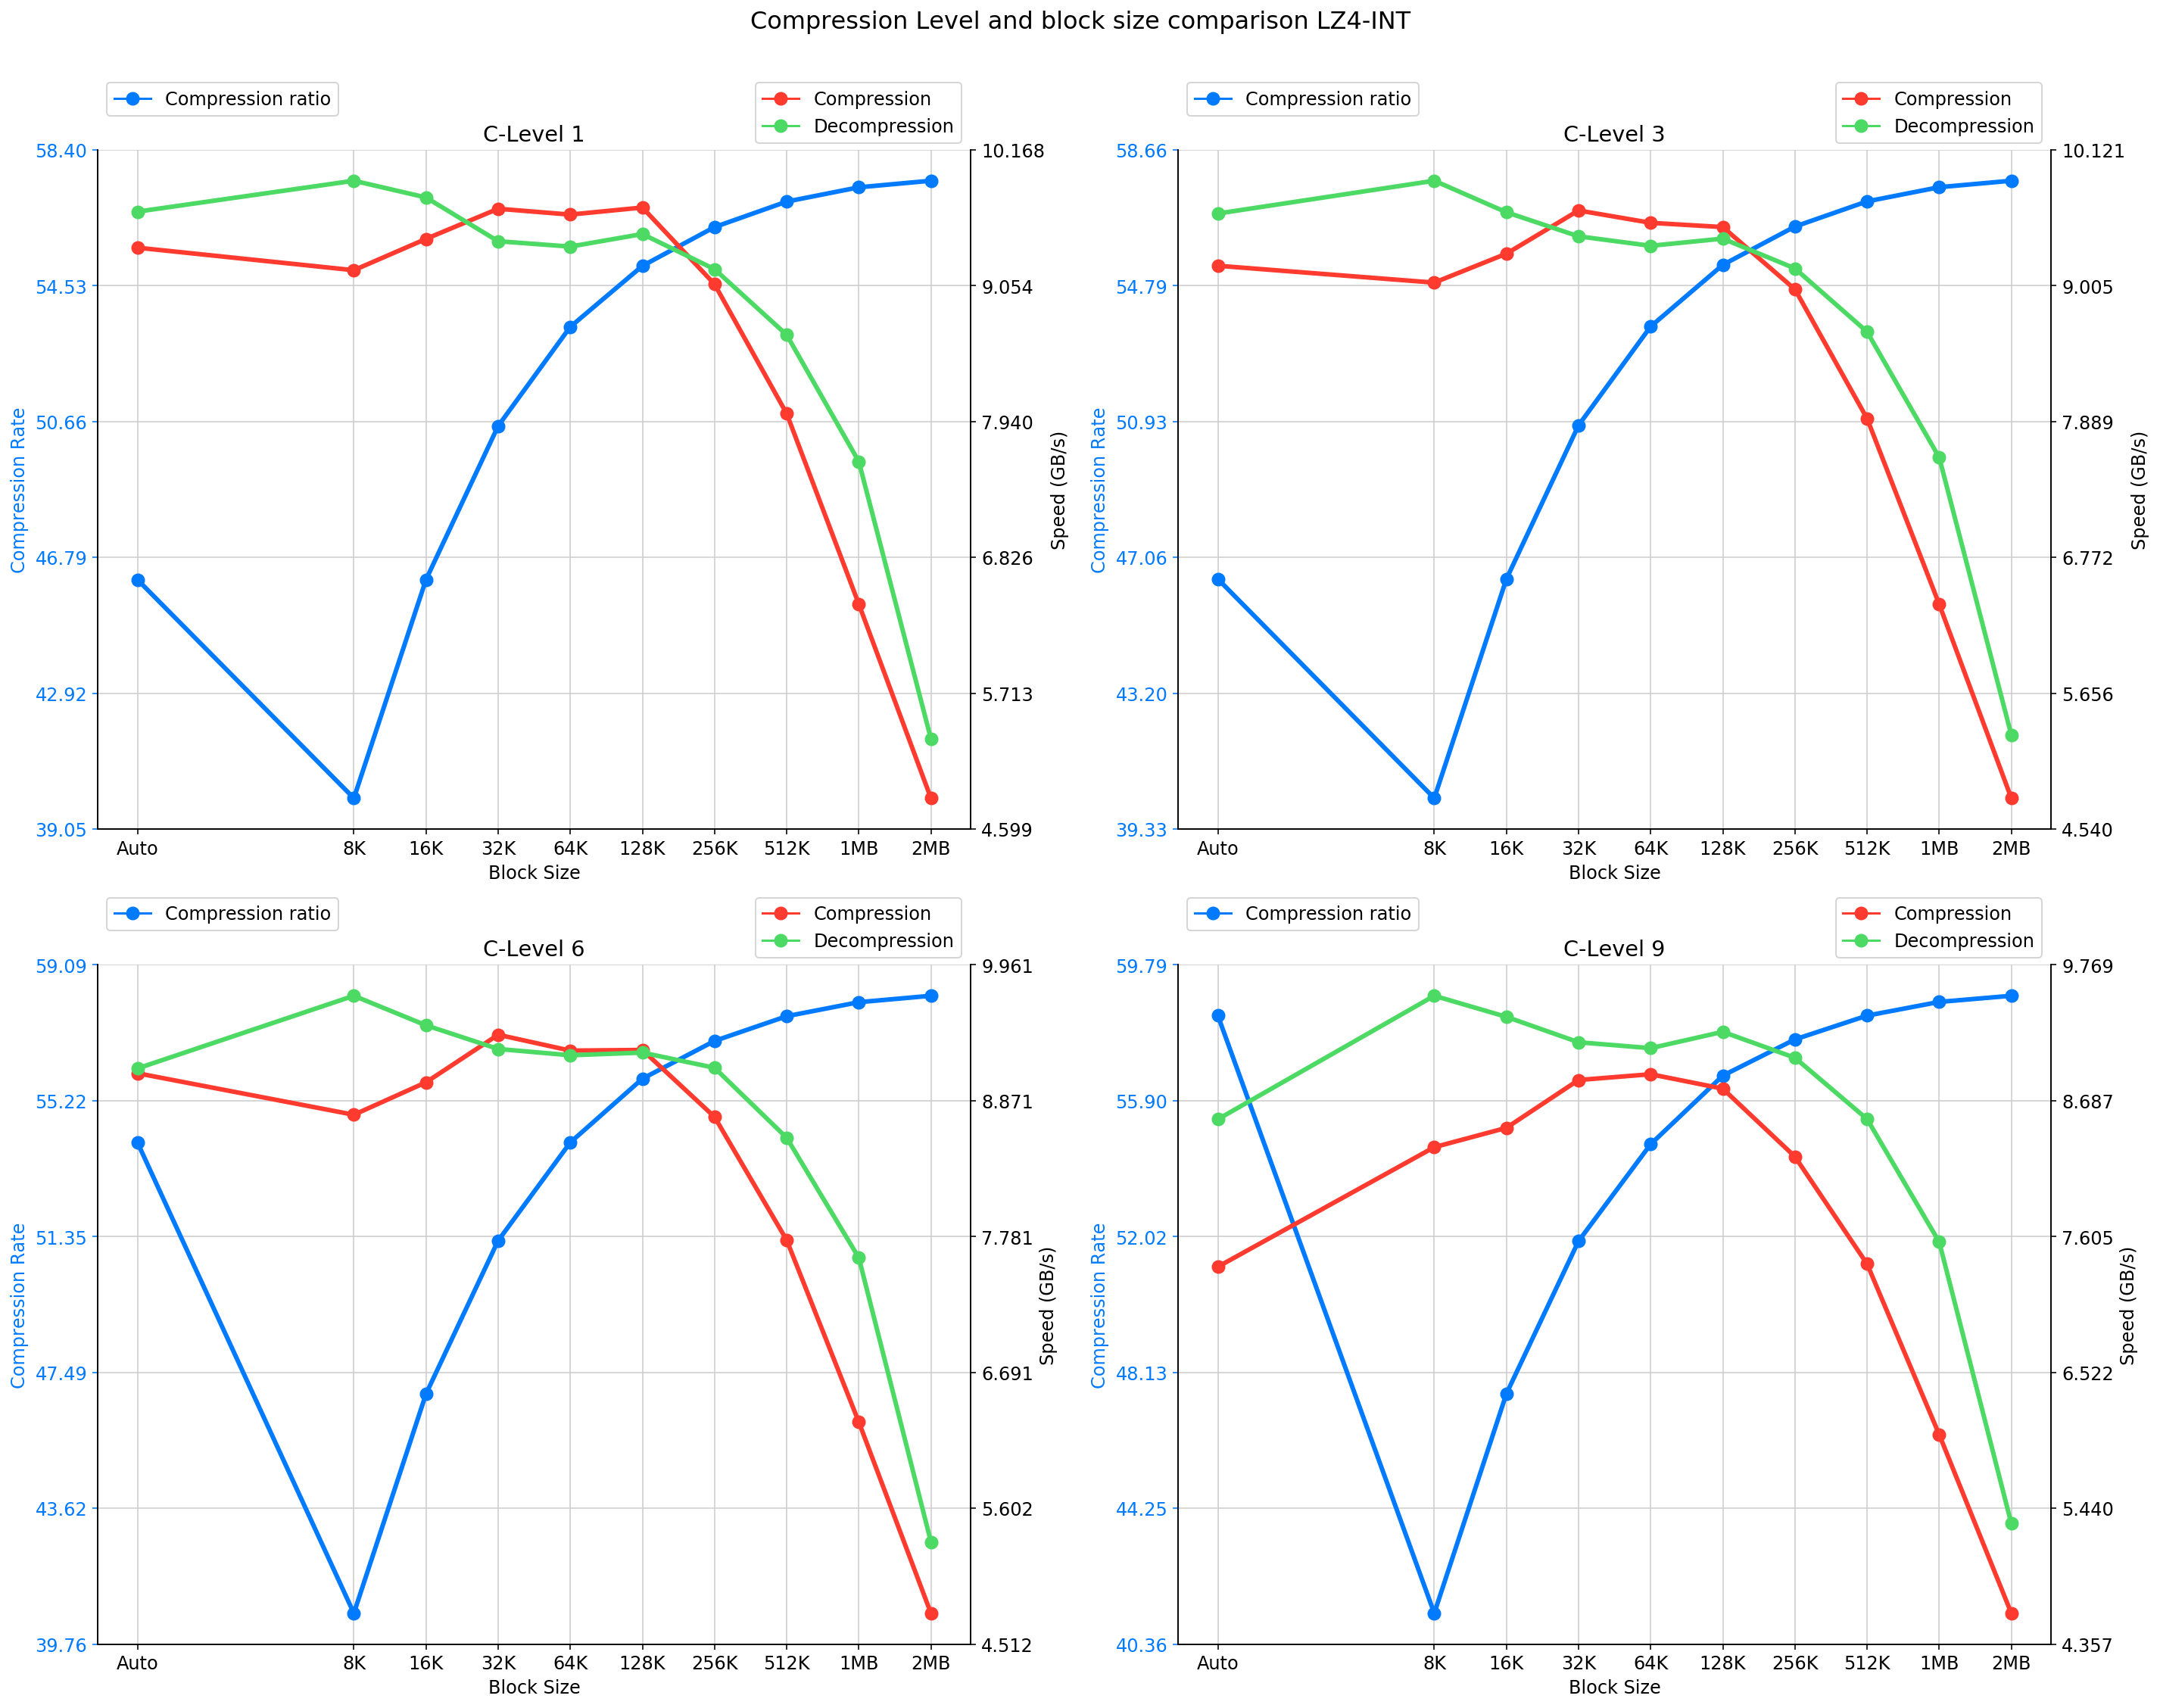

In [13]:
cst.paint_cl_comparison(my_df, 'shuffle', 'lz4')

## Comparación de niveles de compresión
Al igual que en el anterior caso hacemos los mismos gráficos pero observando el nivel de compresión.

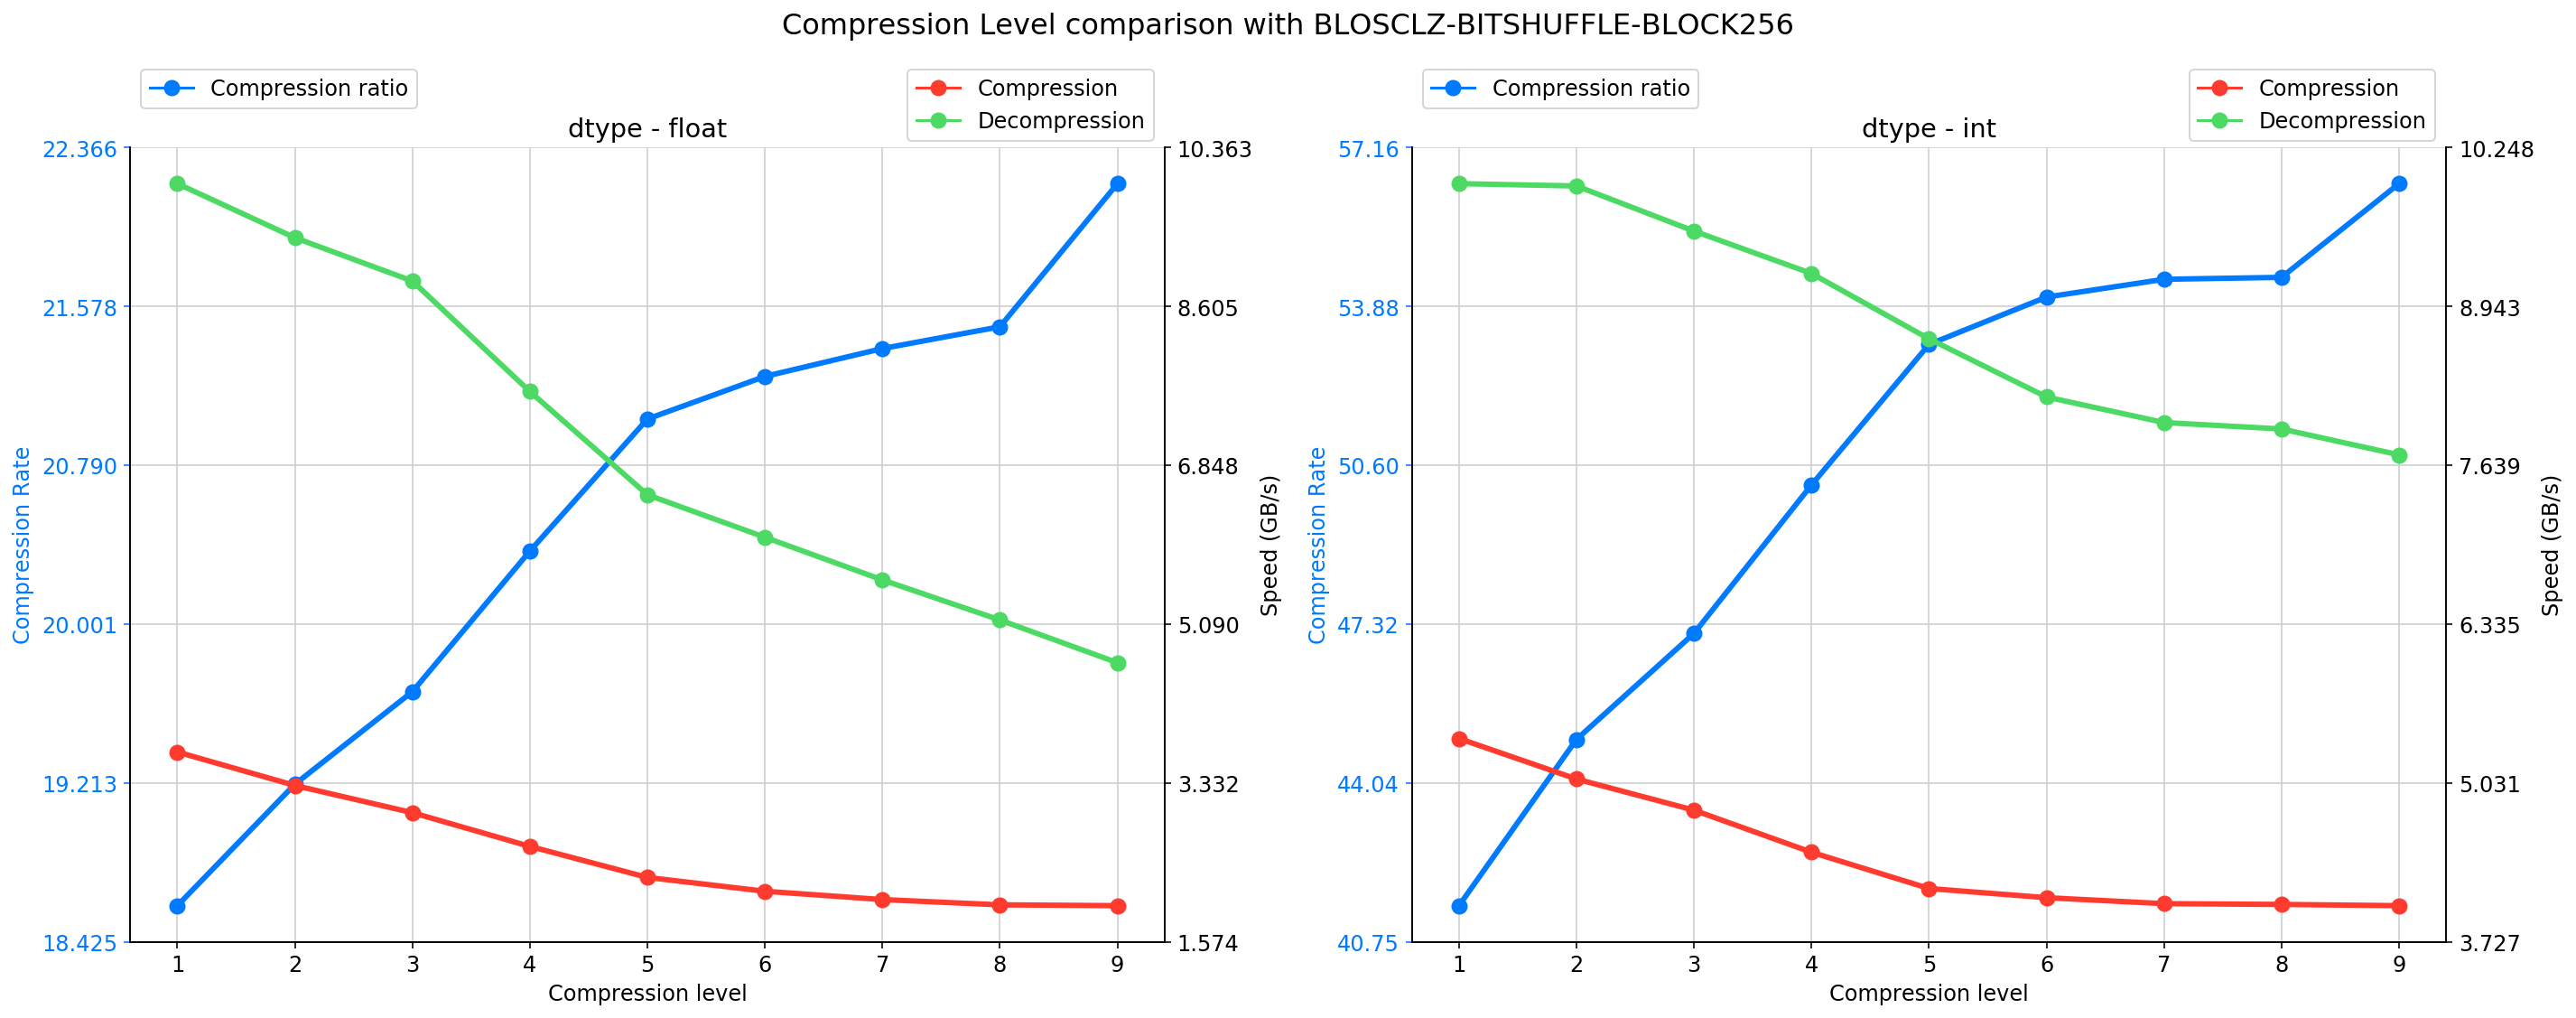

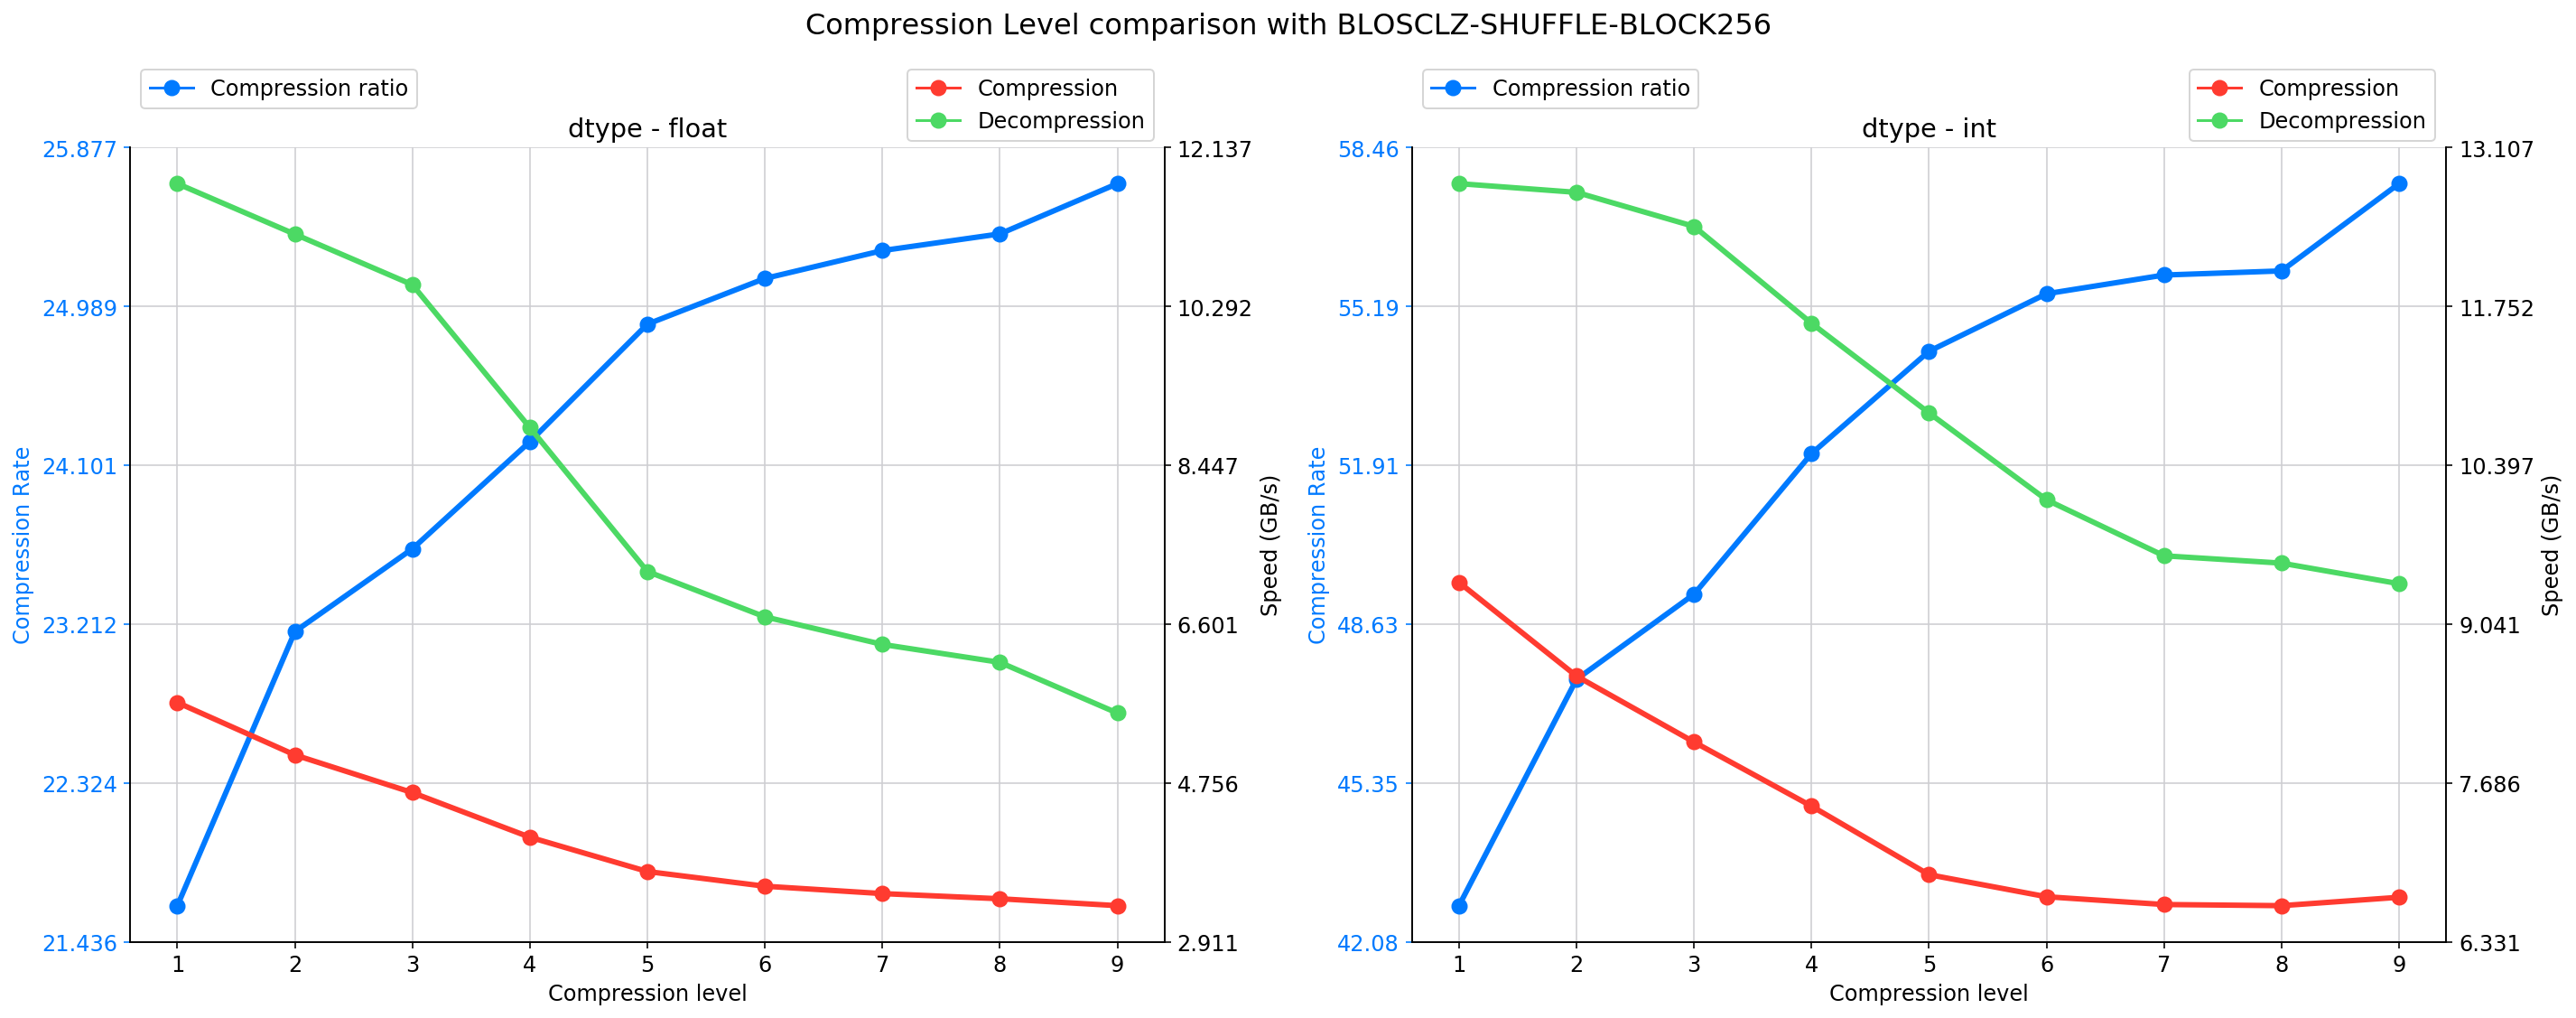

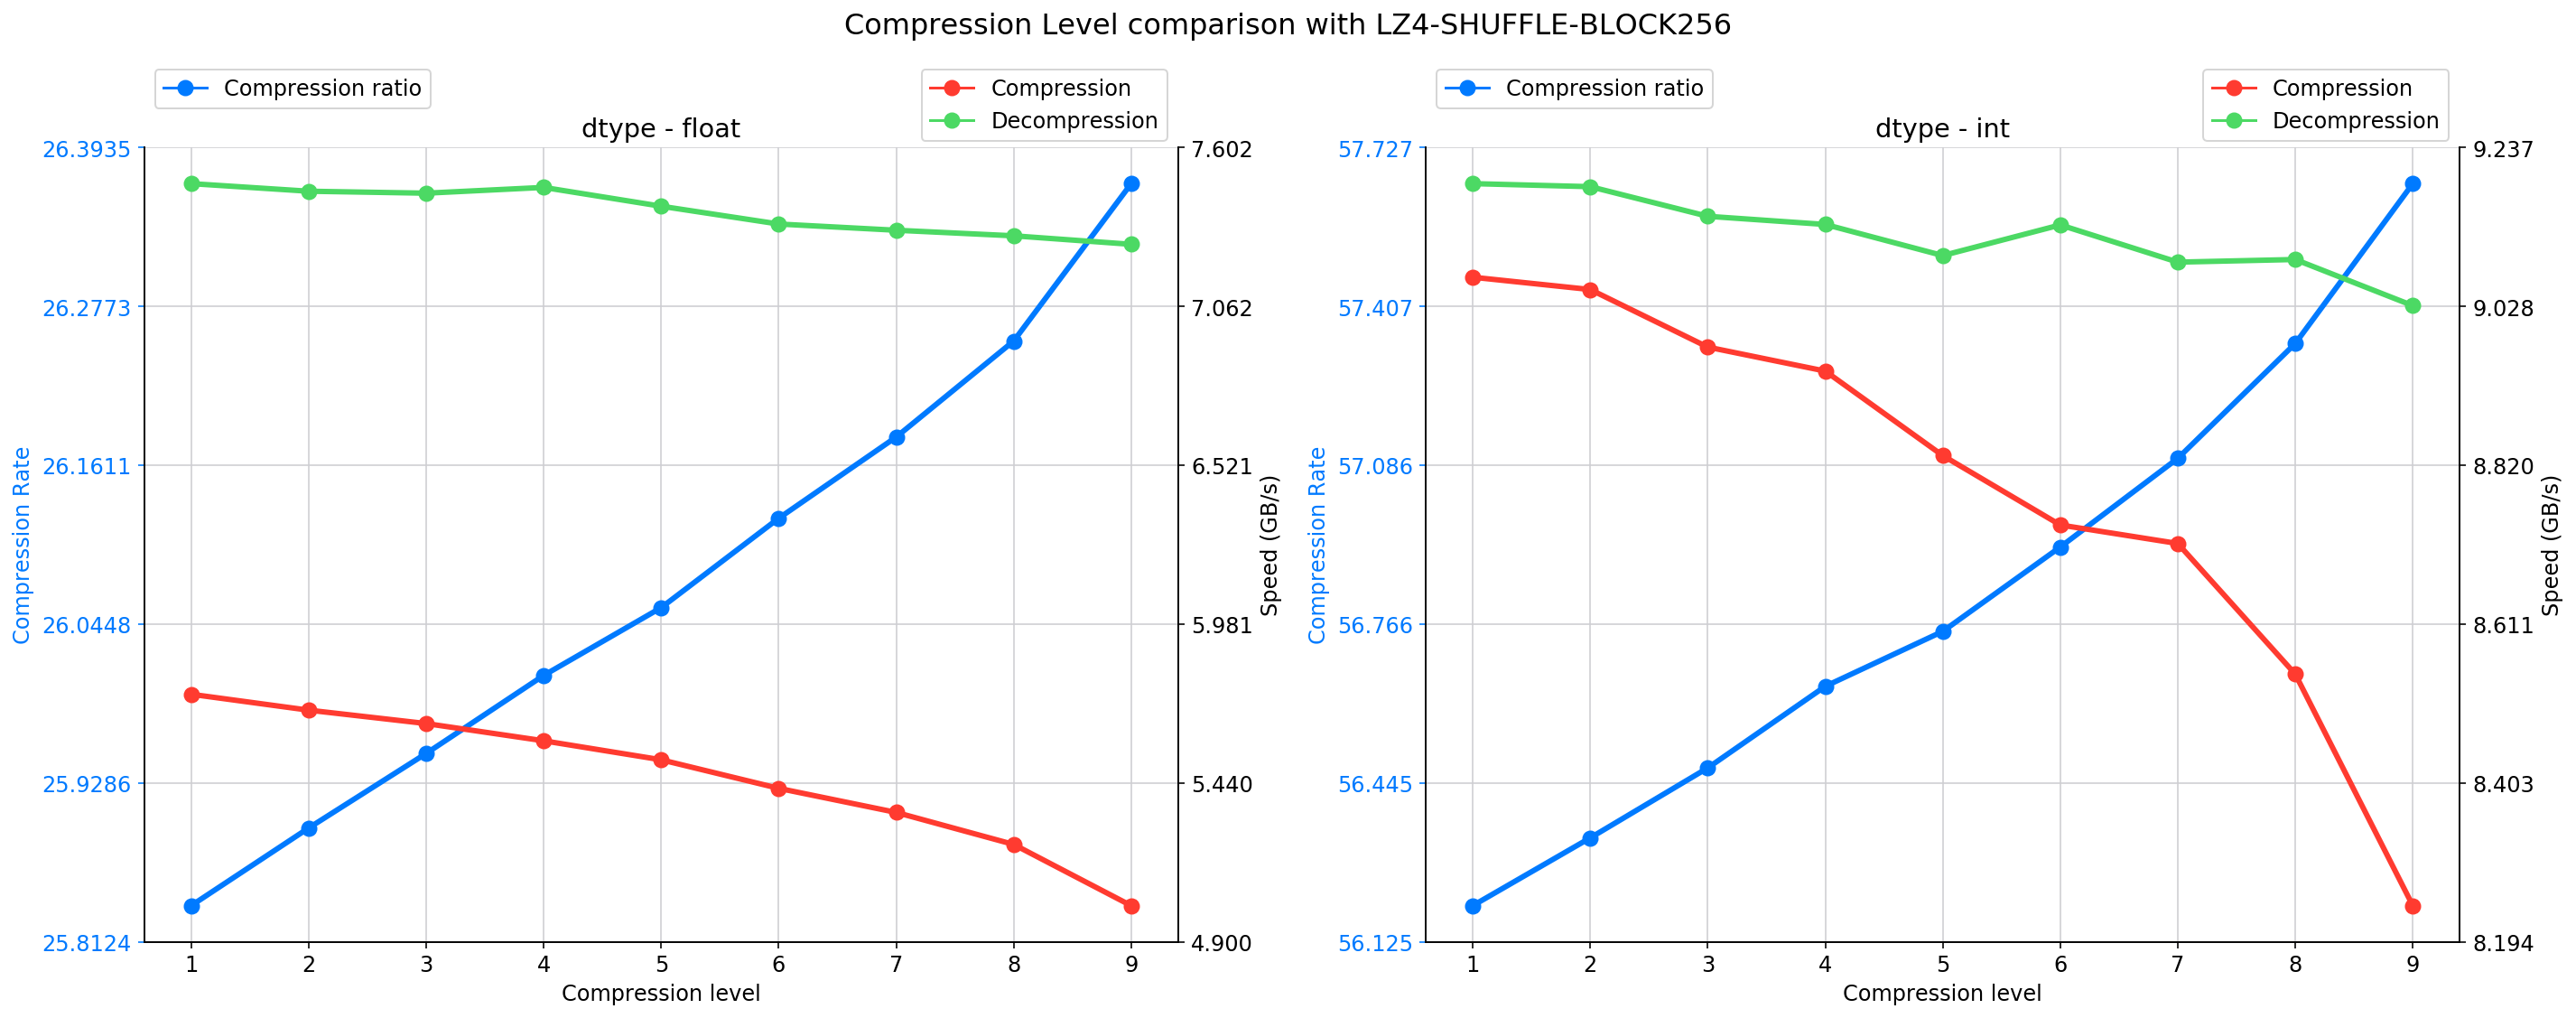

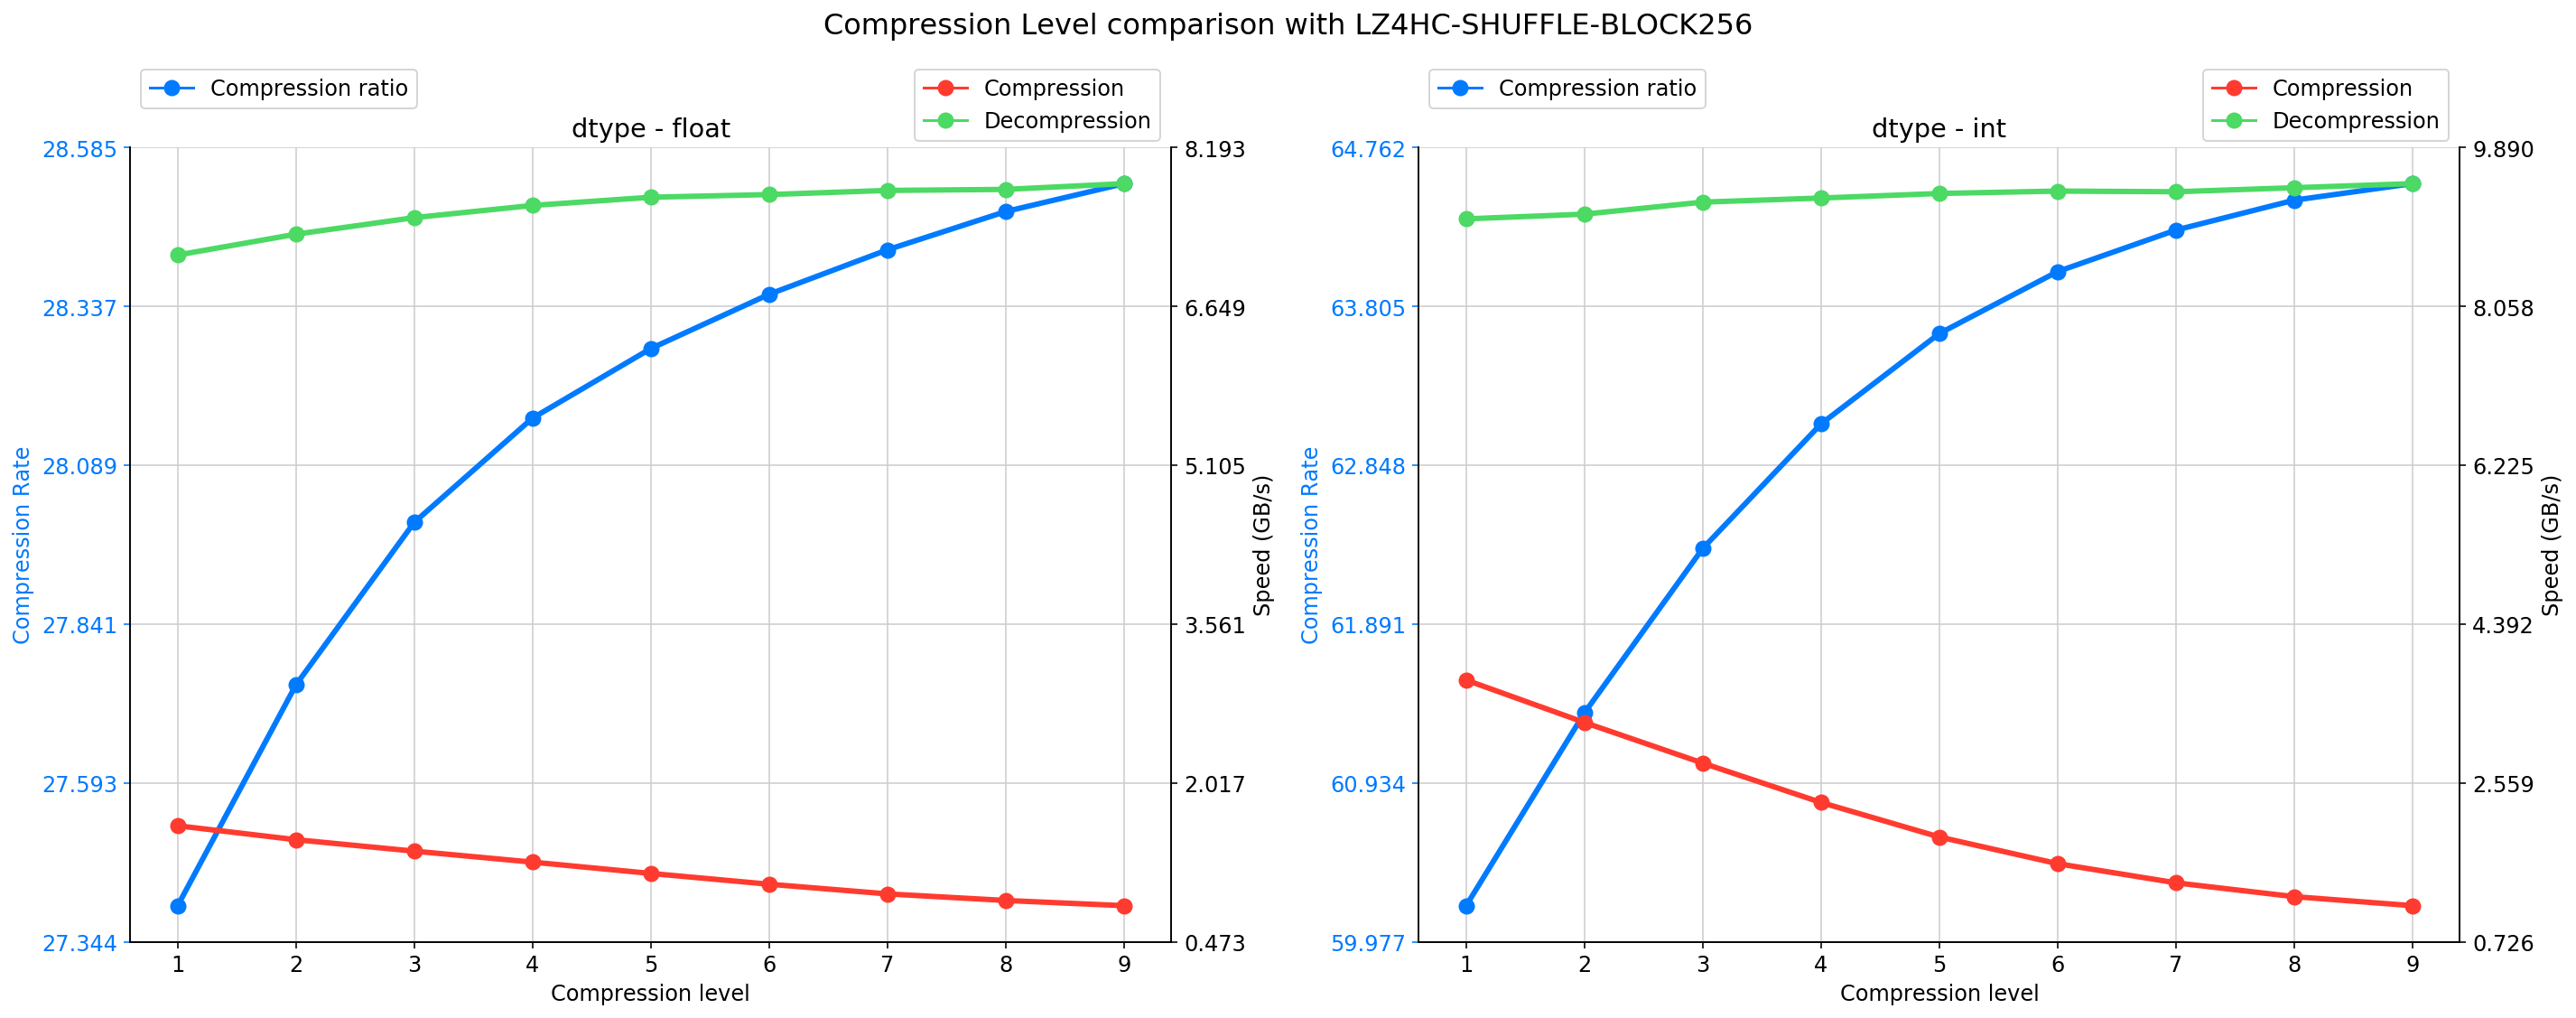

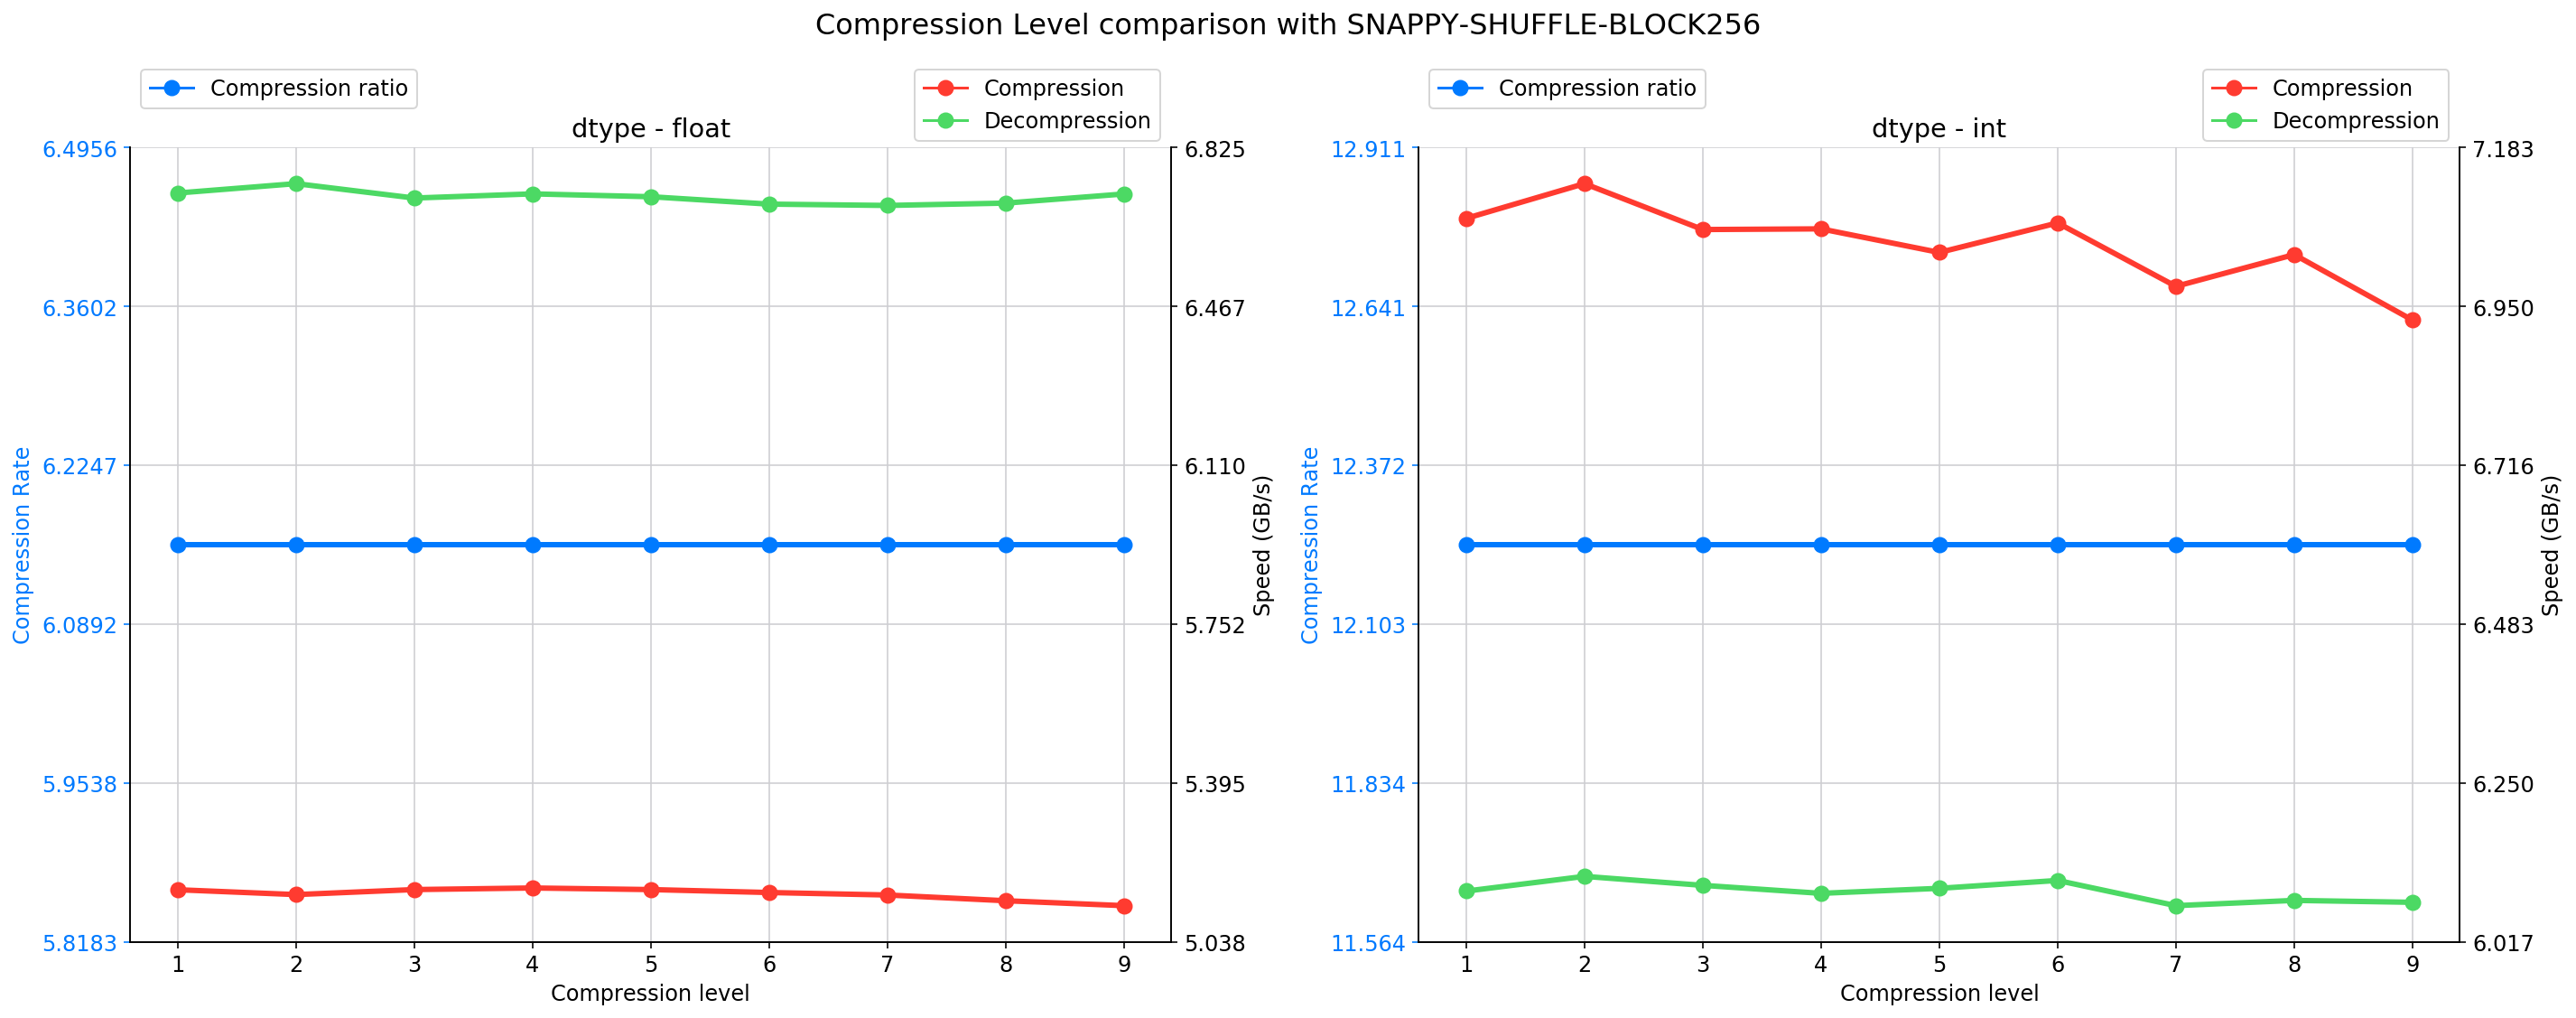

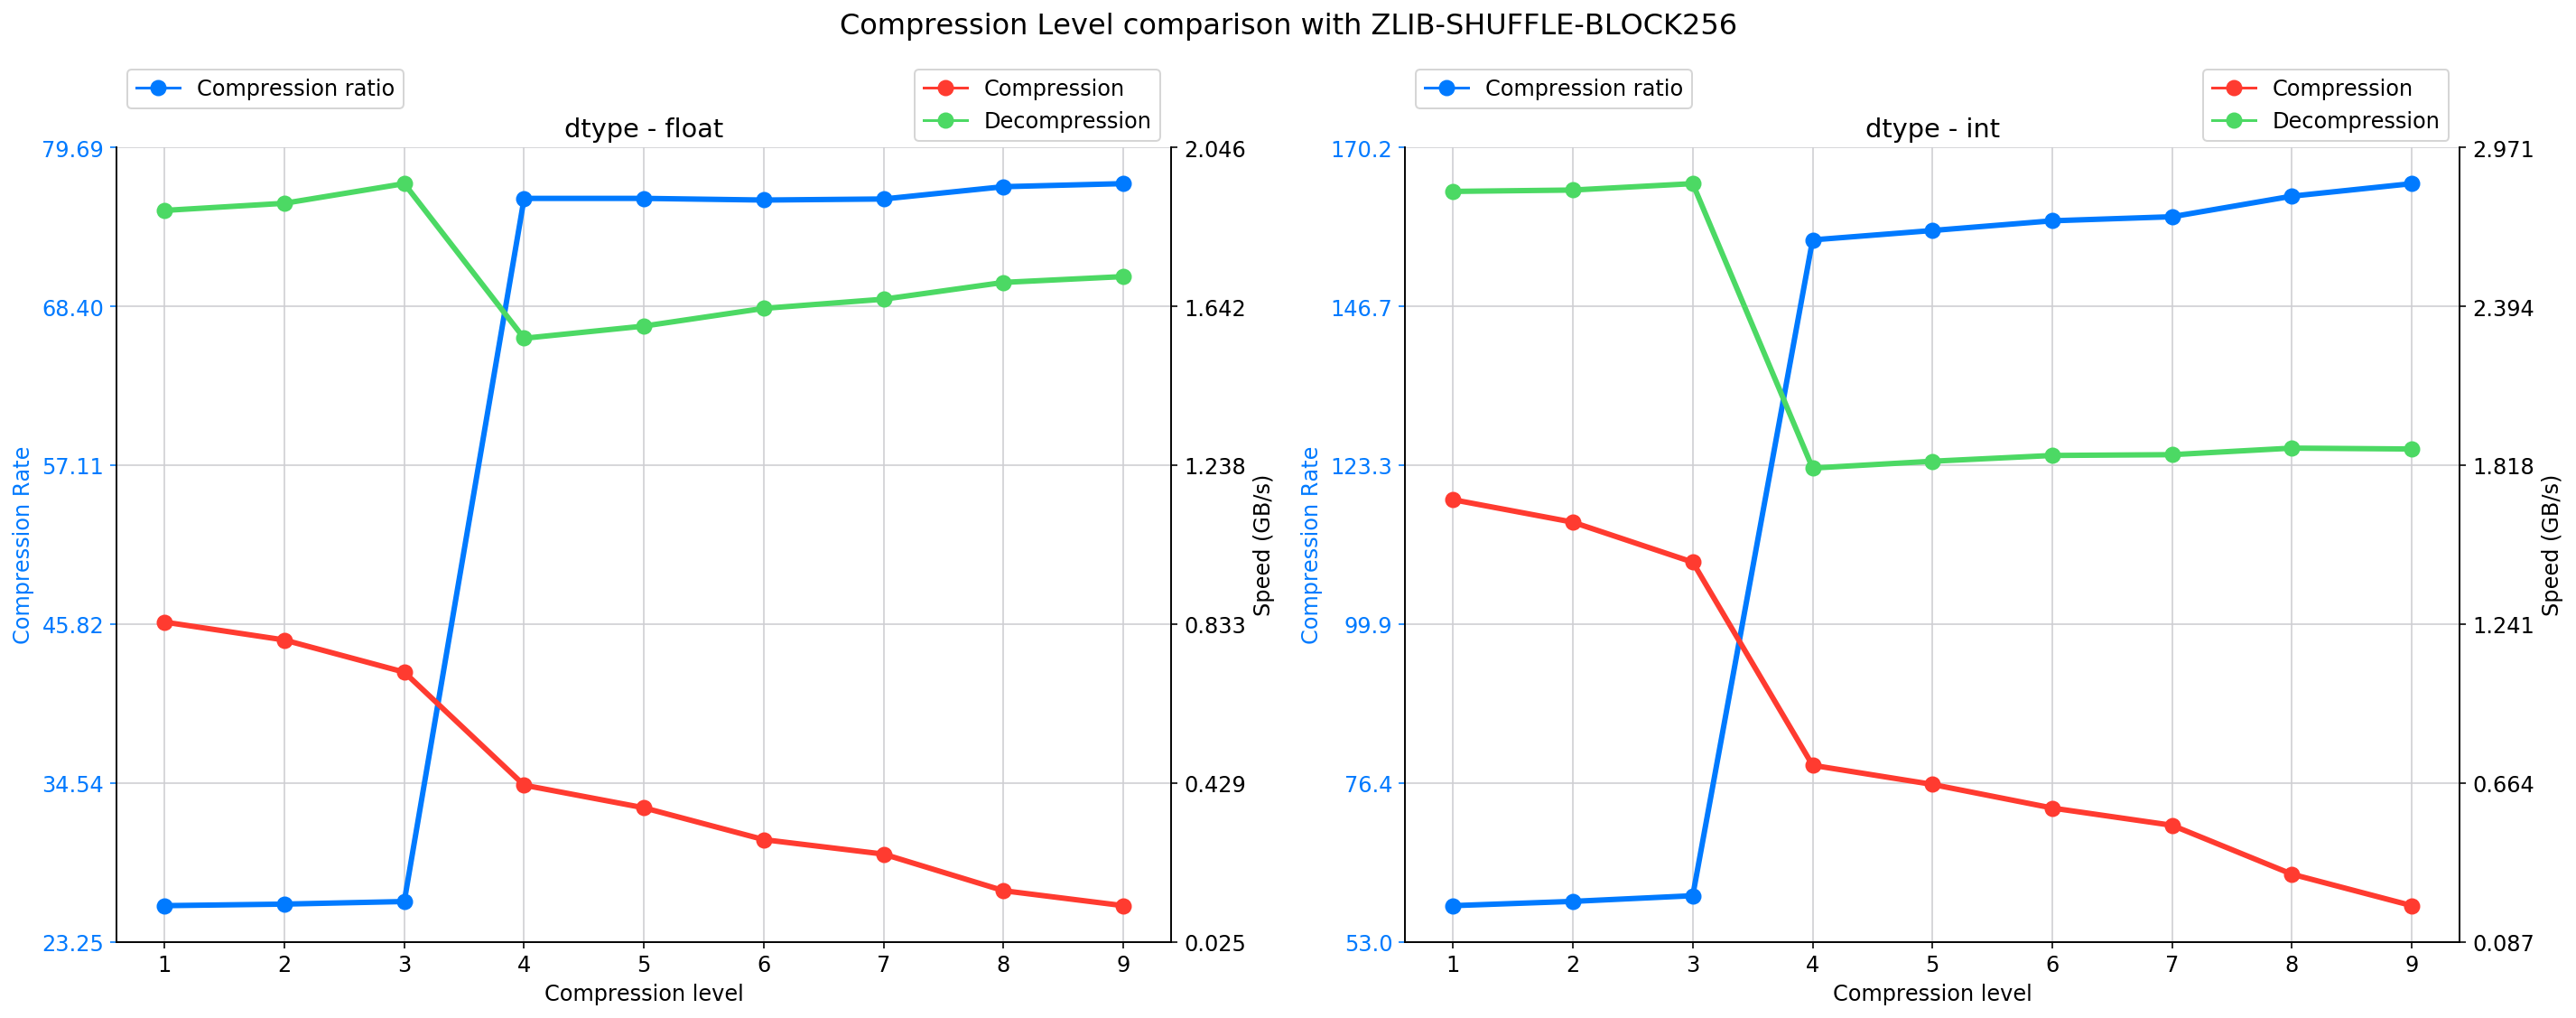

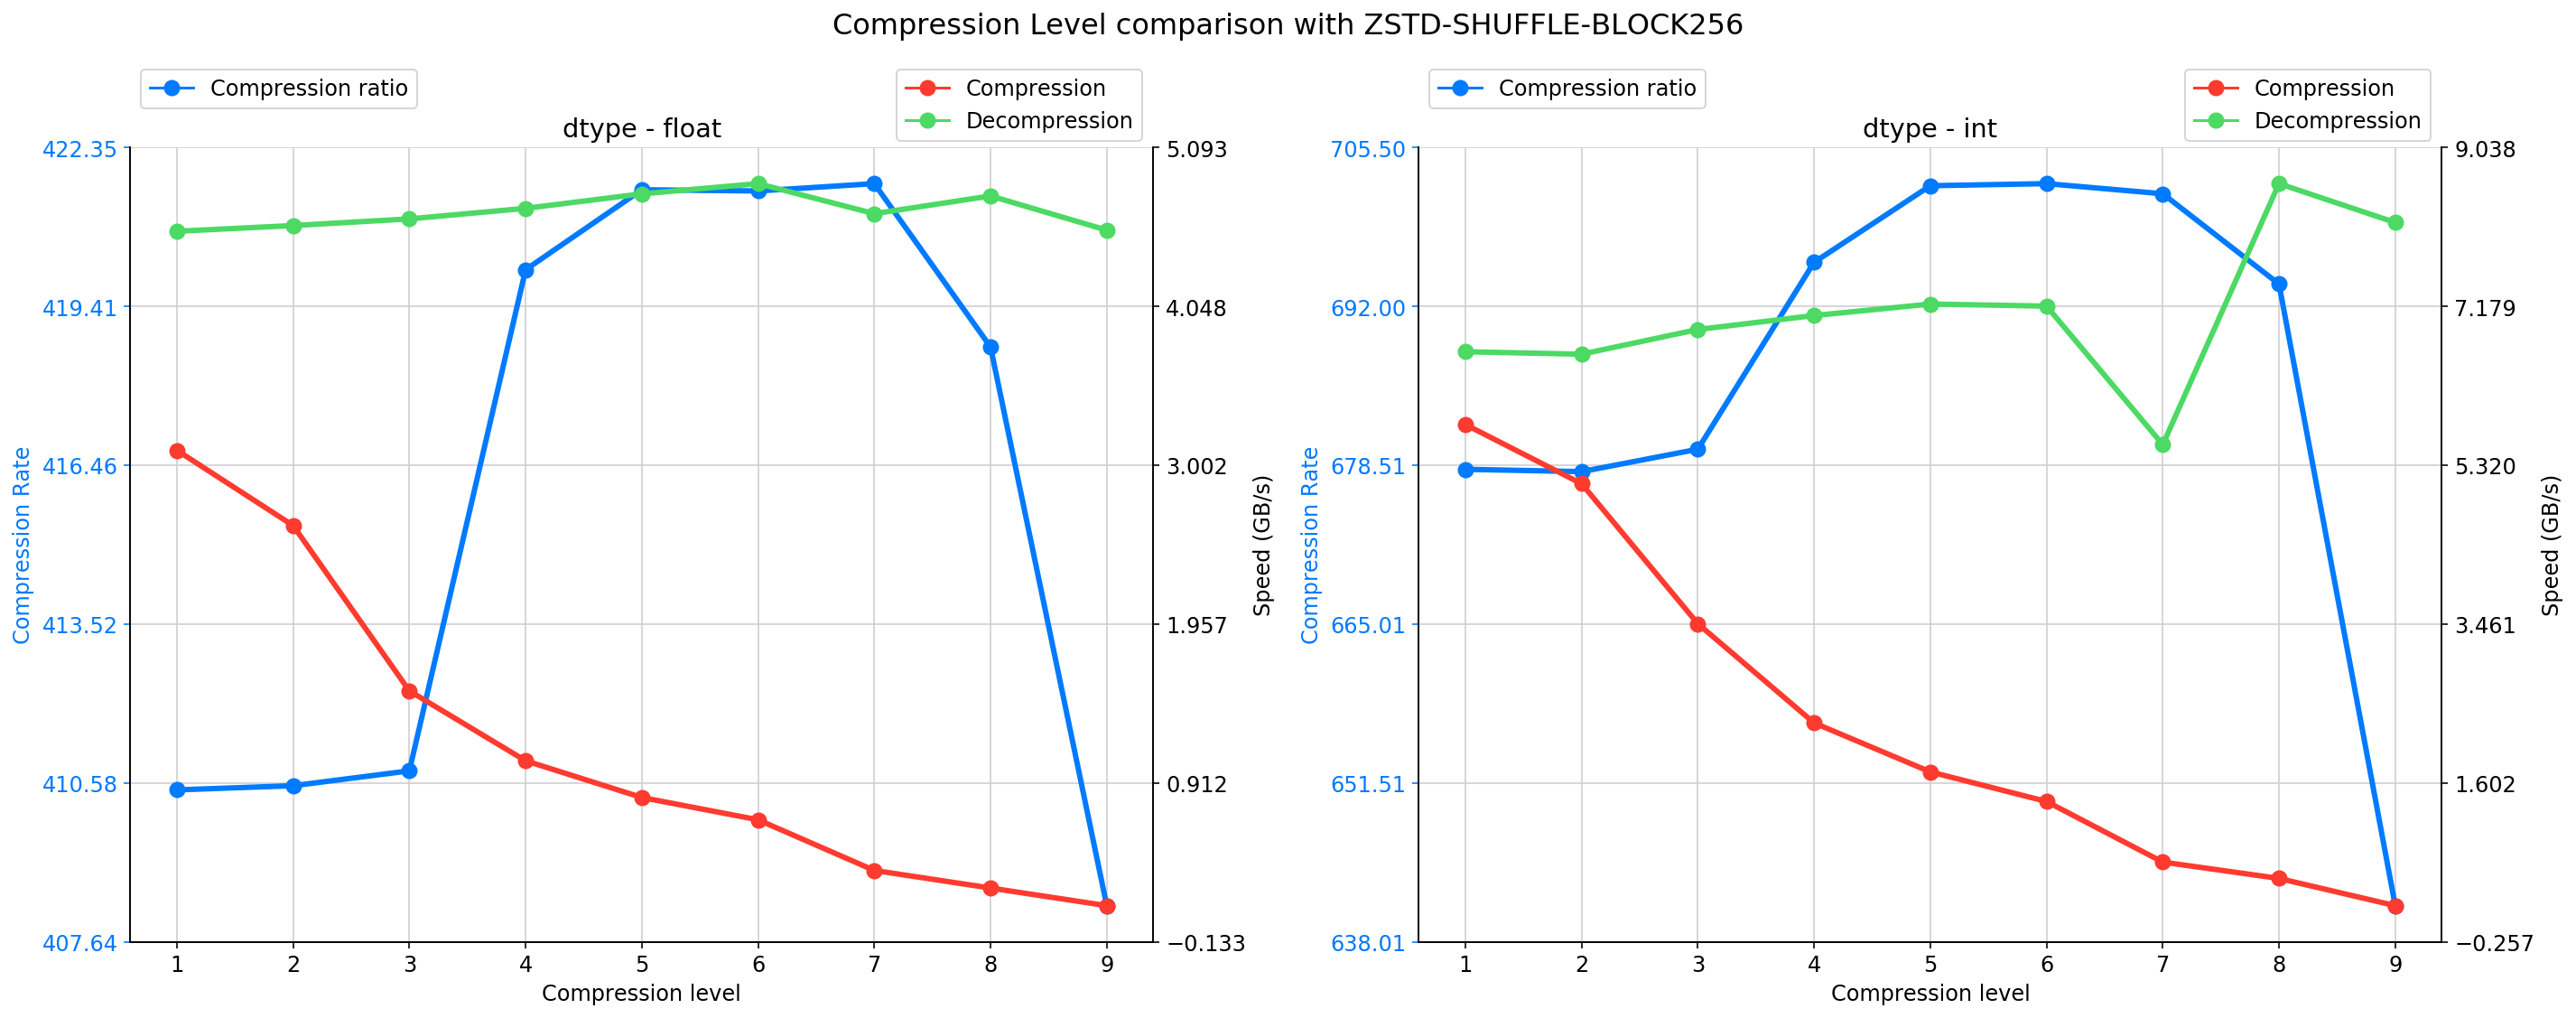

In [14]:
# BLOCK SIZE --> CL
cst.paint_all_block_cor(my_df, 'shuffle', block_size=256, cl_mode=True)

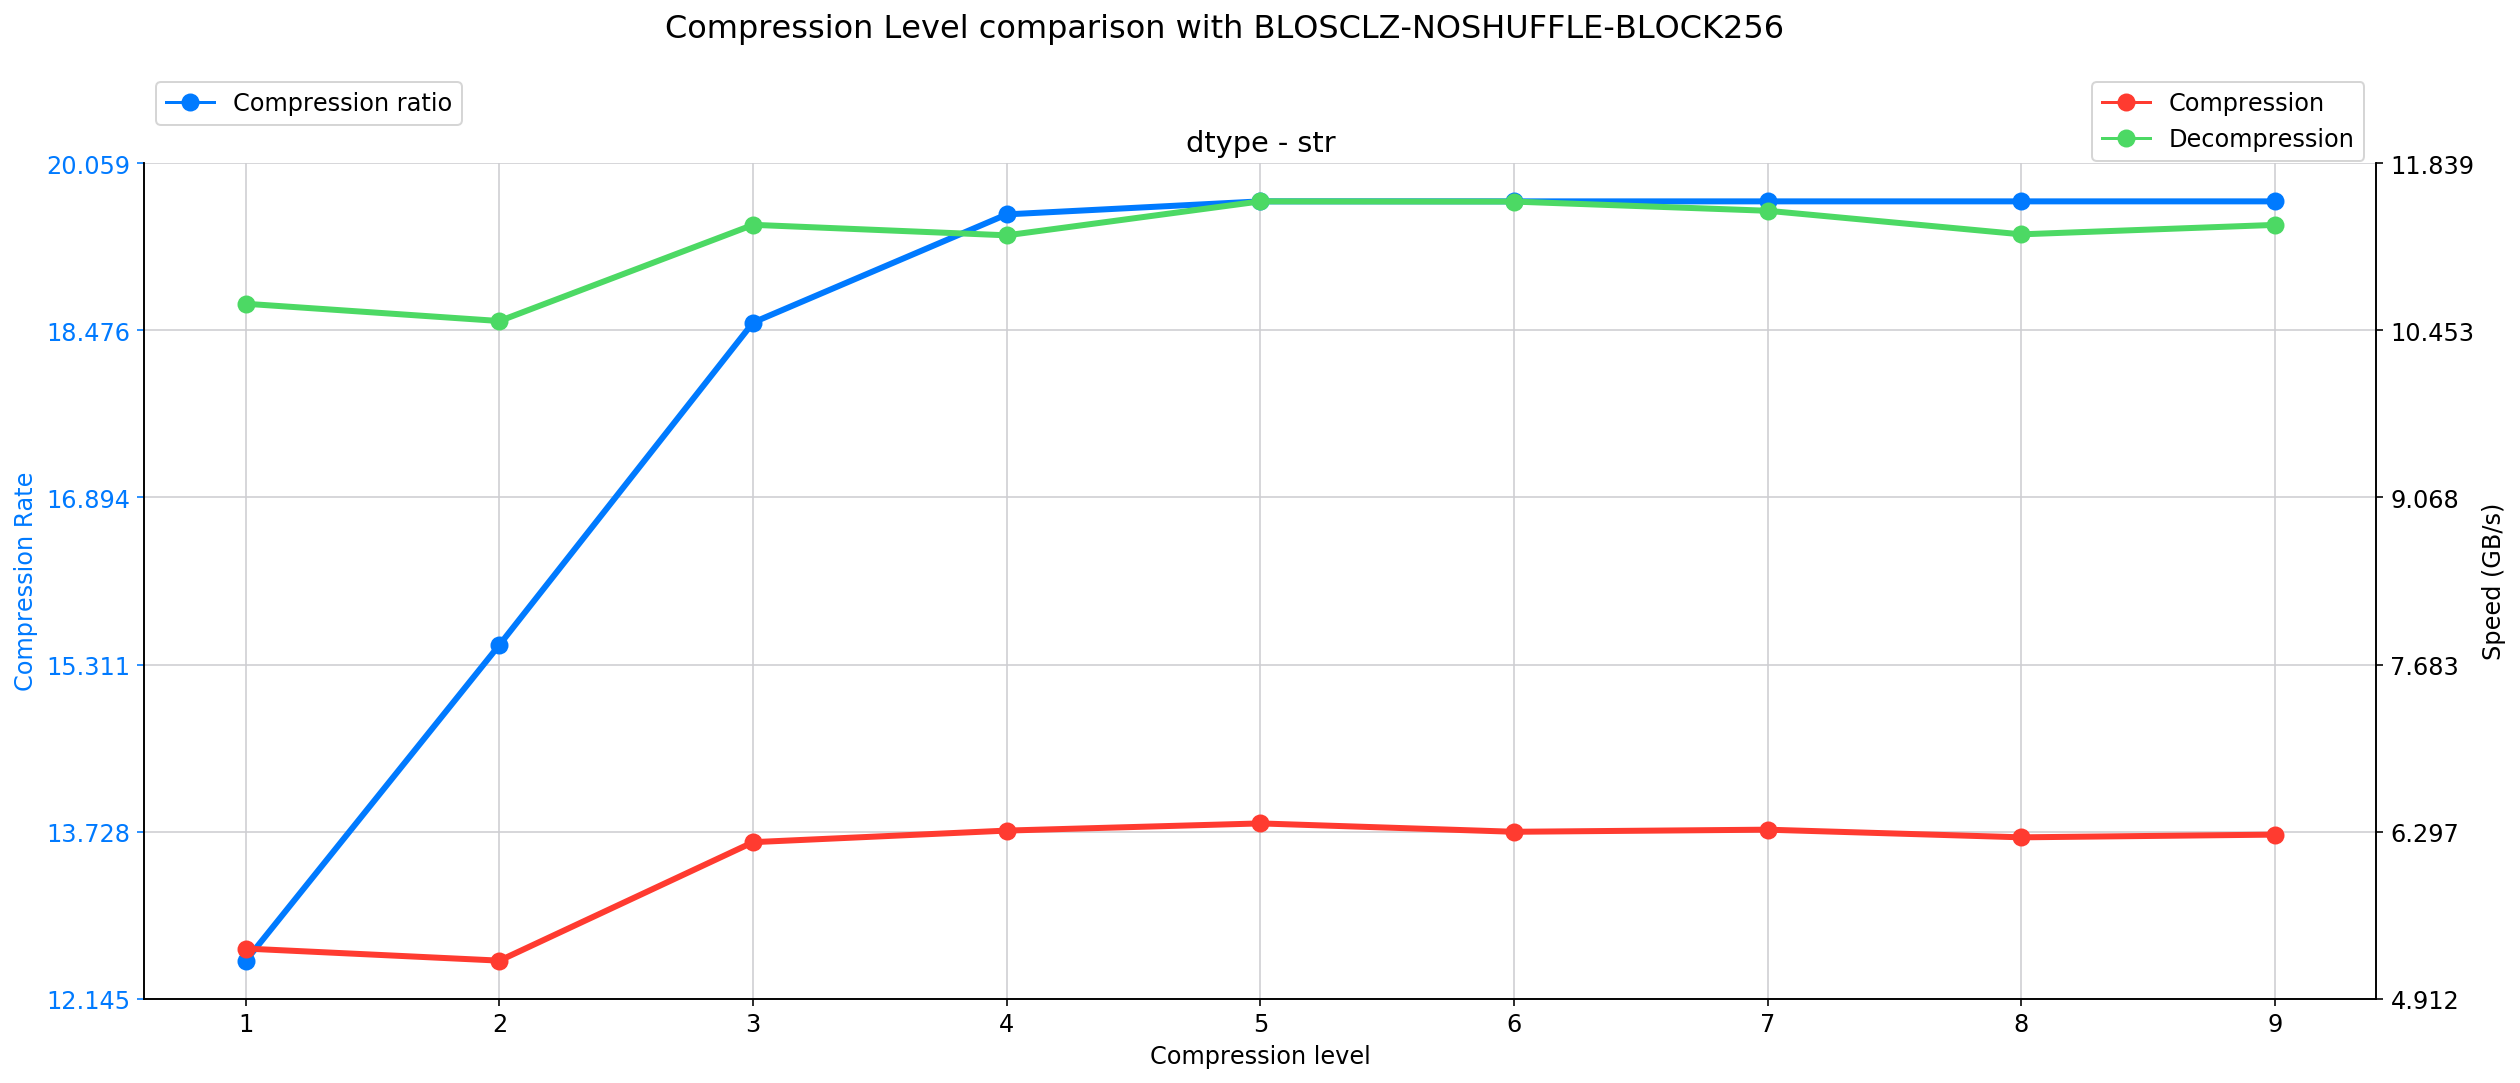

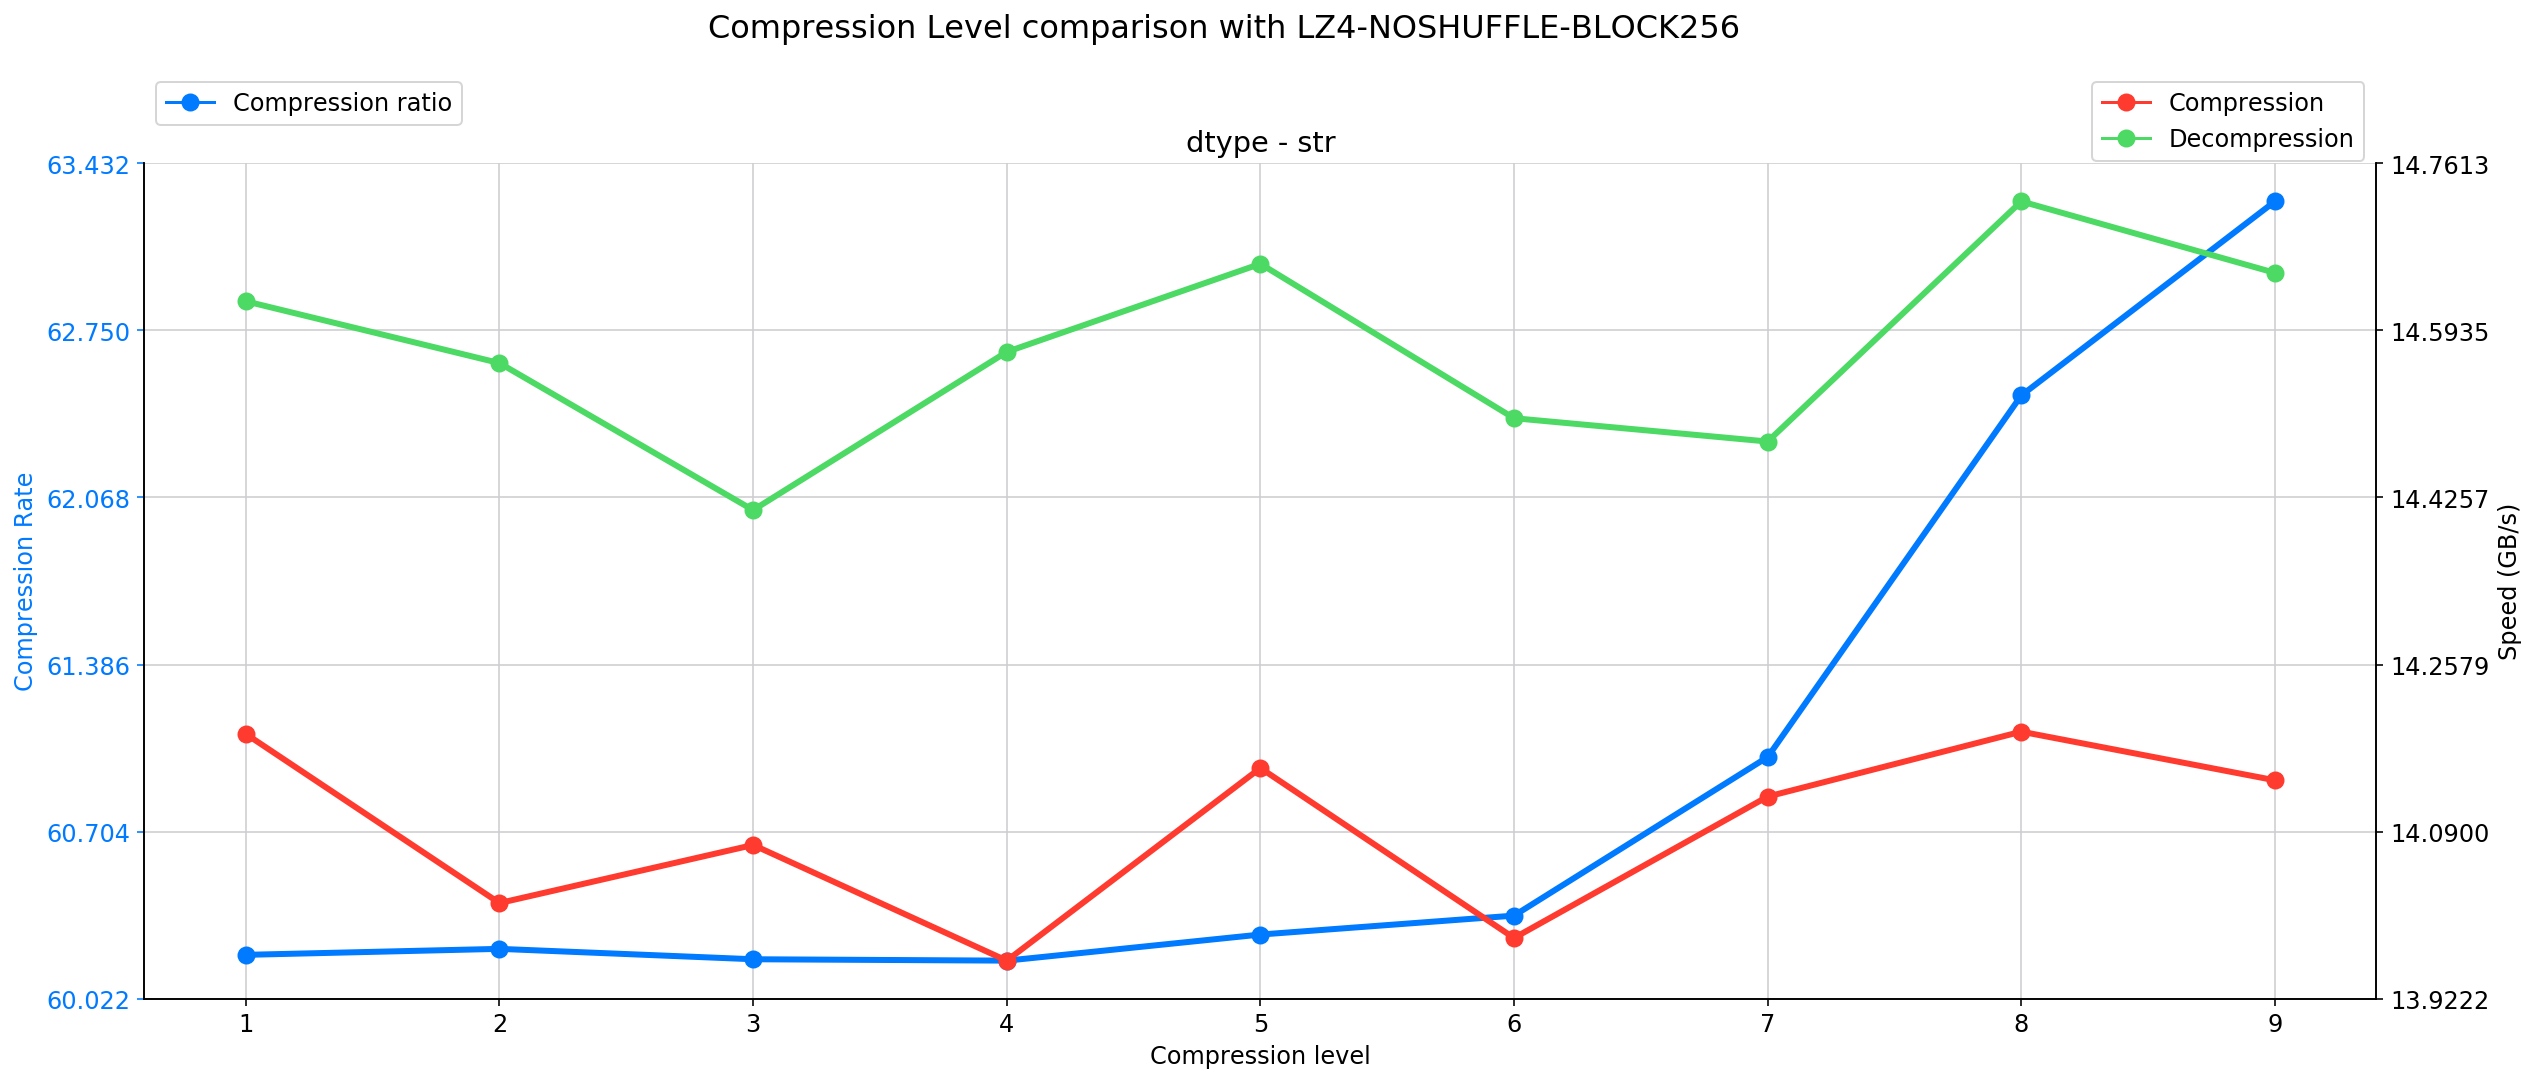

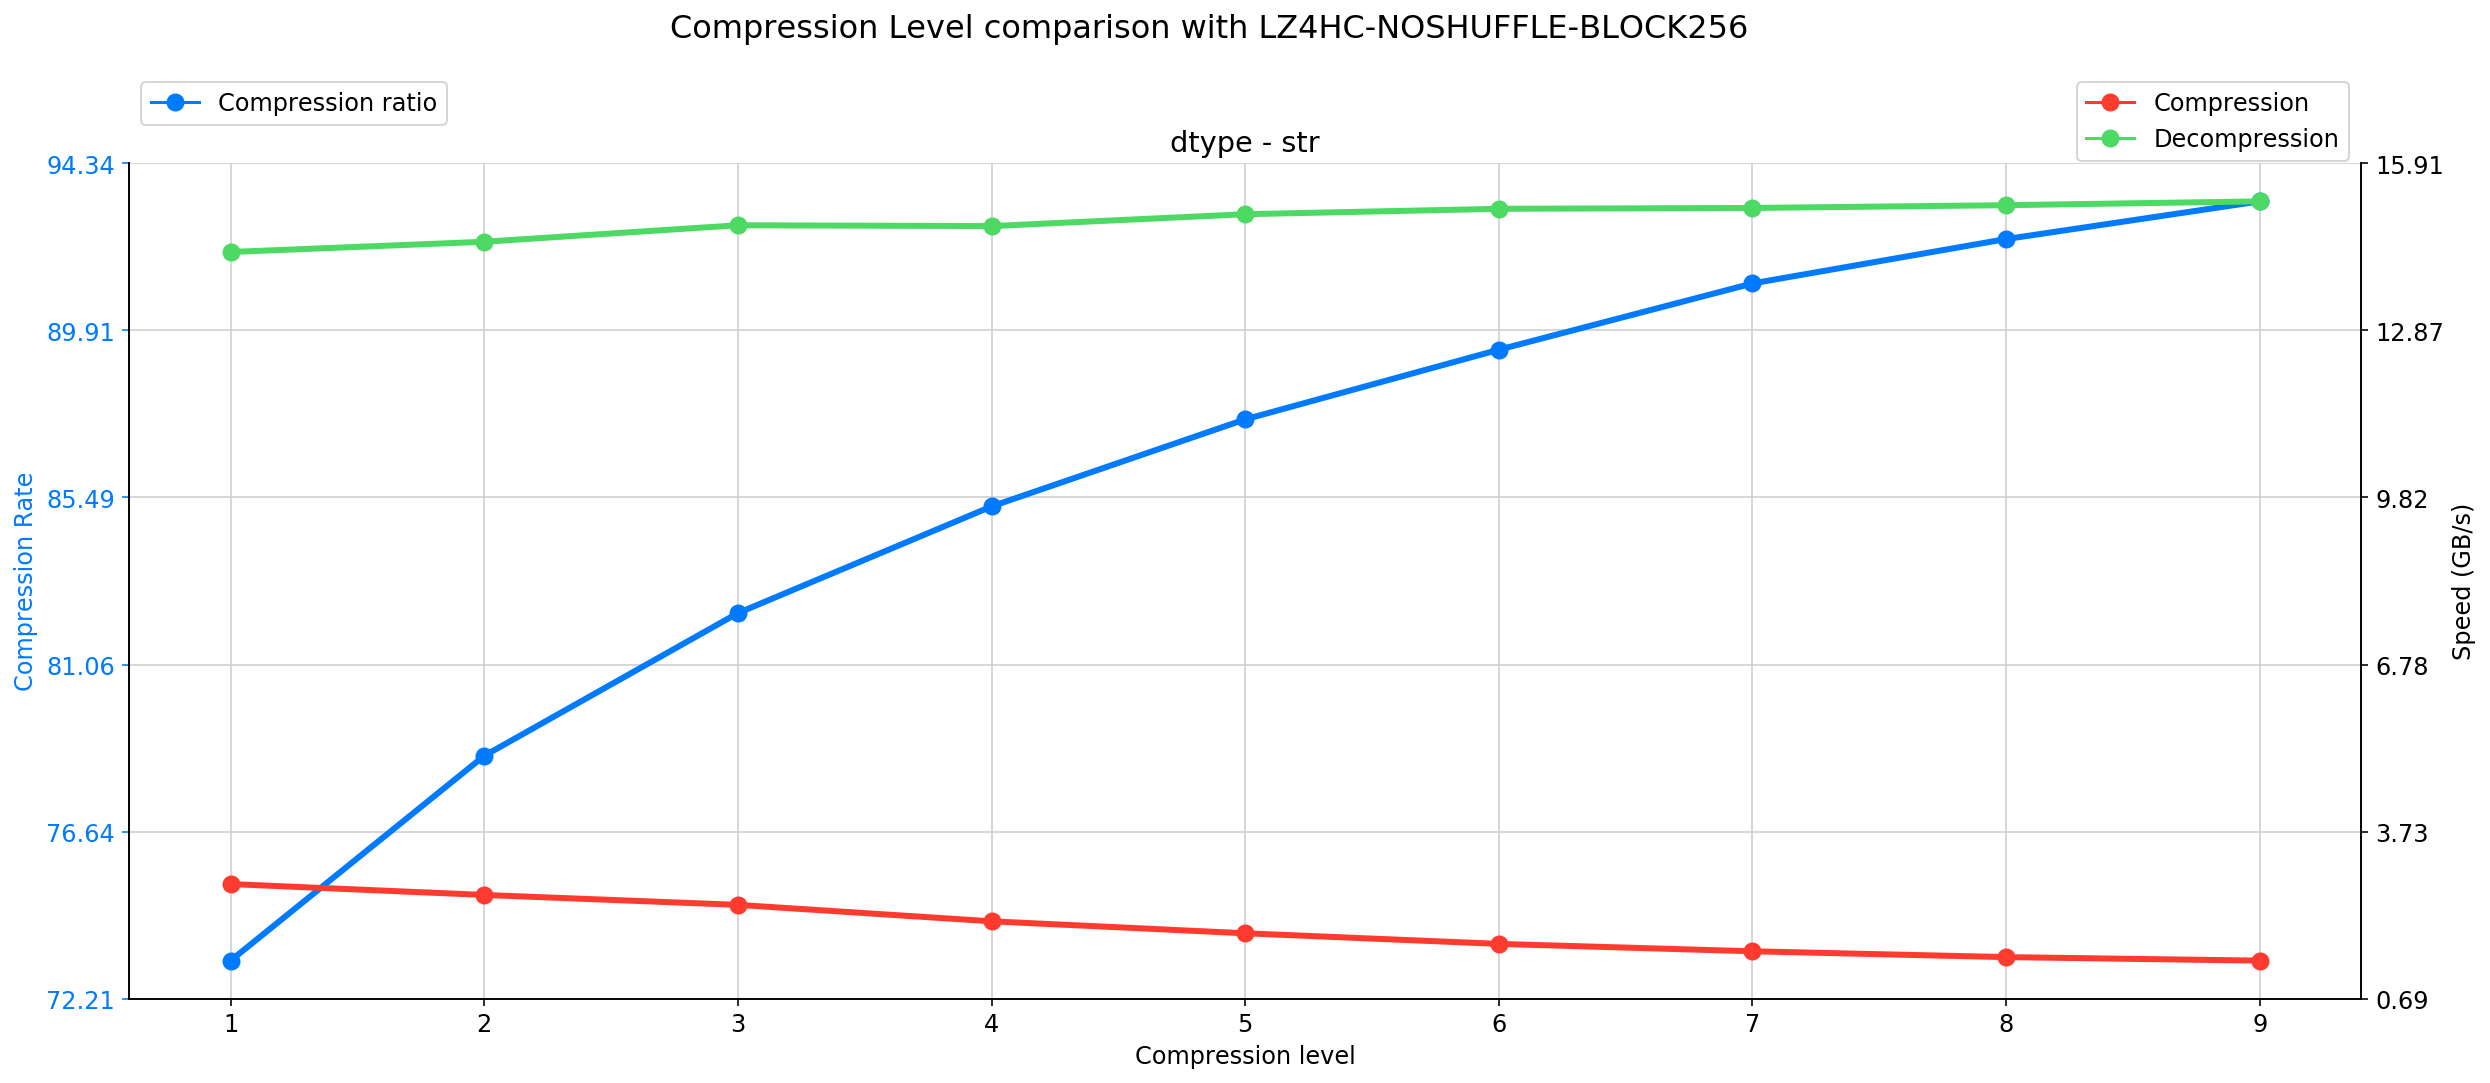

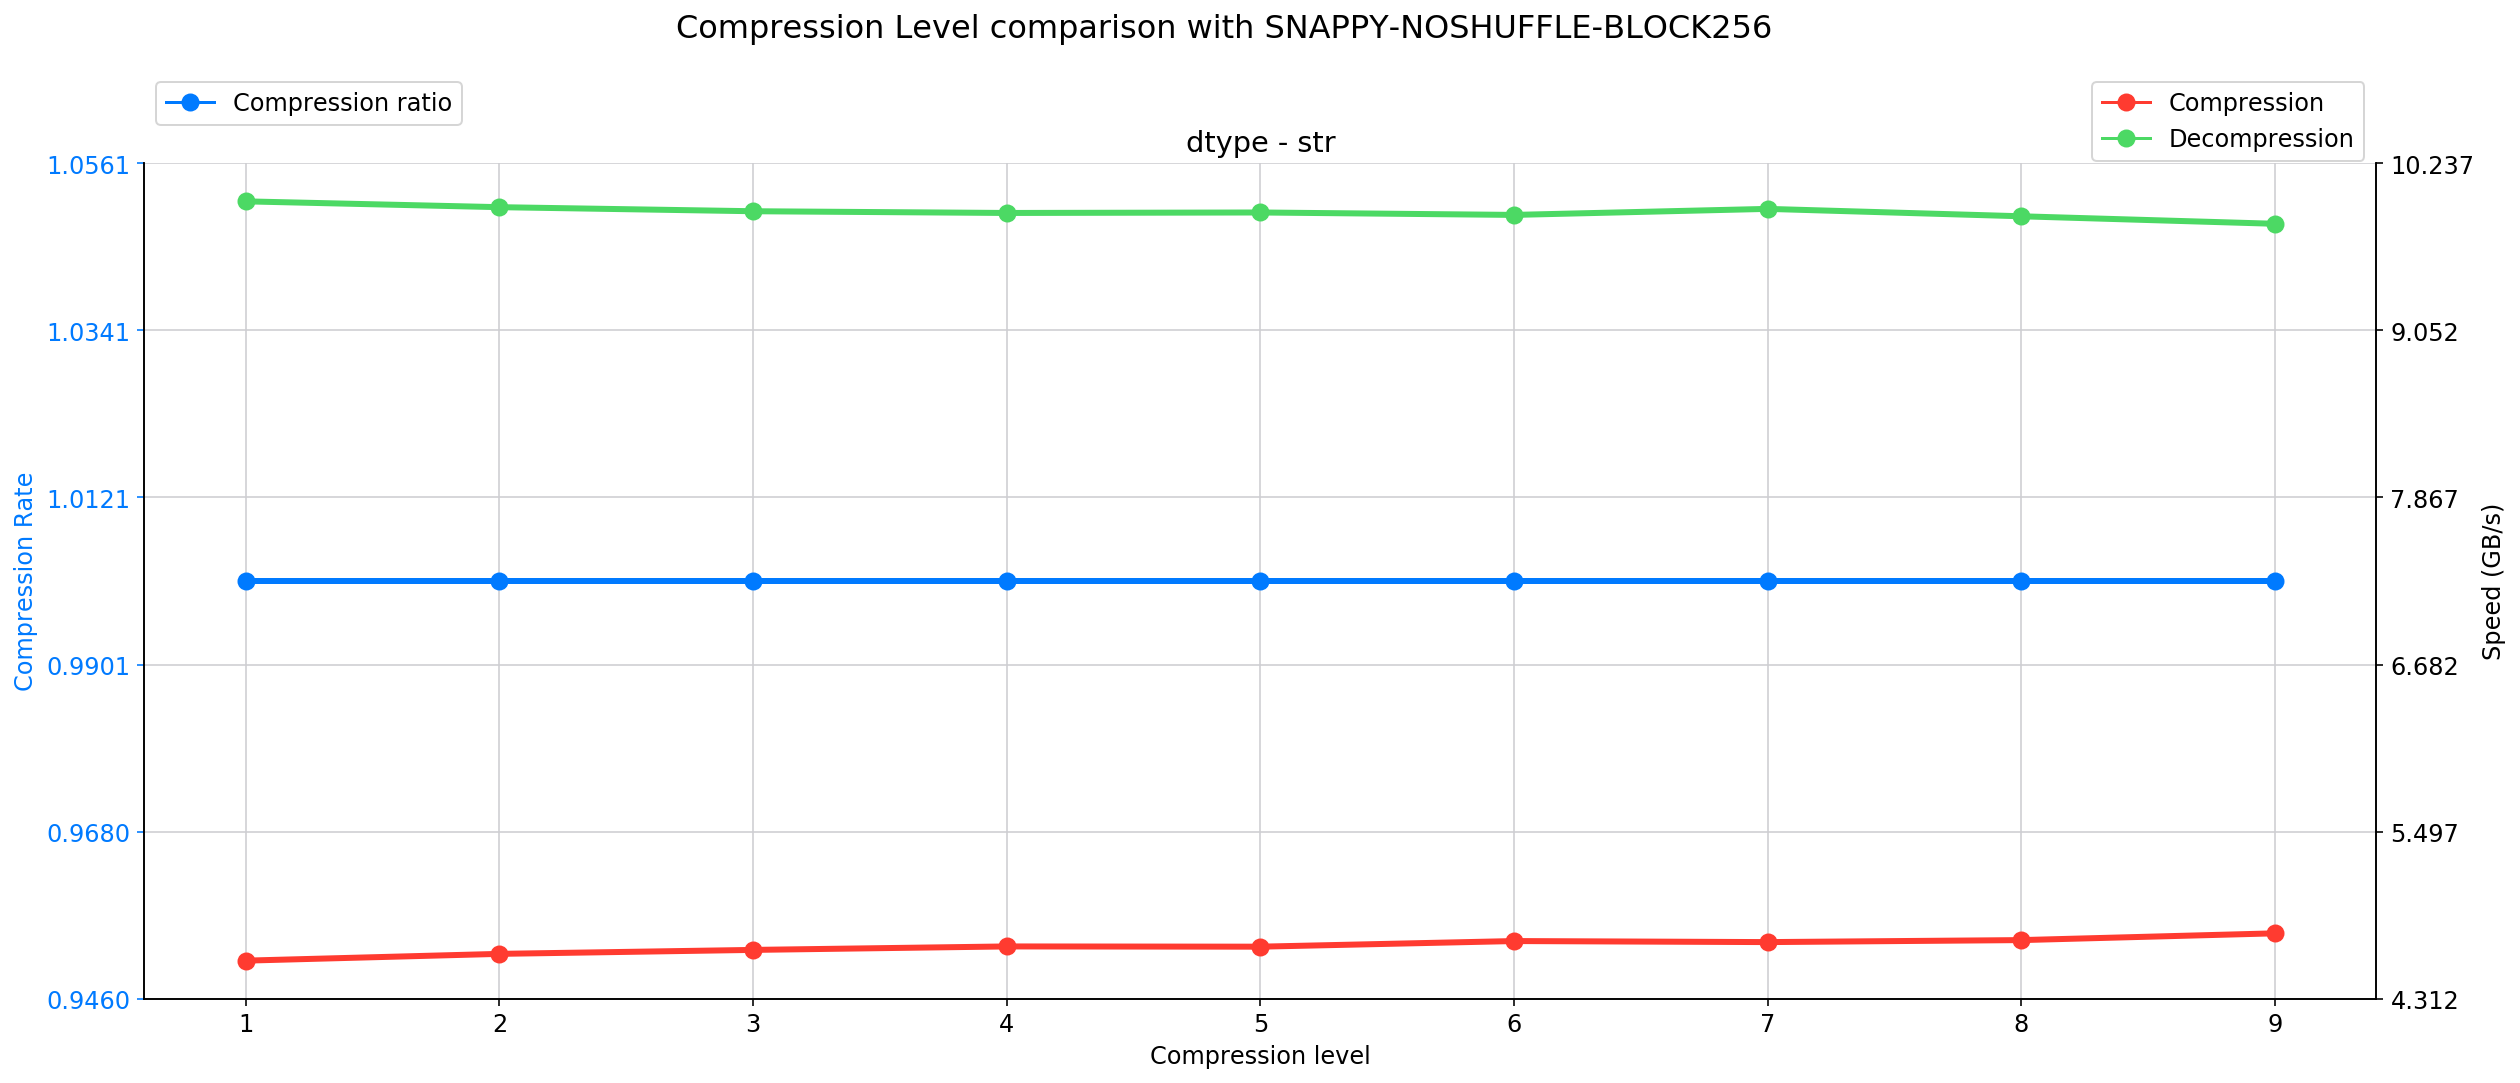

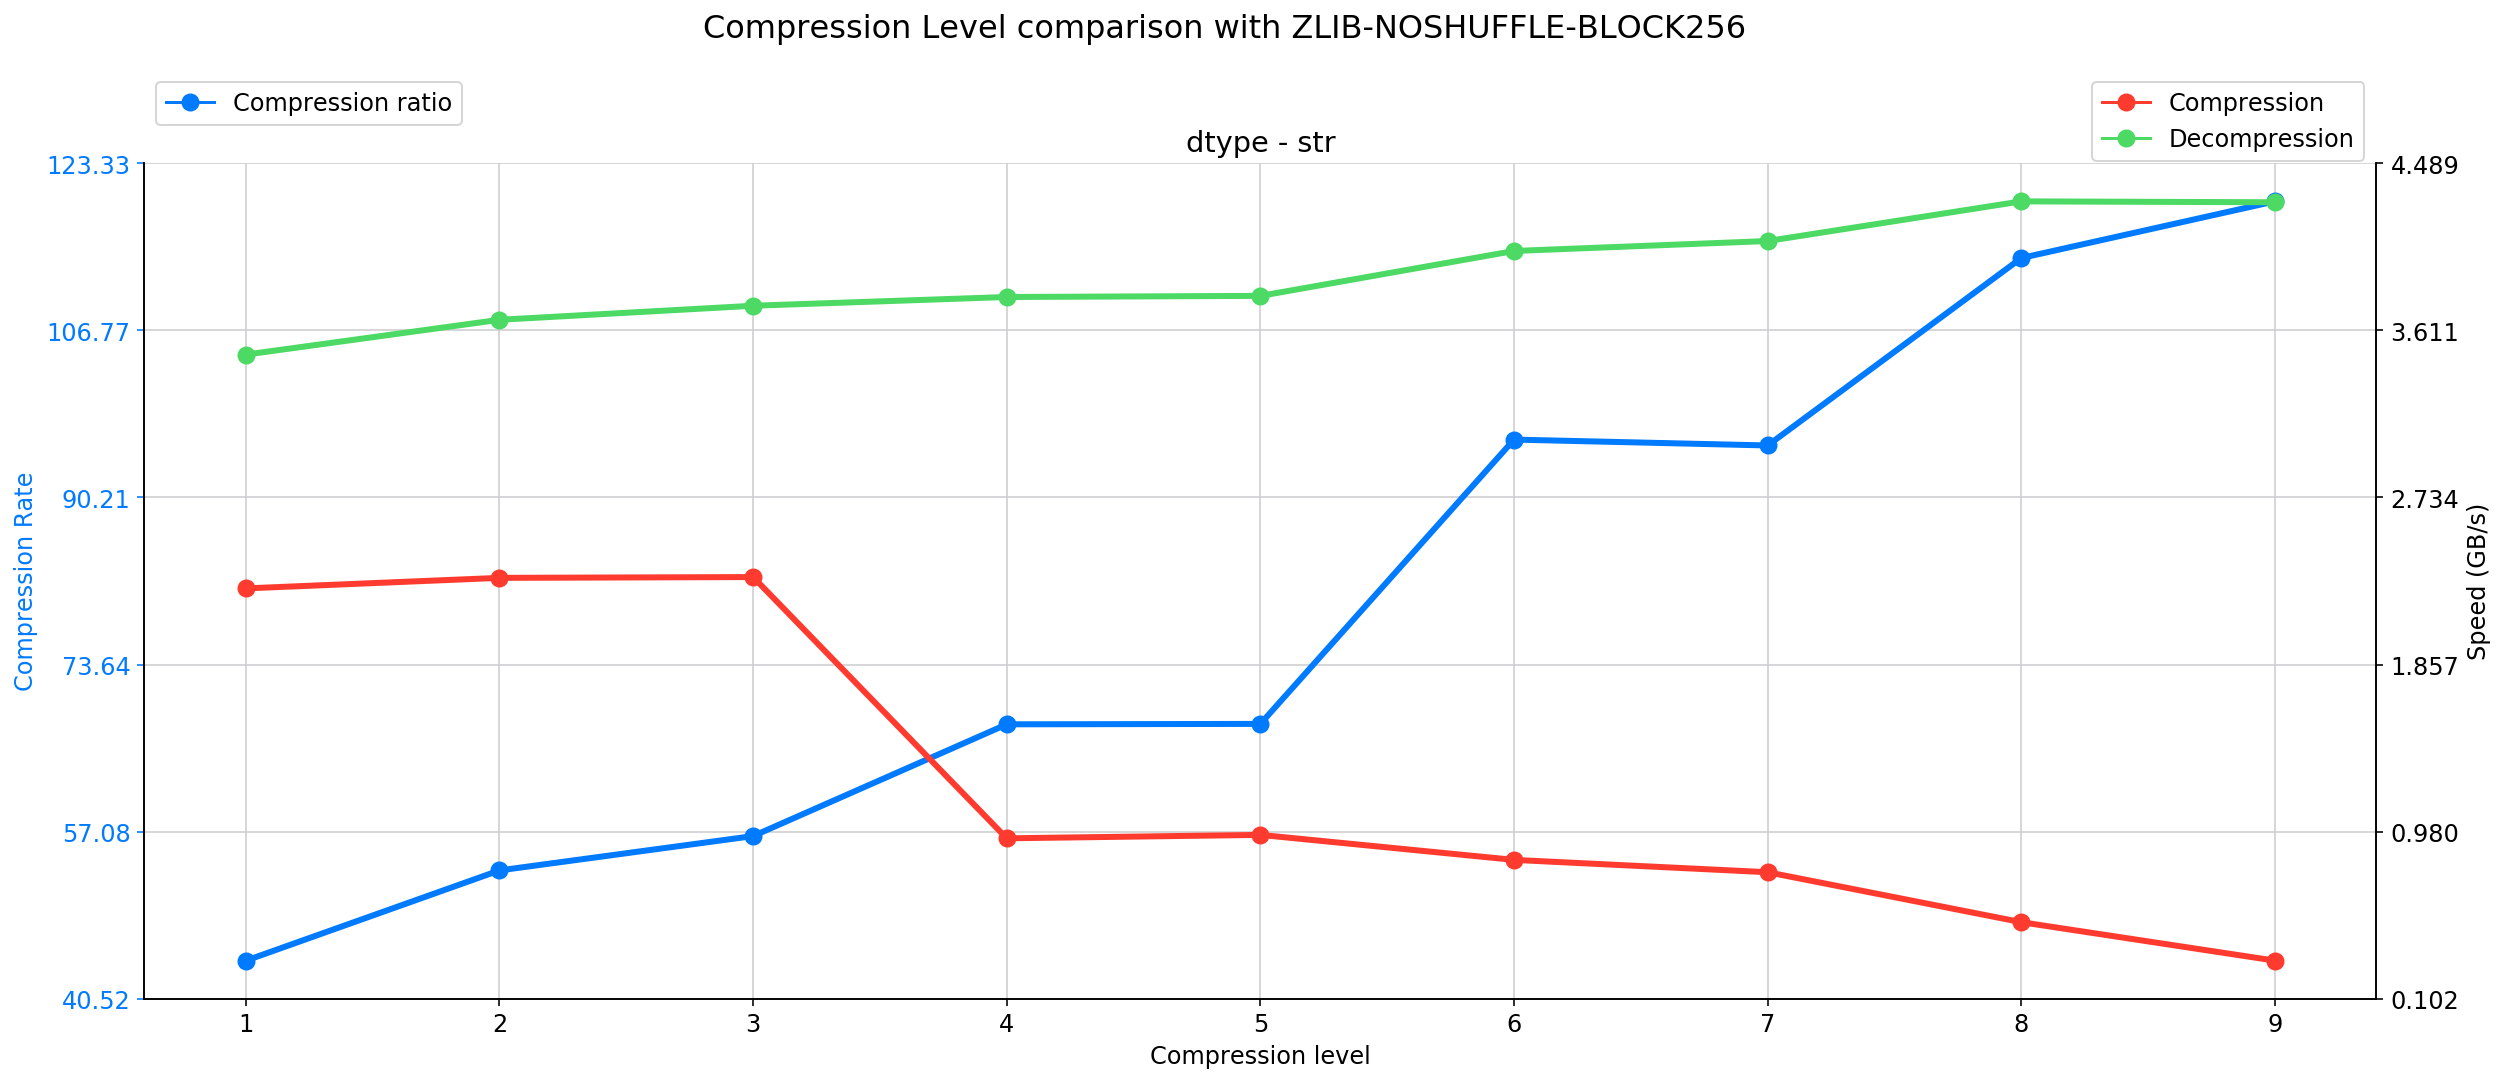

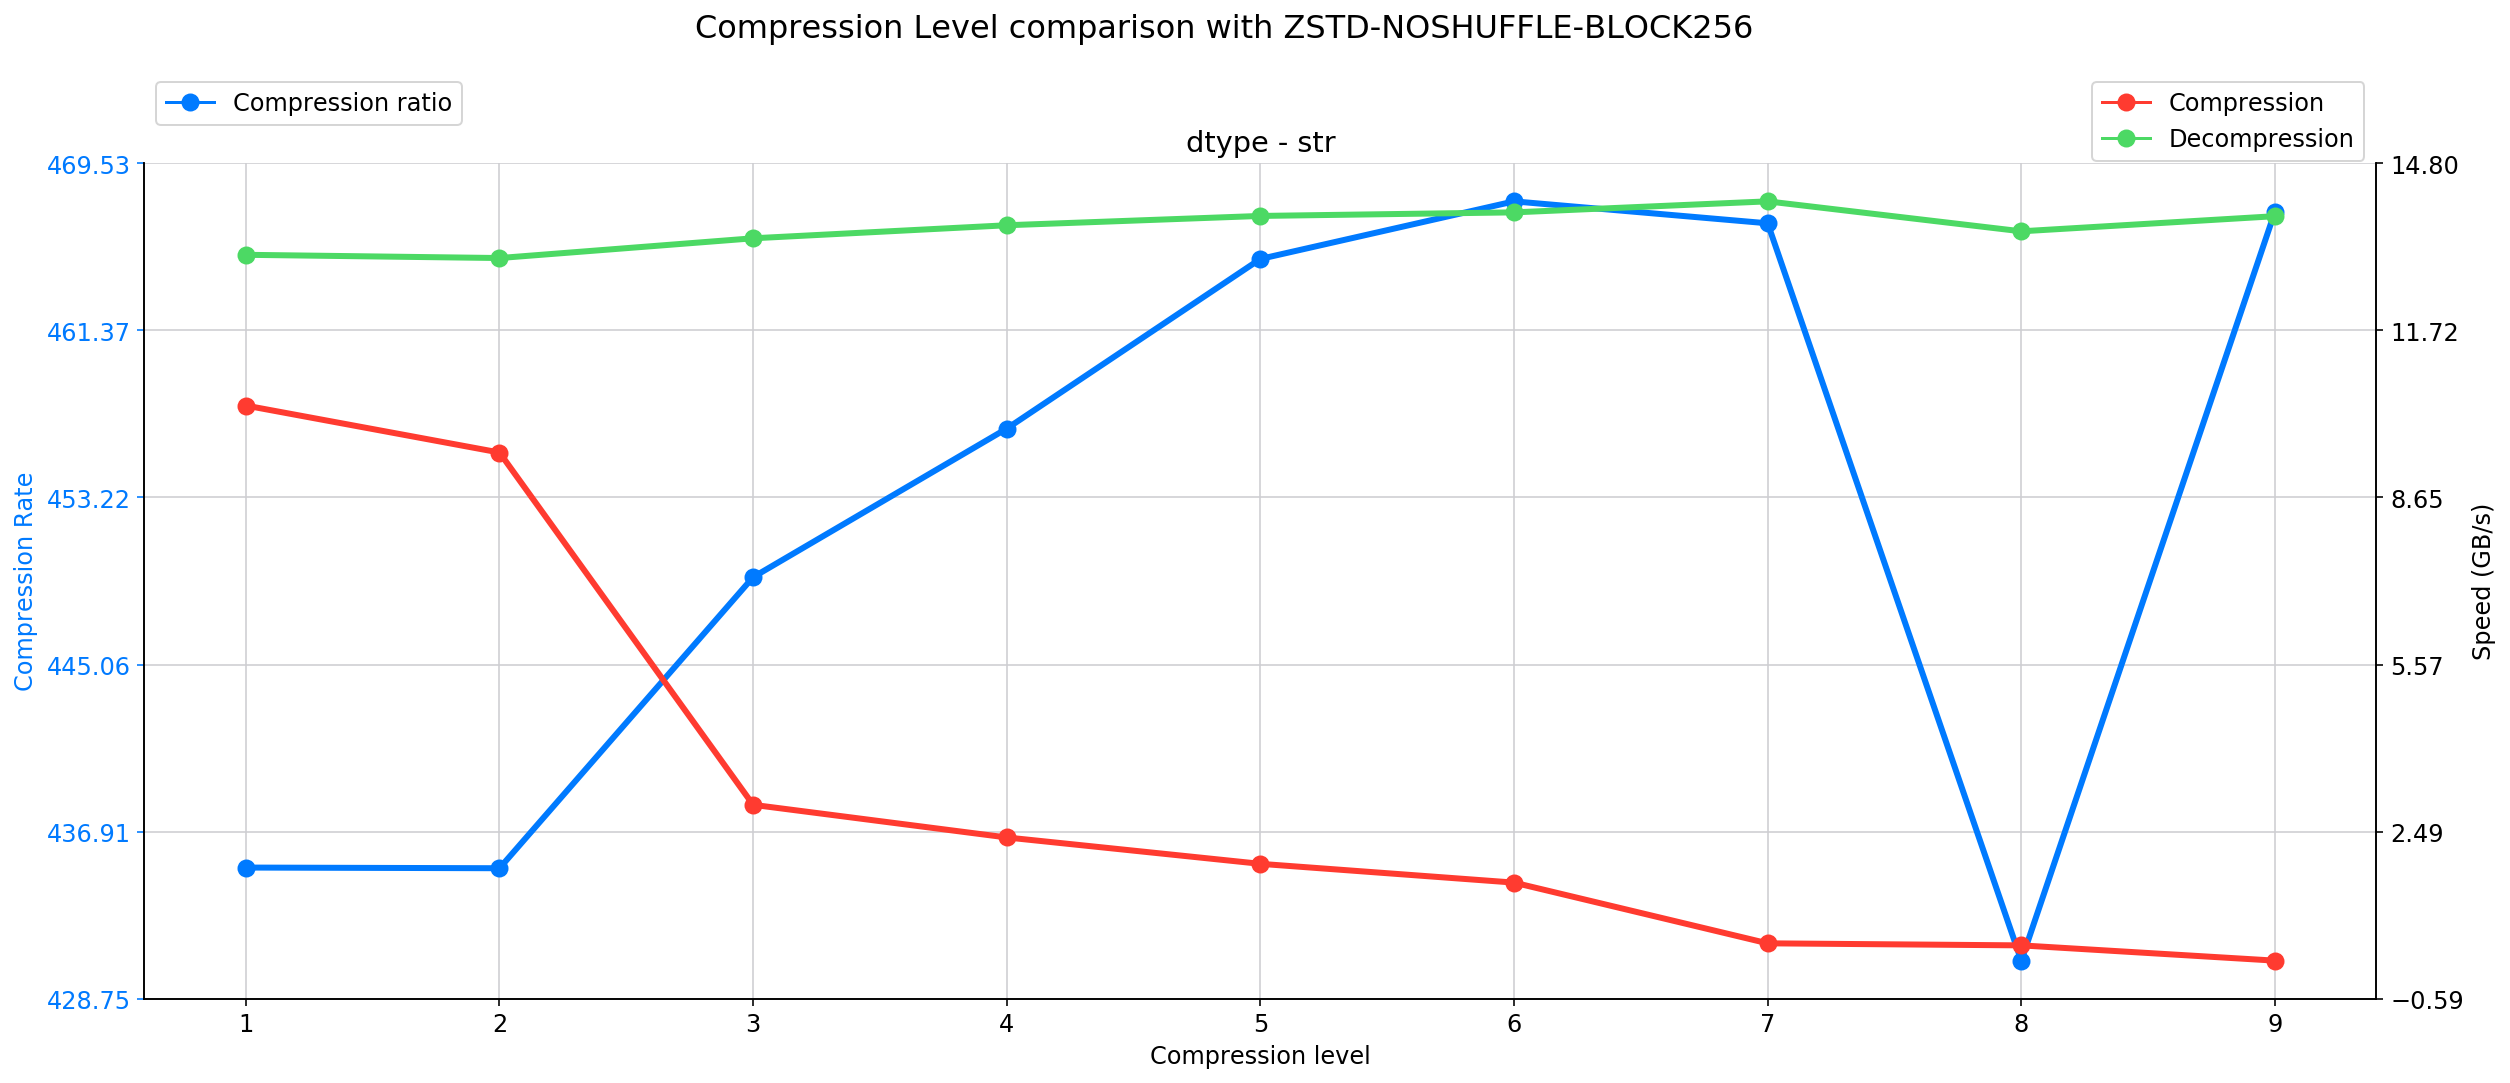

In [15]:
cst.paint_all_block_cor(my_df, 'noshuffle', block_size=256, cl_mode=True)

## Tablas columnares VS Tablas normales
En el caso de que los datos esten en forma de tabla, si la tabla contiene más de una columna se realizan dos pruebas de compresión, una guardando los datos como tabla normal, fila por fila y otra guardándolos columnarmente.

In [16]:
df_col = my_df[my_df.Table == 2]
if df_col.size > 0:
    sets = df_col.drop_duplicates(subset=['DataSet'])
    for dataset in sets['DataSet']:
        dfaux = my_df[my_df.DataSet == dataset]
        normal_table = dfaux[dfaux.Table == 1][cst.TEST_FEATURES]
        normal_table.columns = ['N_CRate', 'N_CSpeed', 'N_DSpeed']
        col_table = dfaux[dfaux.Table == 2][cst.TEST_FEATURES]
        col_table.columns = ['COL_CRate', 'COL_CSpeed', 'COL_DSpeed']
        result = pd.concat([normal_table, col_table])
        result = result[['N_CRate', 'COL_CRate', 'N_CSpeed', 'COL_CSpeed','N_DSpeed', 'COL_DSpeed']]
        print(sets[sets.DataSet == dataset][cst.DESC_SET])
        display(result.describe())

                            DataSet    DType  Table  Chunk_Size
1001160  /msft/table.values_block_0  float64  2.000      16.000


N_CRate  COL_CRate  N_CSpeed  COL_CSpeed  N_DSpeed  COL_DSpeed
count 9,720.000  9,720.000 9,720.000   9,720.000 9,720.000   9,720.000
mean     10.462     17.942     1.840       2.016     5.685       4.757
std       7.310     33.079     1.959       2.131     4.262       3.132
min       1.000      1.000     0.002       0.002     0.369       0.361
25%       4.342      5.133     0.398       0.392     2.550       2.527
50%       8.844      8.050     1.196       1.433     4.122       4.010
75%      14.532     15.924     2.503       2.987     7.891       6.330
max      39.004    297.005     9.296      14.213    29.984      29.984

                            DataSet DType  Table  Chunk_Size
1025460  /msft/table.values_block_2  |S49  2.000      16.000


N_CRate  COL_CRate   N_CSpeed  COL_CSpeed   N_DSpeed  COL_DSpeed
count 12,960.000 12,960.000 12,960.000  12,960.000 12,960.000  12,960.000
mean      52.373    147.258      4.985       5.591     11.729      11.048
std       45.062    737.652      4.778       5.360      4.194       3.841
min        1.000      1.000      0.005       0.007      1.749       1.953
25%        7.624     21.154      1.081       1.008      9.844       9.404
50%       46.981     47.146      3.405       3.806     13.373      12.361
75%       72.699     86.410      8.698       9.543     14.908      14.073
max      234.129 10,131.164     17.067      19.993     26.164      22.071

## Correlaciones Blosclz-CL1 VS Otros
Para poder visualizar todas estas correlaciones calculamos directamente el coeficiente de pearson y su p-valor asociado entre los datos de blosclz con nivel de compresión 1 y el resto.

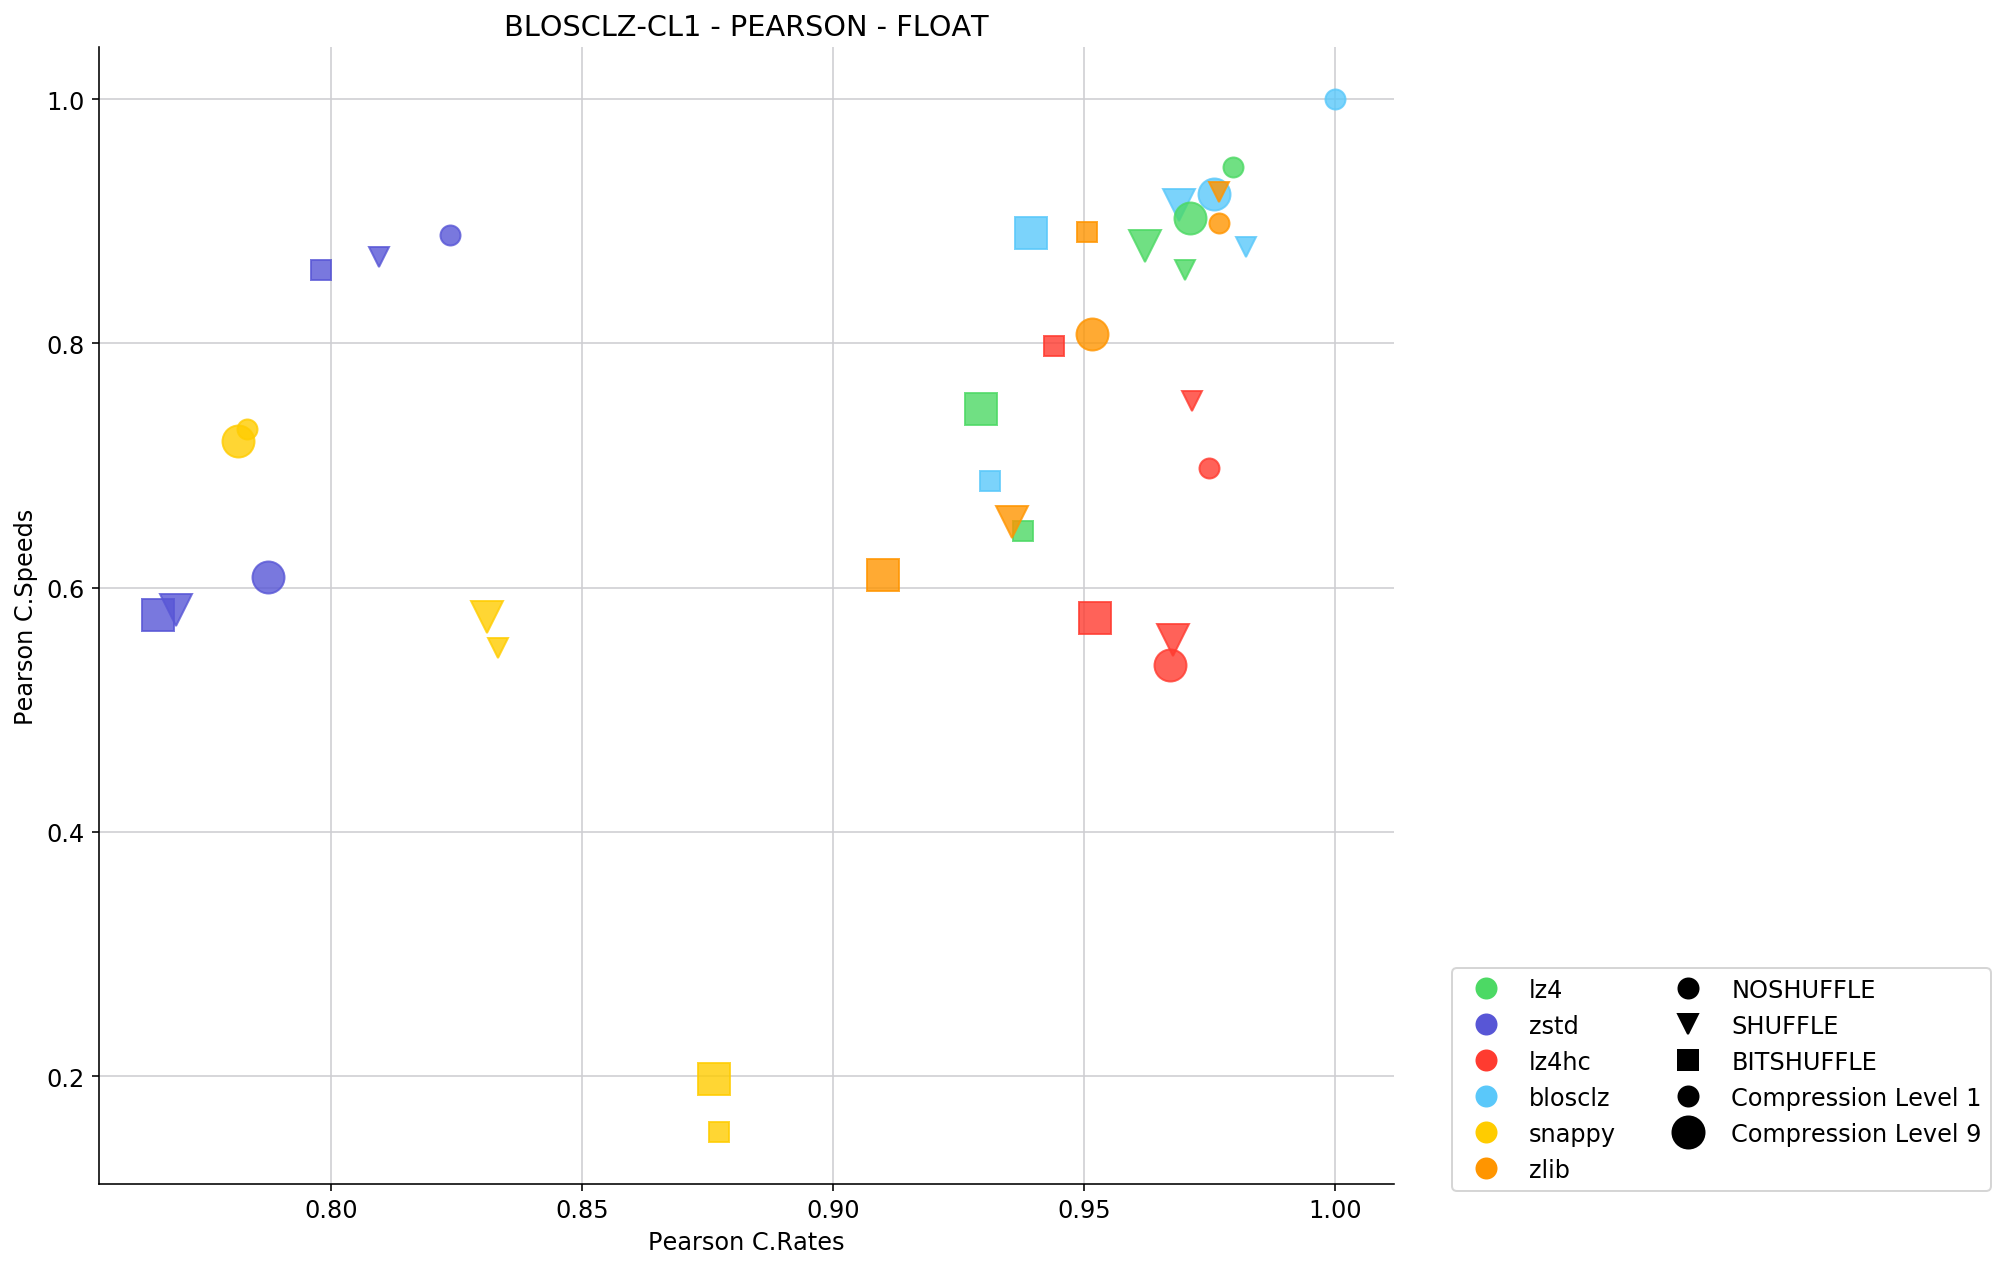

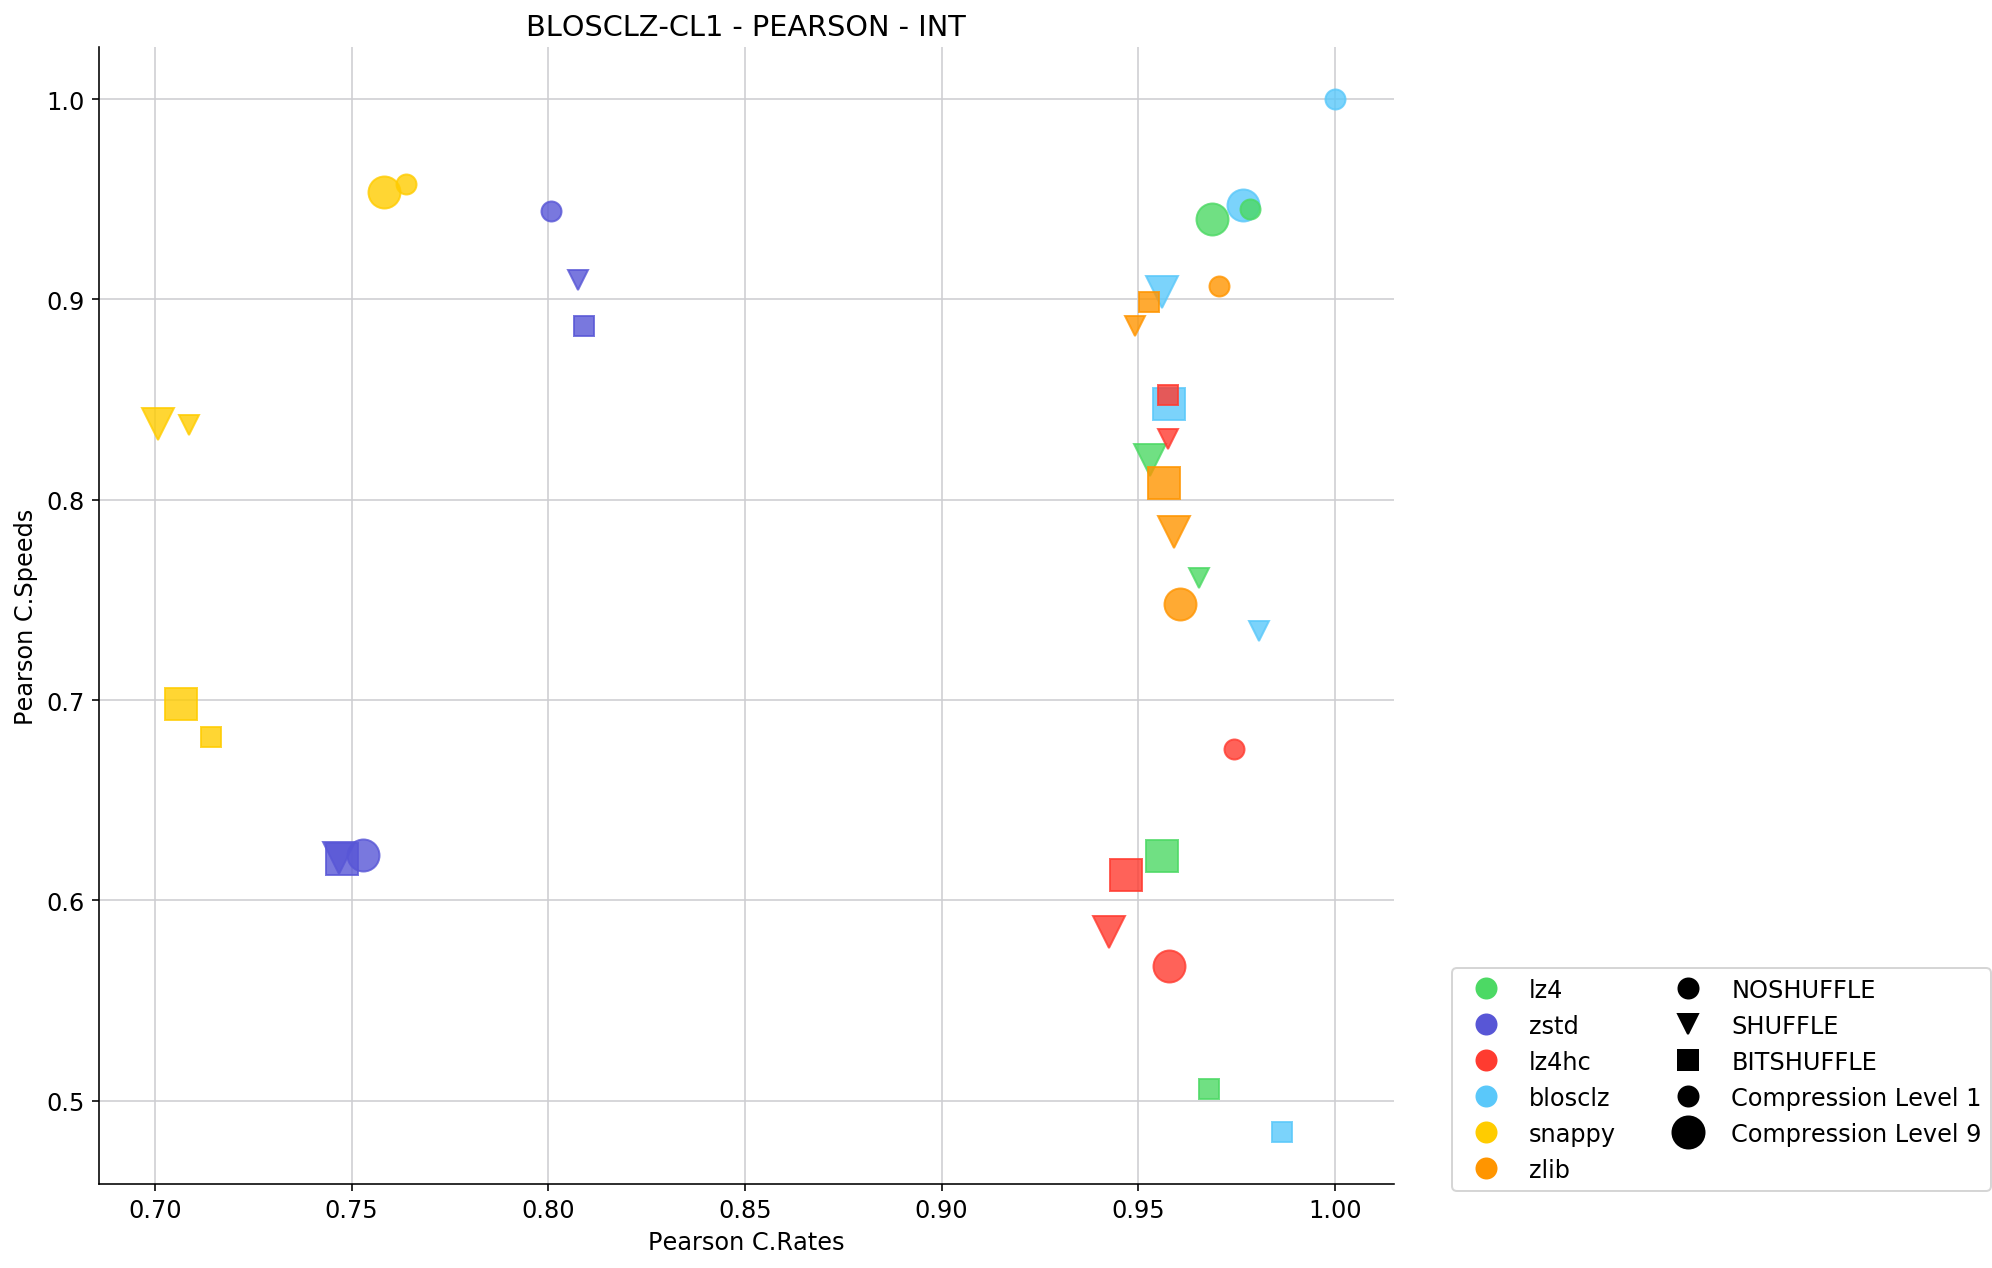

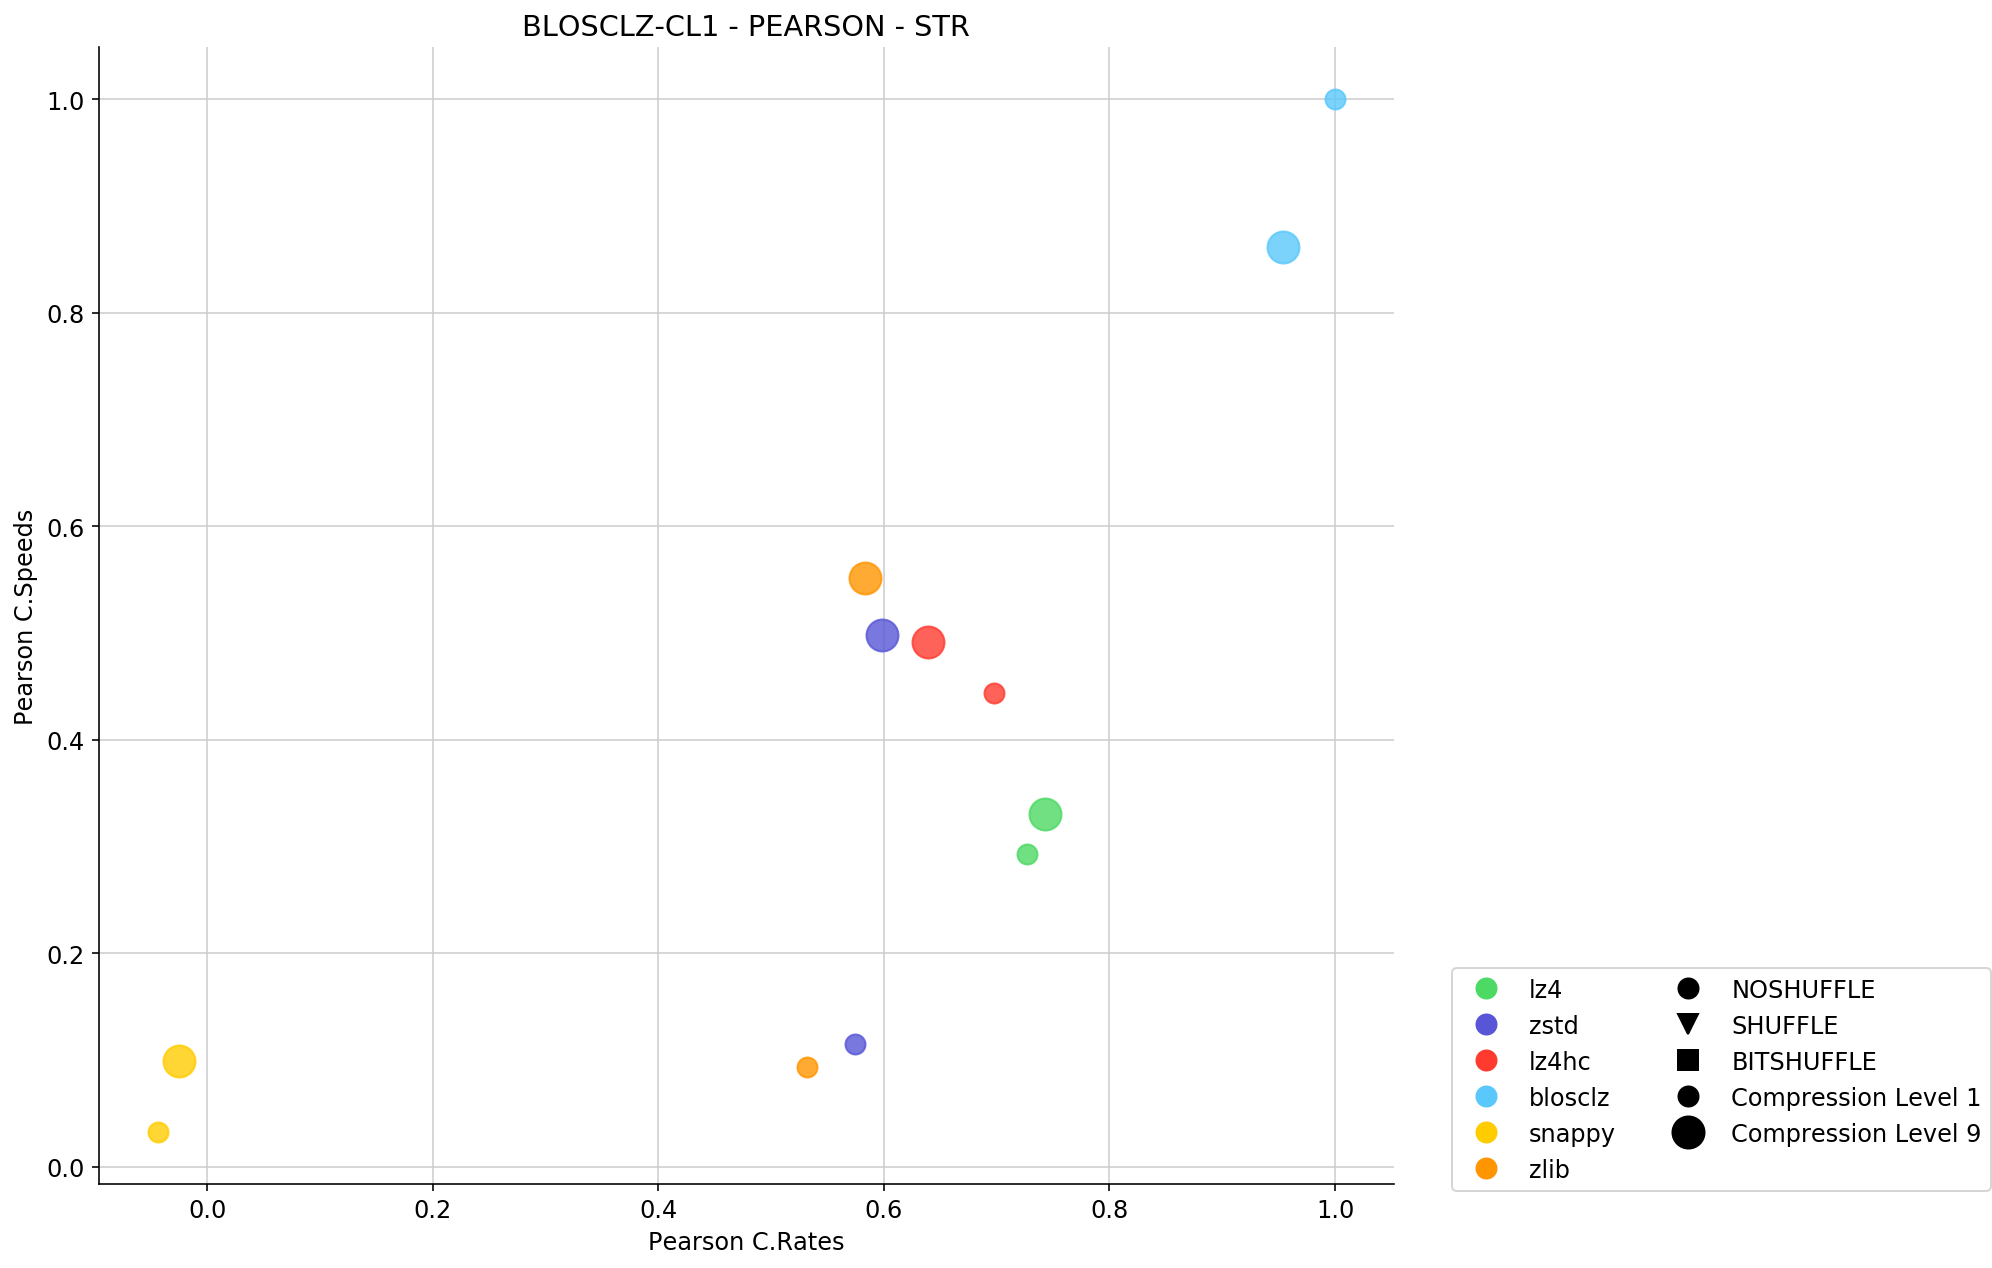

In [17]:
cst.paint_codec_pearson_corr(my_df, 'blosclz', 1)

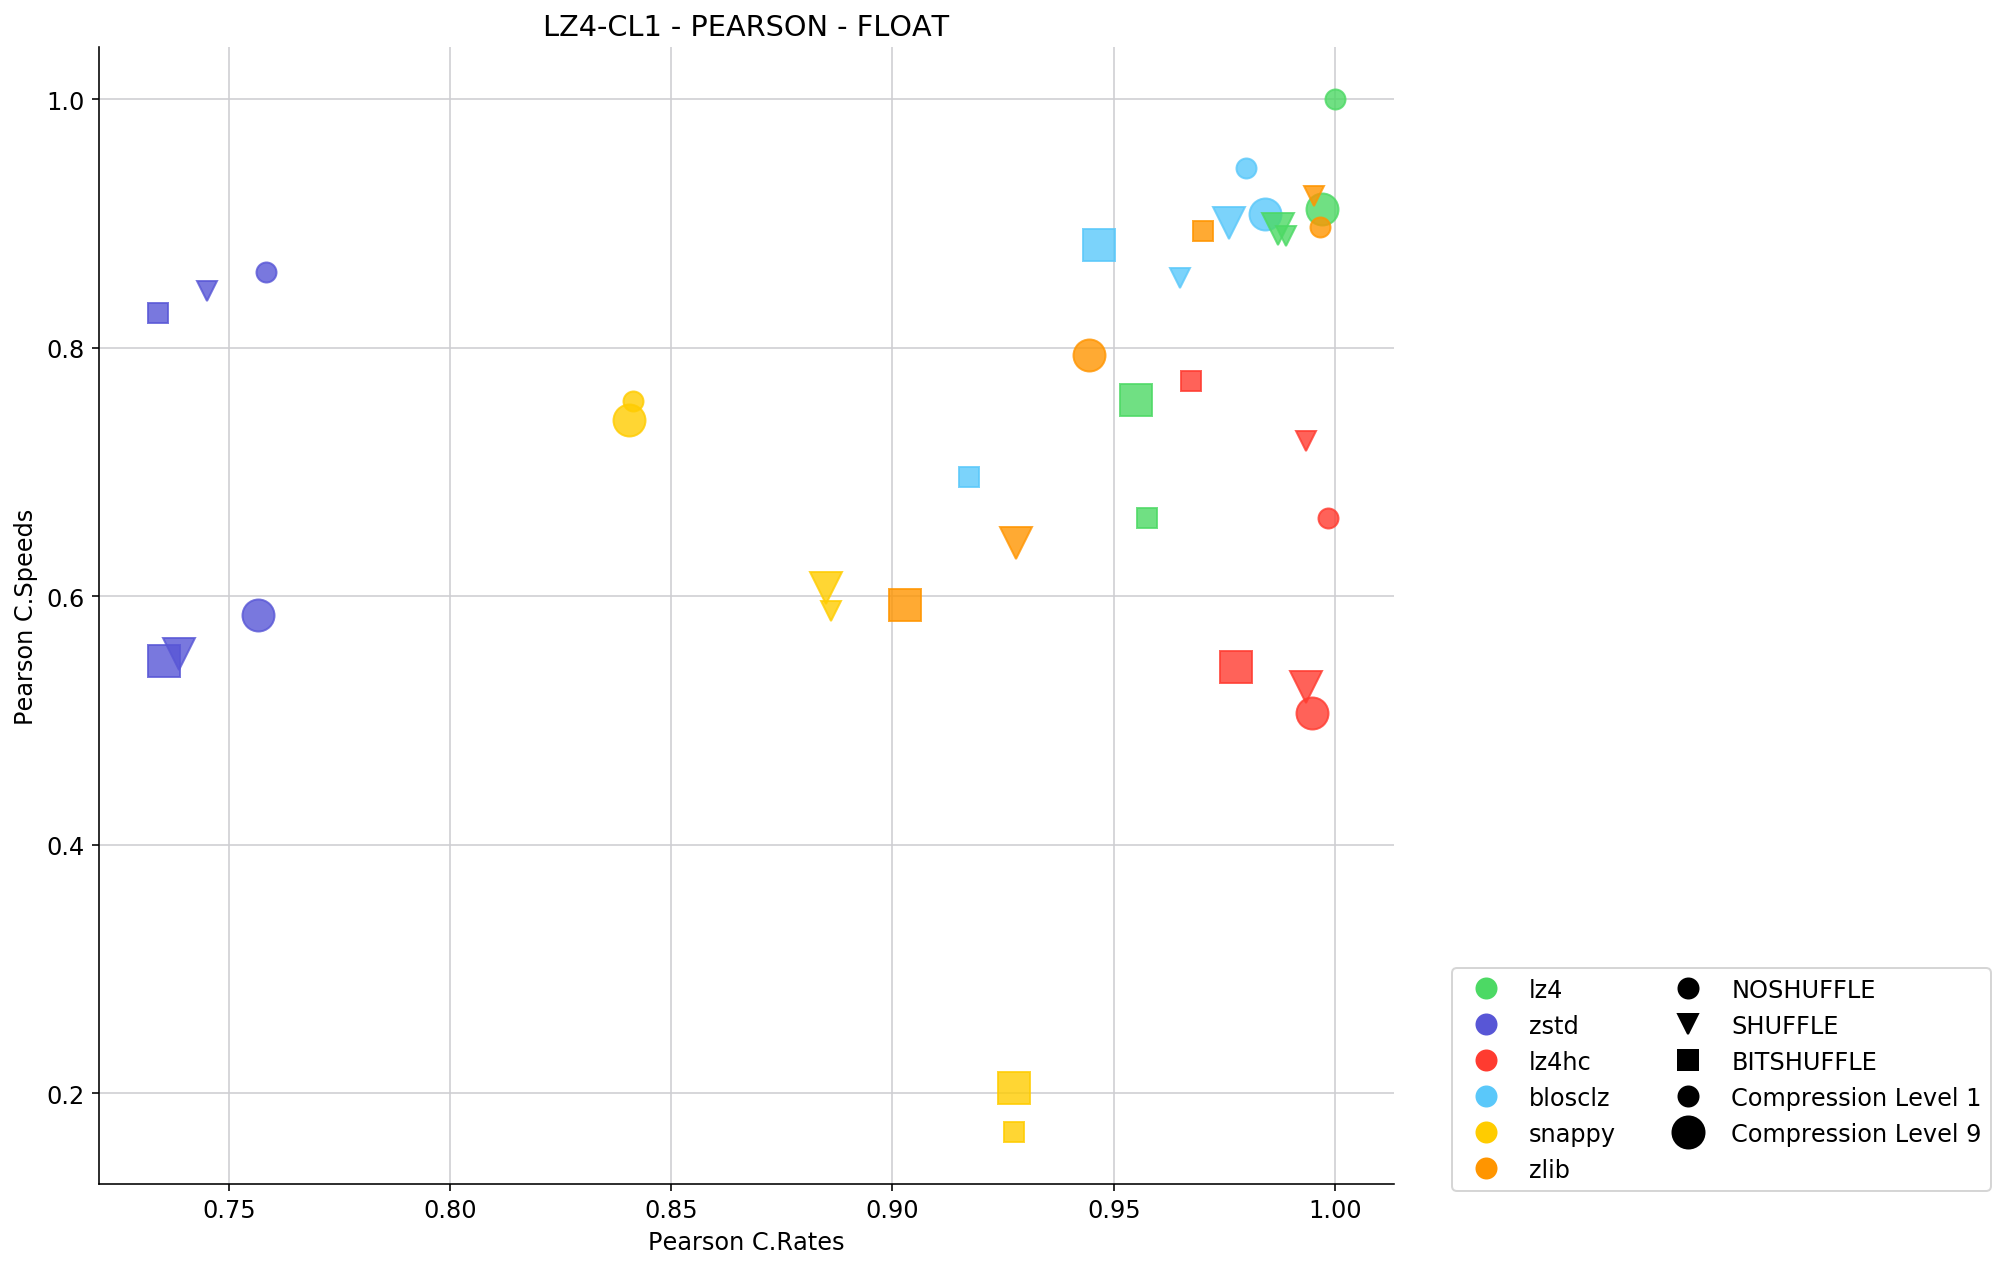

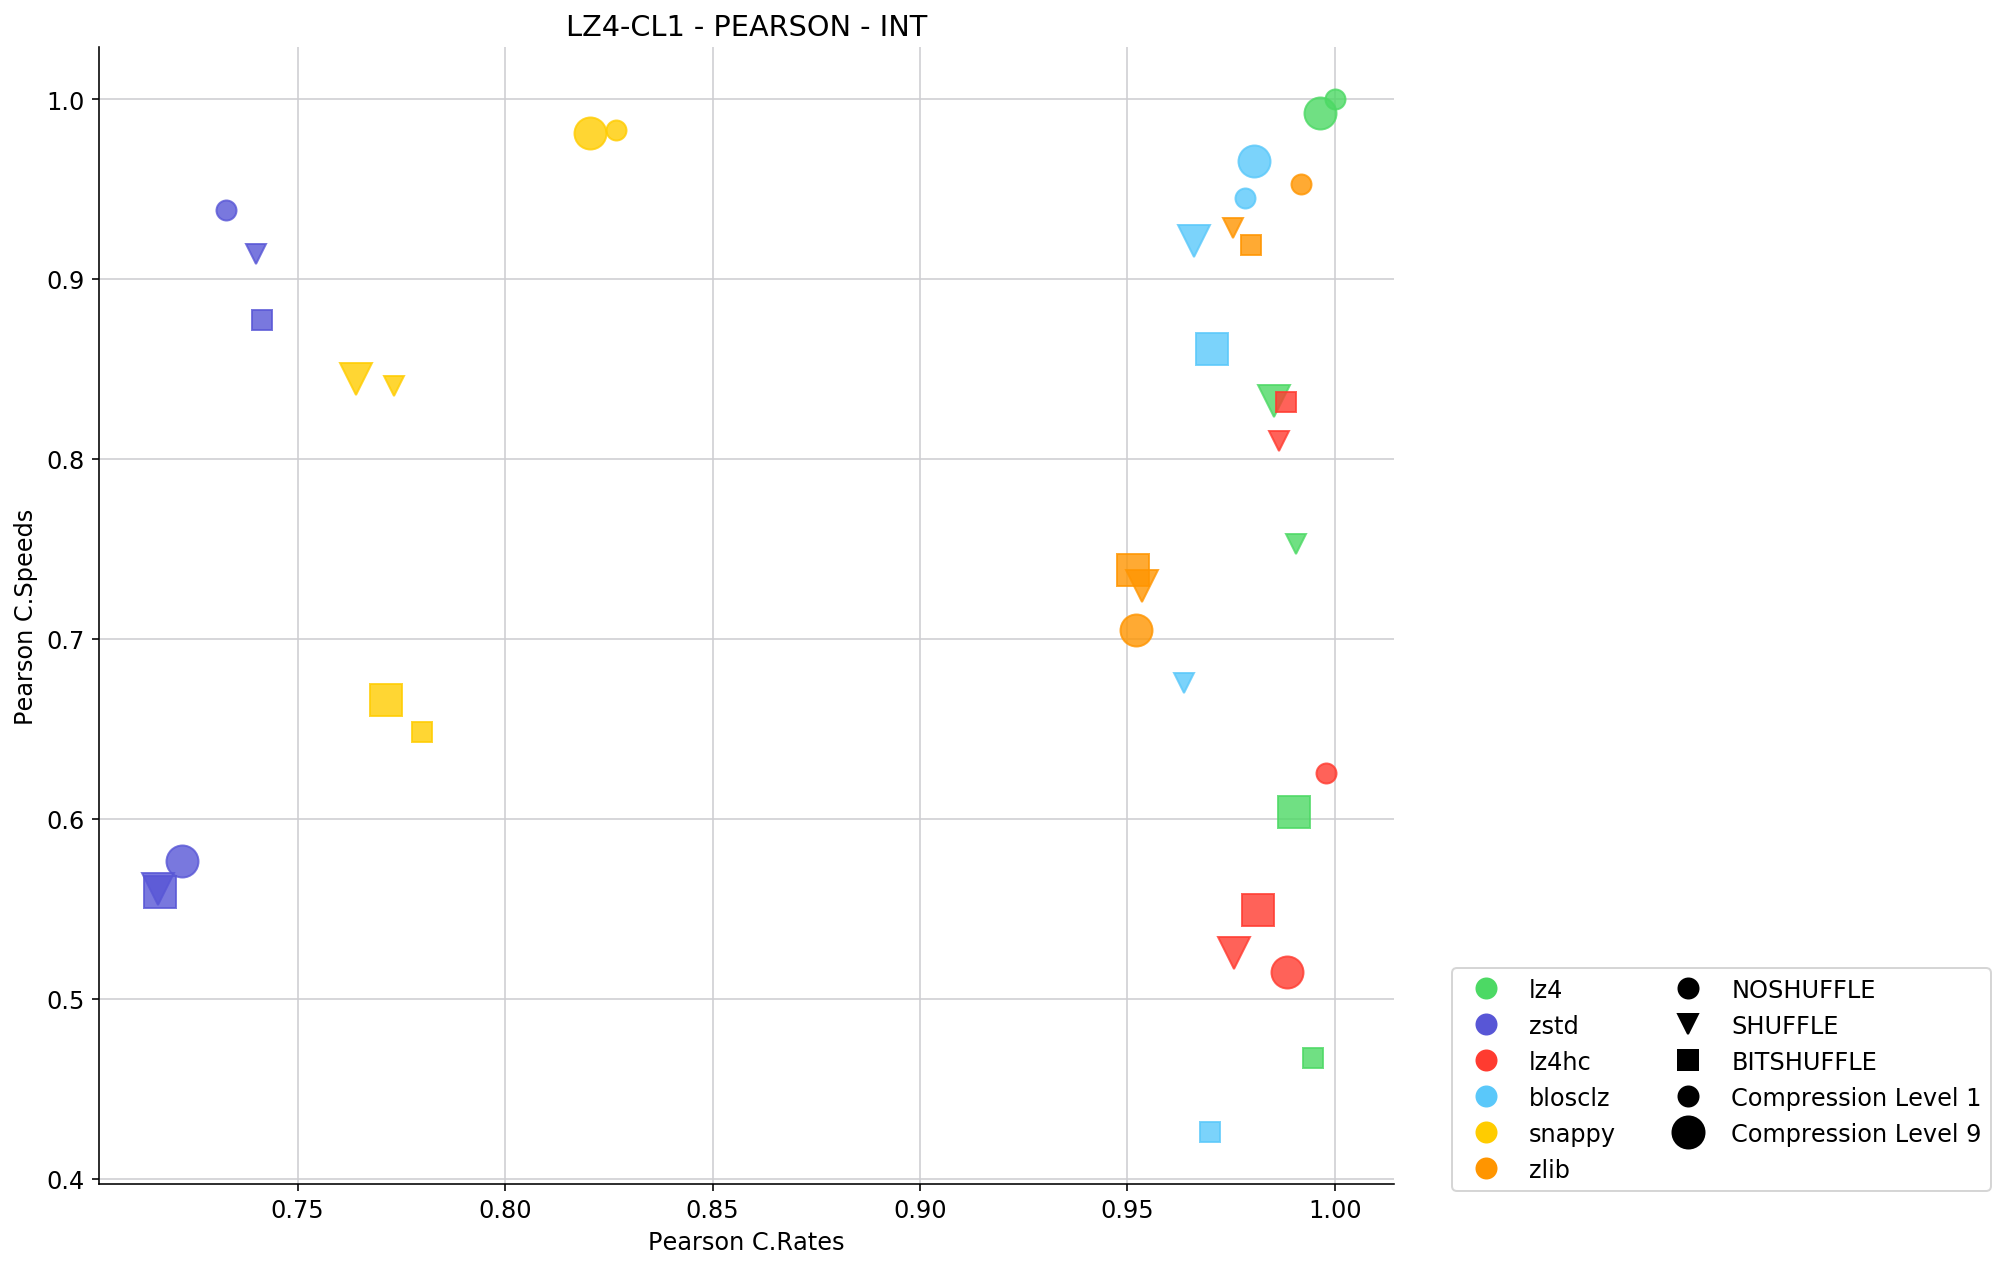

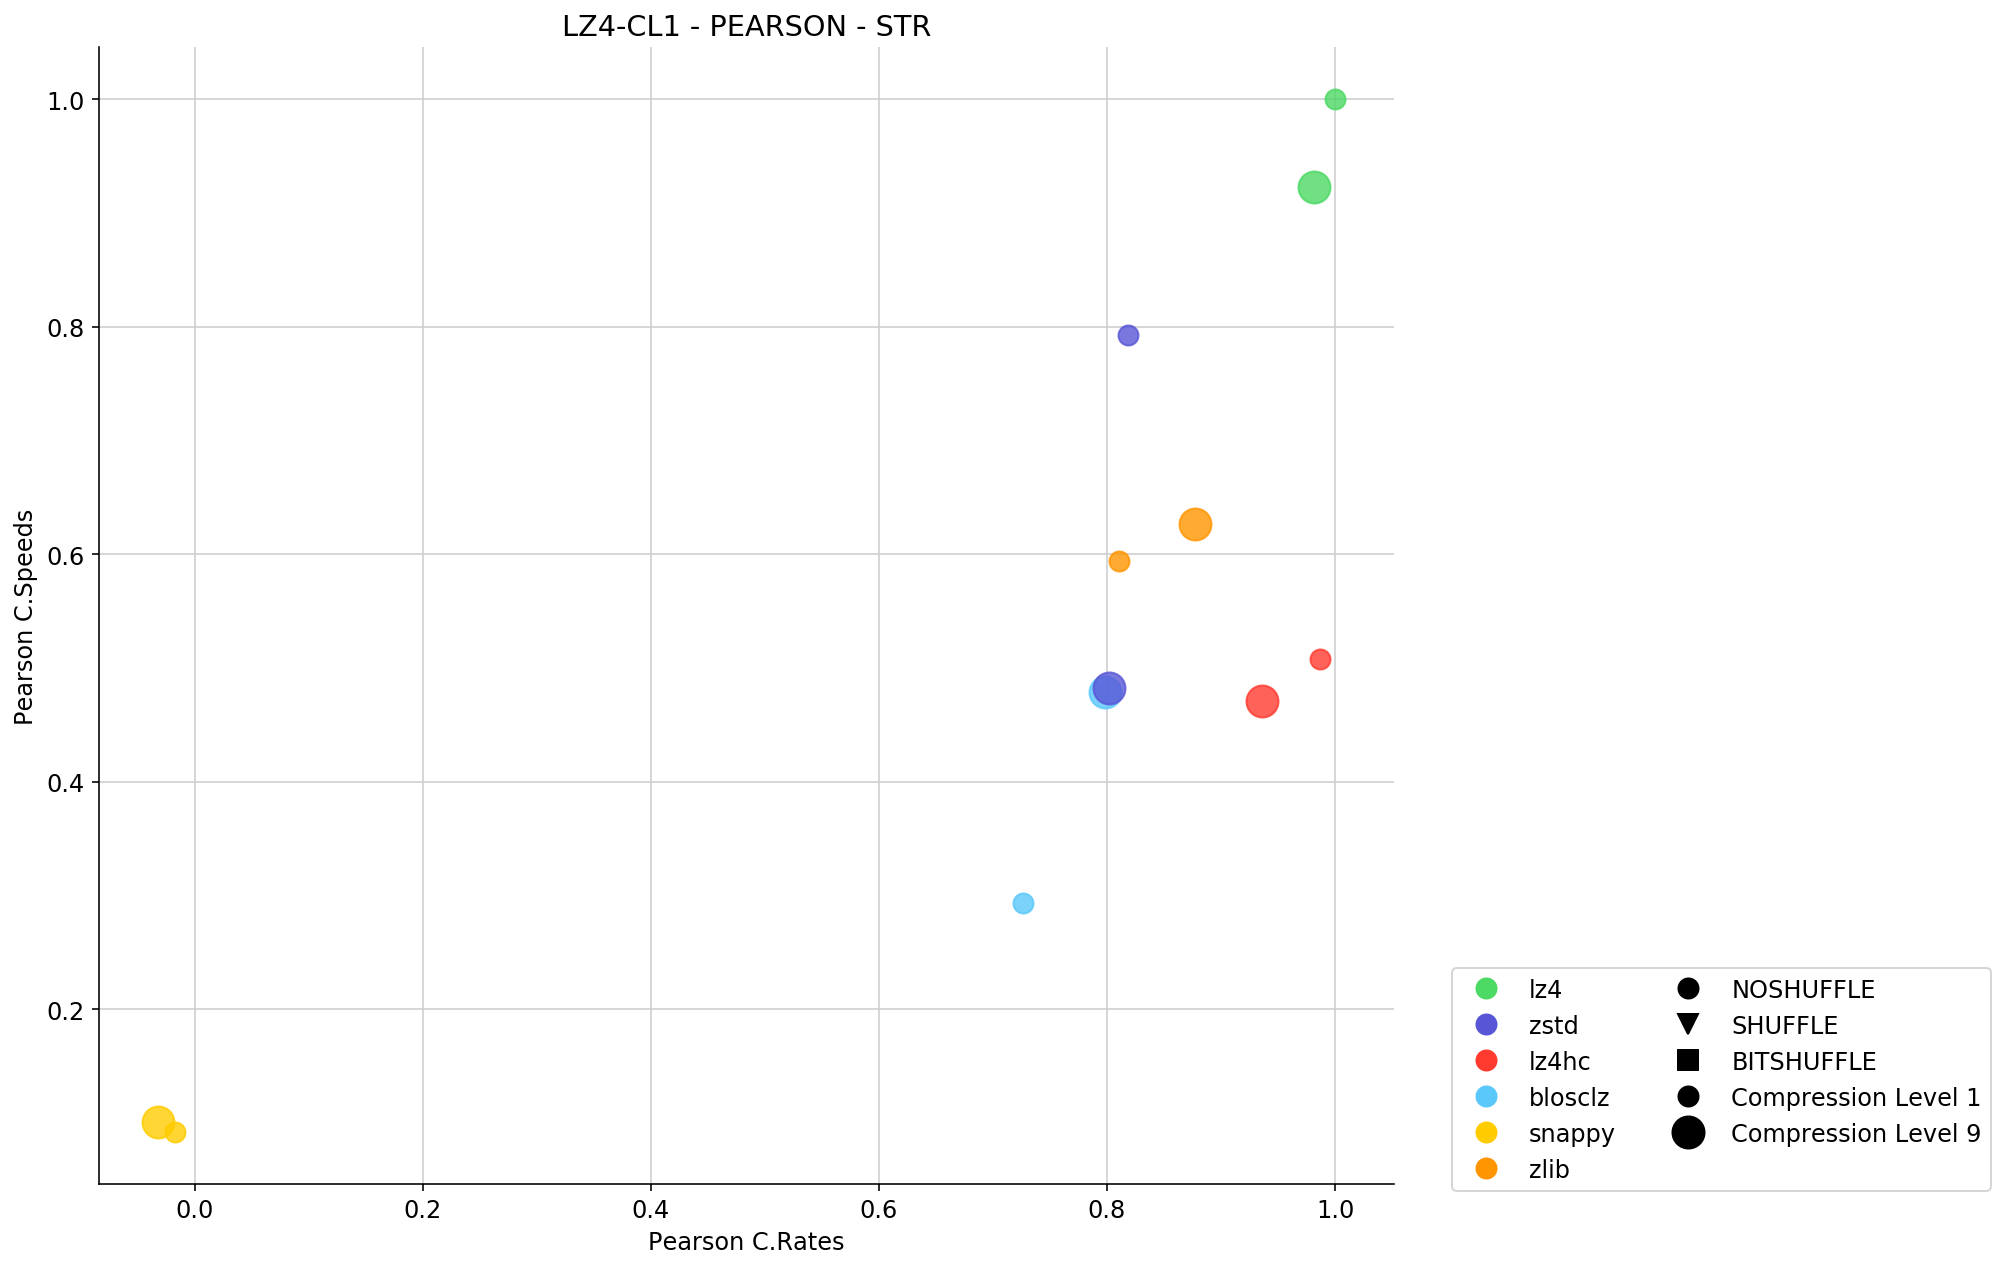

In [18]:
cst.paint_codec_pearson_corr(my_df, 'lz4', 1)

625 points


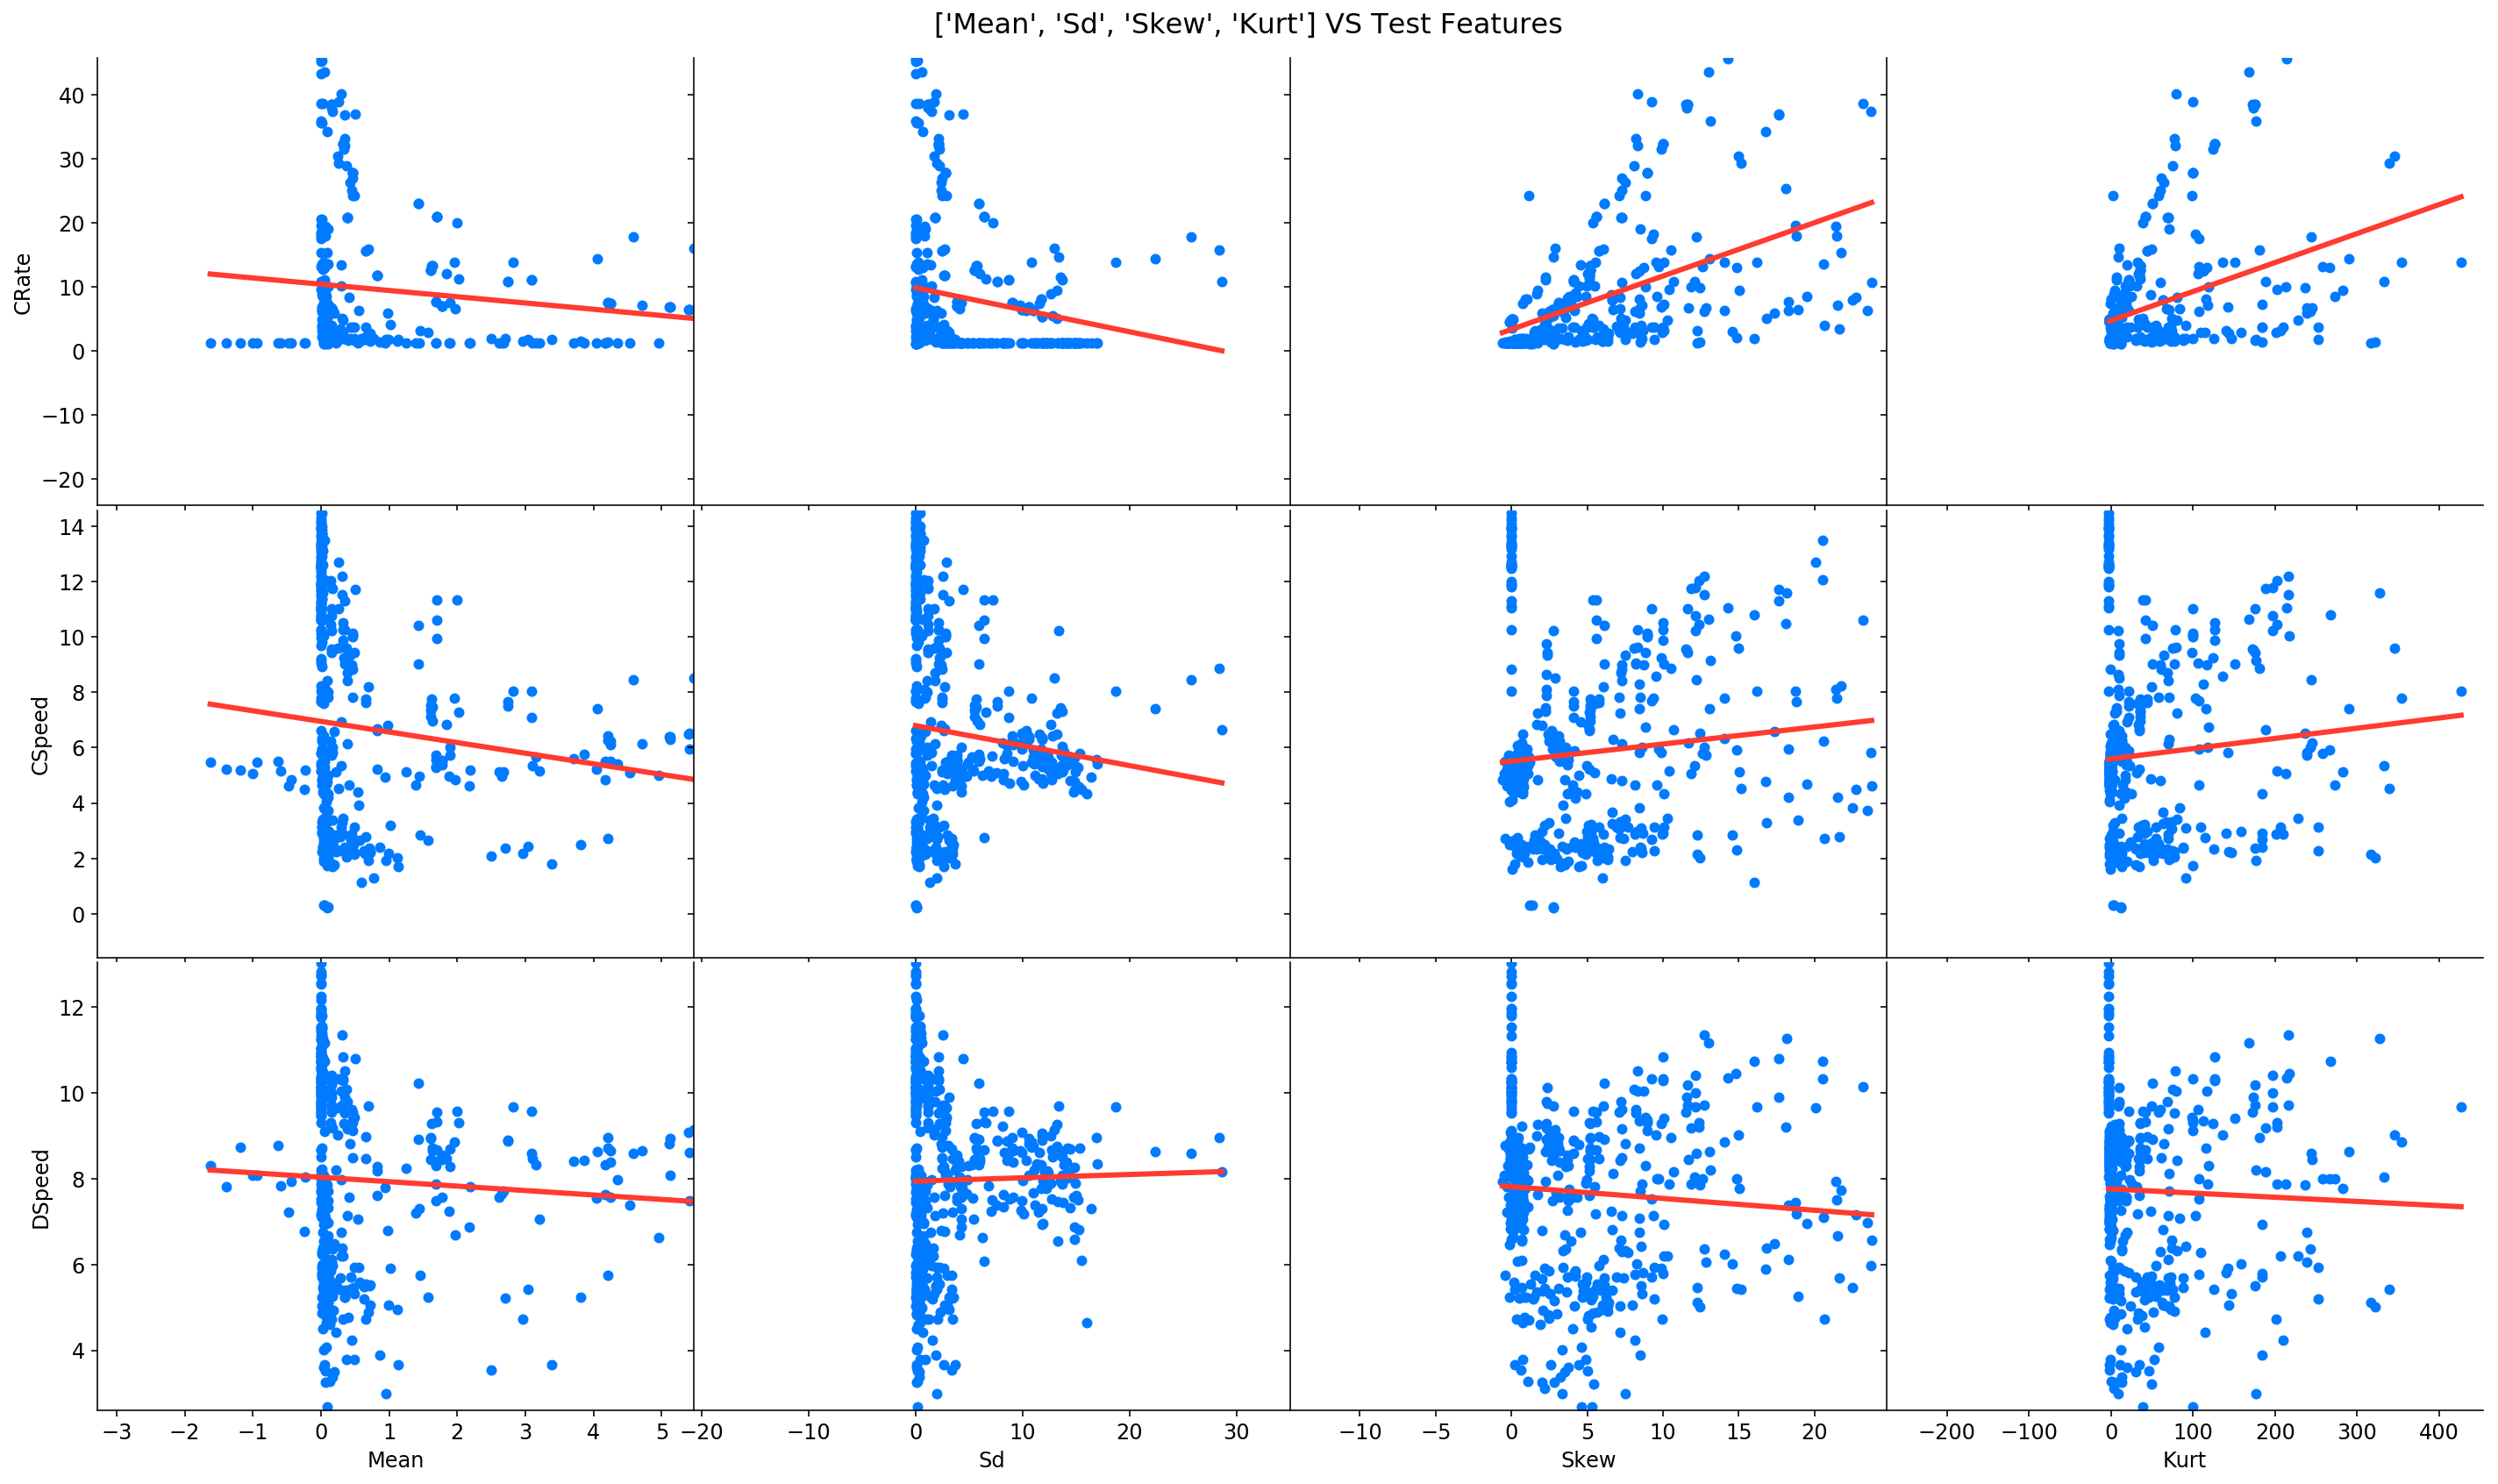

In [19]:
dfaux = my_df[(my_df.Codec == 'lz4') & (my_df.Block_Size == 256) & (my_df.Filter == 'shuffle') &
              (my_df.CL == 5) & (my_df.DType.str.contains('float') | my_df.DType.str.contains('int'))]
cols = ['Mean', 'Sd', 'Skew', 'Kurt']
cst.custom_pairs(dfaux, cols)

625 points


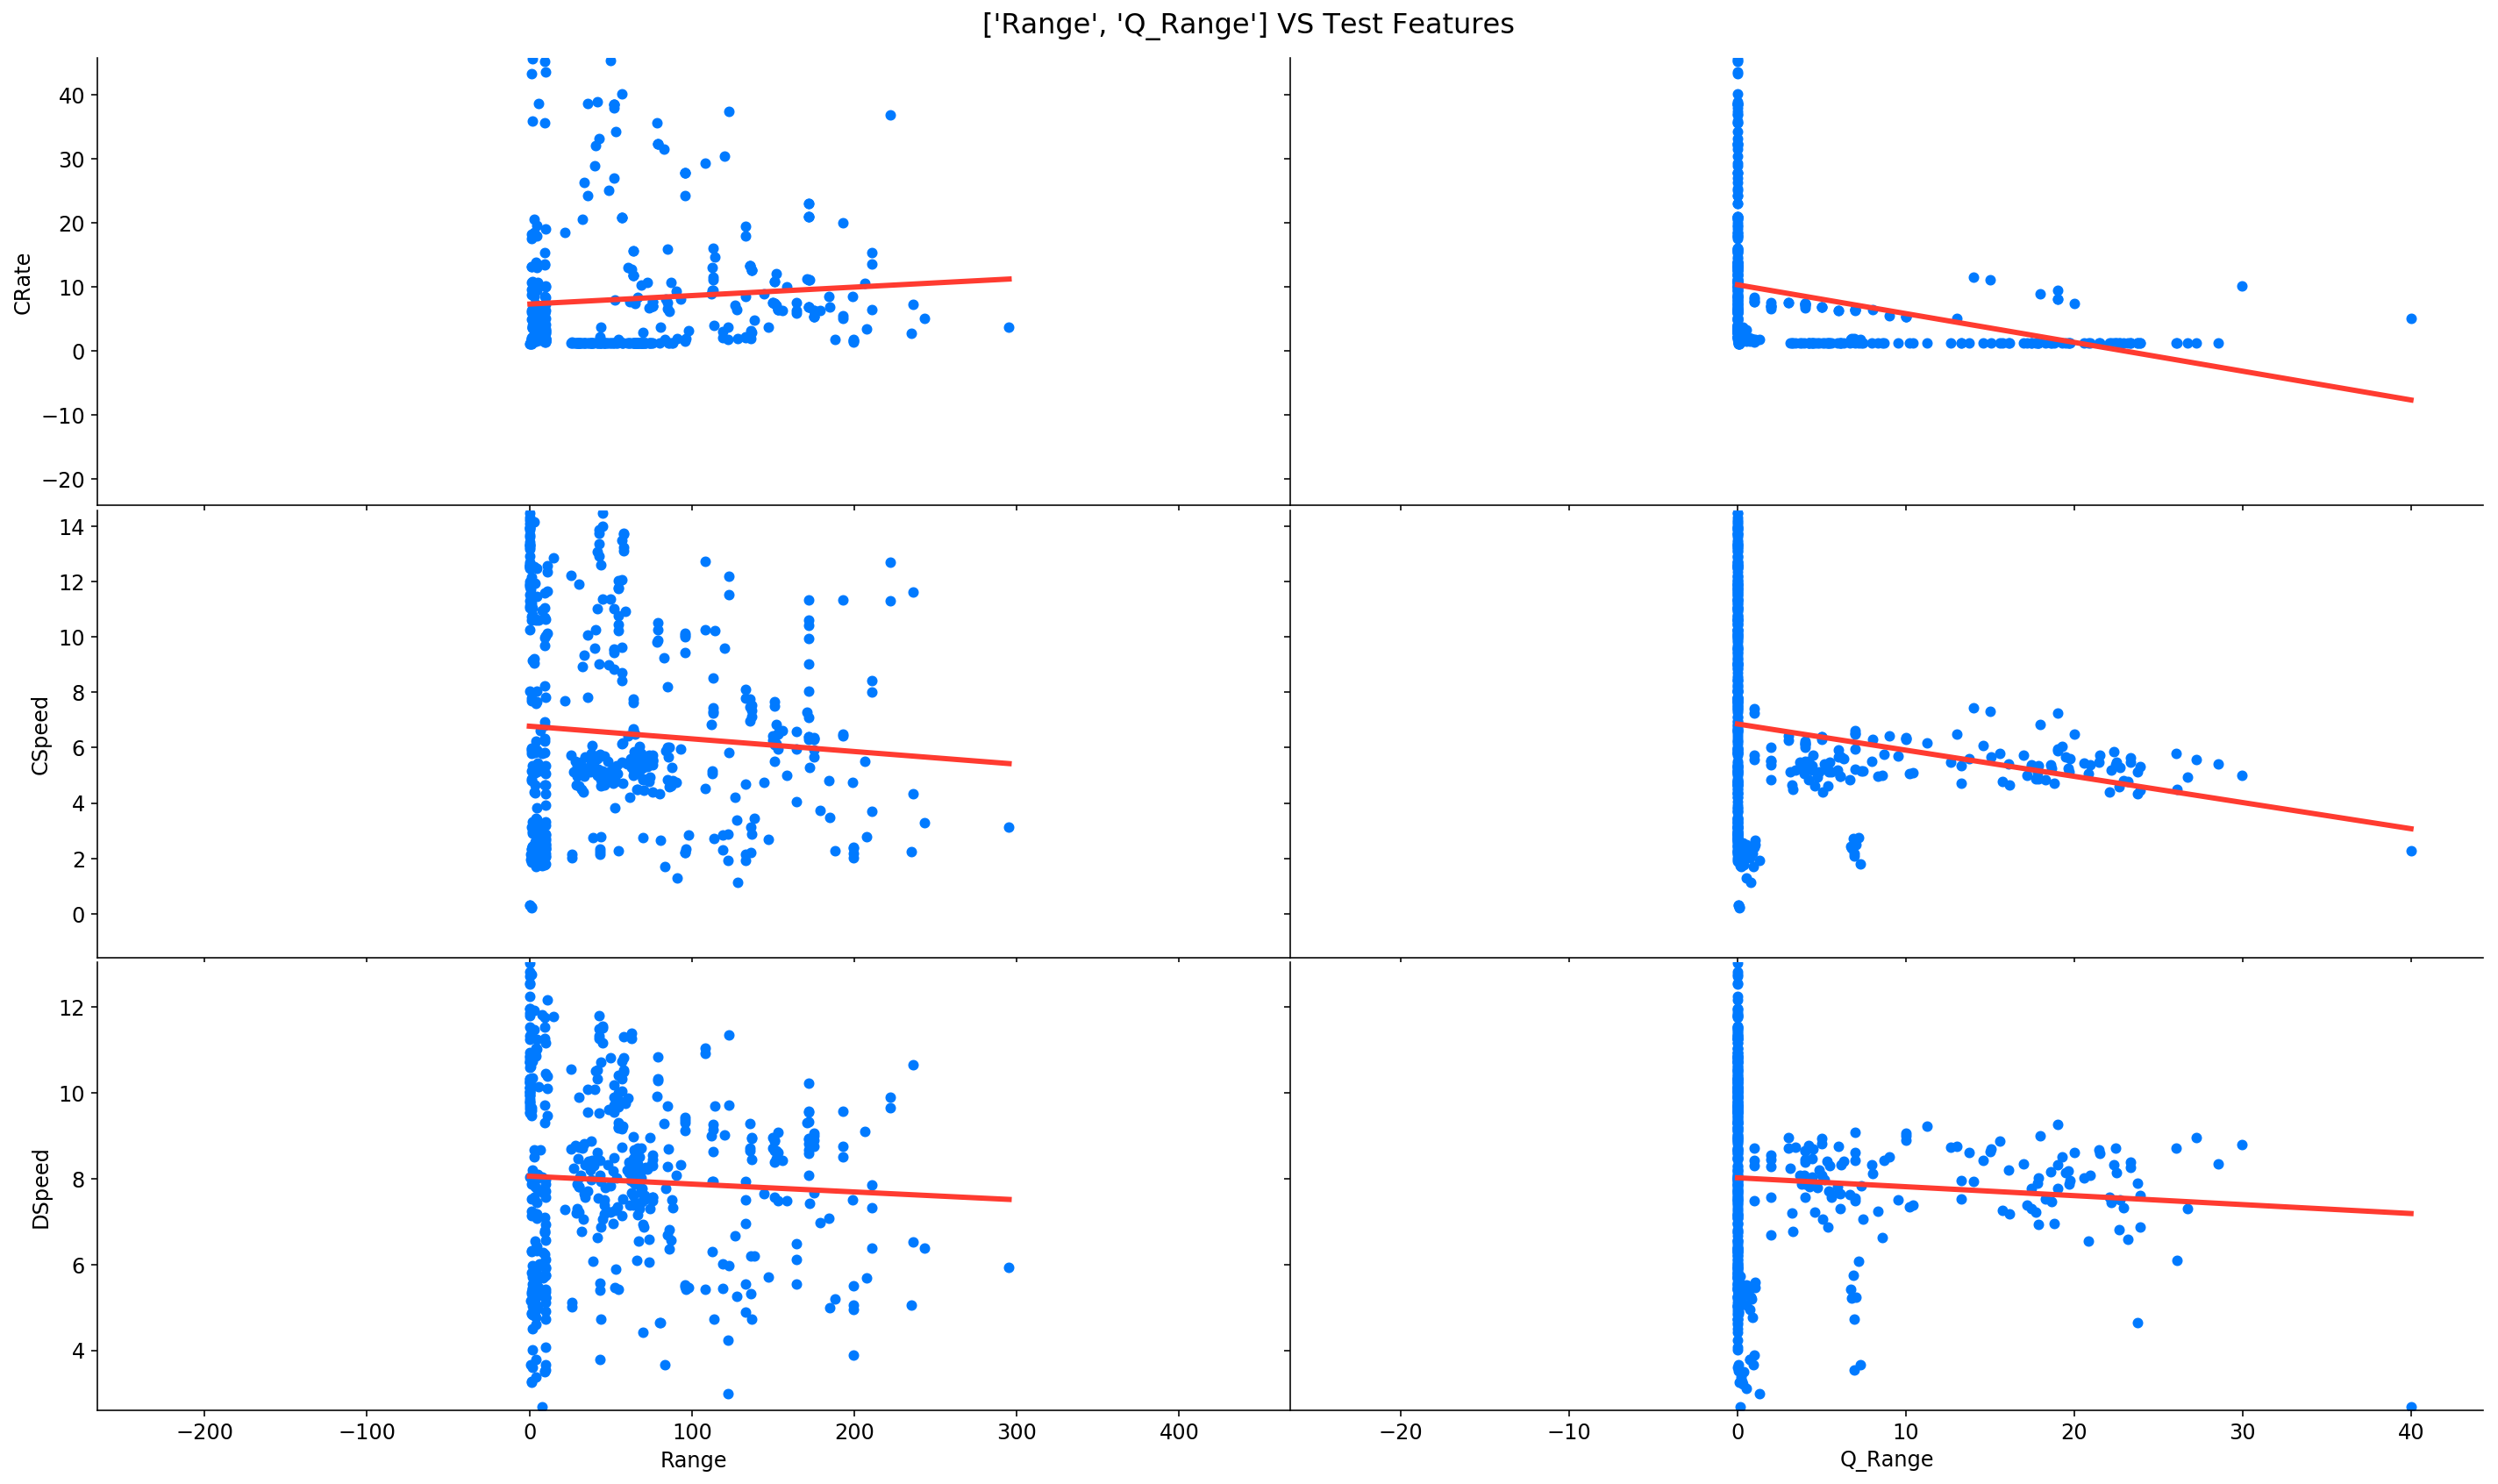

In [20]:
# TODO N_STREAKS
cols = ['Range', 'Q_Range']
dfaux = dfaux.assign(Range=dfaux['Max'] - dfaux['Min'])
dfaux = dfaux.assign(Q_Range=dfaux['Q3'] - dfaux['Q1'])
cst.custom_pairs(dfaux, cols)